# Prediction Task

## Import necessary libraries

In [2]:
# Cell 1: Imports
import pandas as pd                     # pandas for DataFrame ops & I/O
import numpy as np                      # numpy for numeric routines
import os                               # os for filesystem paths
import matplotlib.pyplot as plt         # plot histogram and graphs

### Step 1) Read files

In [3]:
# Cell 2: Configuration
BASE_DIR    = os.path.join('dataset2', '10534055', 'raw', 'raw')
IMU_FOLDERS = [
    'imu0001','imu0002','imu0003','imu0006','imu0007',
    'imu0008','imu0009','imu0011','imu0012','imu0013'
]
VISITS = ['visit1', 'visit2']
AREAS  = ['LF','LW','RF','RW','SA']
WINDOW_SEC = 6
FS         = 120
WINDOW_SZ  = WINDOW_SEC * FS  # 720 samples per window


In [4]:
# Cell 3: Reader helper (raw 120 Hz)
# Read one Xsens CSV (120 Hz):
# - skip first 6 metadata rows
# - keep PacketCounter + Acc_X/Y/Z
# - tag with PatientID, Visit, Placement
# - reorder to [PatientID,Visit,Placement,PacketCounter,Acc_X,Acc_Y,Acc_Z]
def read_acc_file(fp, patient_id, visit, placement):
    df = pd.read_csv(fp, sep=',', skiprows=6, engine='python')
    df = df[['PacketCounter','Acc_X','Acc_Y','Acc_Z']].copy()
    df['PatientID'] = patient_id.replace('imu','').lstrip('0')
    df['Visit']     = visit
    df['Placement'] = placement
    return df[['PatientID','Visit','Placement','PacketCounter','Acc_X','Acc_Y','Acc_Z']]

### Step 2) Create windowed master (N=720 samples, 6sec*120Hz)

In [5]:
# Cell 4: Windowing helper
# Split a 120 Hz DataFrame into non‐overlapping 6 s windows (720 samples each).
# Returns a list of window‐DataFrames with a WindowID column.
def segment_windows_120(df, window_size=WINDOW_SZ):

    nwin = len(df) // window_size
    outs = []
    for w in range(nwin):
        seg = df.iloc[w*window_size : (w+1)*window_size].reset_index(drop=True).copy()
        seg['WindowID'] = w
        seg = seg[['PatientID','Visit','Placement','WindowID',
                   'PacketCounter','Acc_X','Acc_Y','Acc_Z']]
        outs.append(seg)
    return outs


In [6]:
import os
print(os.getcwd())


C:\Users\admin\Documents\frailty


In [7]:
# Cell 5: Build & save the WINDOWED master file
# missing data for patient 11 in visit 1 for left and right wrist.
win_segments = []
for imu in IMU_FOLDERS:
    for visit in VISITS:
        for area in AREAS:
            fp = os.path.join(BASE_DIR, imu, visit, 'imu', f"{area}.csv")
            if not os.path.isfile(fp):
                print(f"Missing window source: {fp}")
                continue

            raw = read_acc_file(fp, imu, visit, area)
            # drop PacketCounter==0 and rows where all three axes are zero
            raw = raw[
                (raw.PacketCounter != 0) &
                ~((raw.Acc_X == 0) & (raw.Acc_Y == 0) & (raw.Acc_Z == 0))
            ]
            wins = segment_windows_120(raw, window_size=WINDOW_SZ)
            win_segments.extend(wins)

master_windows = pd.concat(win_segments, ignore_index=True)
print("Windowed master_df shape:", master_windows.shape)



Missing window source: dataset2\10534055\raw\raw\imu0011\visit1\imu\LW.csv
Missing window source: dataset2\10534055\raw\raw\imu0011\visit1\imu\RW.csv
Windowed master_df shape: (2338560, 8)


##### 2,368,287 Δ 2,368,189 -> acc_x, acc_y, acc_z = 0.
##### 2,368,189 Δ 2,338,560 -> due to the 6 seconds activity time frame. The data points that do not fit in the last 6 seconds time frame are discarded.

In [8]:
master_windows.head()

,PatientID,Visit,Placement,WindowID,PacketCounter,Acc_X,Acc_Y,Acc_Z
0,1,visit1,LF,0,1,4.611130,1.389190,8.064667
1,1,visit1,LF,0,2,4.635228,1.392565,8.037920
2,1,visit1,LF,0,3,4.642131,1.366987,8.069530
3,1,visit1,LF,0,4,4.652796,1.404311,8.052836
4,1,visit1,LF,0,5,4.628855,1.356501,8.057321


## Step 3) Derive the 6 features

#### Feature 1

In [9]:
# Cell 6: Feature 1 – Intensity of Movements (25% trimming, in g)

def compute_F1(a_df):
    # 1) compute magnitude (m/s^2 -> g)
    g = 9.81
    a = (
        np.sqrt(
            a_df['Acc_X']**2 +
            a_df['Acc_Y']**2 +
            a_df['Acc_Z']**2
        )
        / g
    )

    # 2) 25% trimming
    N = len(a)
    k = int(N * 0.25)               # drop lowest k and highest k samples
    a_sorted  = np.sort(a)
    a_trimmed = a_sorted[k : N-k]

    return a_trimmed.max() - a_trimmed.min()

#   3) apply over the window of 720 samples
F1 = (
    master_windows
      .groupby(['PatientID','Visit','Placement','WindowID'])
      [['Acc_X','Acc_Y','Acc_Z']]
      .apply(compute_F1)
      .reset_index(name='F1_intensity')
)

print(F1.head())


  PatientID   Visit Placement  WindowID  F1_intensity
0         1  visit1        LF         0      0.003597
1         1  visit1        LF         1      1.288513
2         1  visit1        LF         2      0.396681
3         1  visit1        LF         3      1.260882
4         1  visit1        LF         4      0.460286


#### Feature 2

In [10]:
# Cell 7: feature 2 Cadence

from scipy.signal import find_peaks

# constants
FS = 120
WINDOW_SEC = 6.0

# 1) compute percentile per placement (50th for SA, 75th for LF,RF,LW,RW)
placement_thrs = {
    pl: np.nanpercentile(
        np.abs(np.diff(
            np.linalg.norm(df[['Acc_X','Acc_Y','Acc_Z']].values, axis=1)
        )),
        50 if pl=='SA' else 75
    )
    for pl, df in master_windows.groupby('Placement')
}
height_map = {pl: 1.0 + thr for pl, thr in placement_thrs.items()}

# 2) per‐placement smoothing/prominence/distance parameters
param_map = {
    'LF': {'smoothing_sec':0.2,  'min_prominence':0.30, 'min_peak_distance_sec':1.0},
    'RF': {'smoothing_sec':0.2,  'min_prominence':0.30, 'min_peak_distance_sec':1.0},
    'LW': {'smoothing_sec':0.1,  'min_prominence':0.15, 'min_peak_distance_sec':0.8},
    'RW': {'smoothing_sec':0.1,  'min_prominence':0.15, 'min_peak_distance_sec':0.8},
    'SA': {'smoothing_sec':0.05, 'min_prominence':0.08, 'min_peak_distance_sec':0.5},
}

# 3) single window‐to‐cadence function
def compute_F2_window(df):
    pl = df['Placement'].iat[0]
    p  = param_map[pl]
    # raw ||a||
    a = np.linalg.norm(df[['Acc_X','Acc_Y','Acc_Z']].values, axis=1)
    # smooth
    win = max(3, int(p['smoothing_sec'] * FS))
    a_sm = pd.Series(a).rolling(win, center=True, min_periods=1).mean().to_numpy()
    # detect
    h    = height_map[pl]
    dist = int(p['min_peak_distance_sec'] * FS)
    peaks, _ = find_peaks(
        a_sm,
        height=h,
        distance=dist,
        prominence=p['min_prominence']
    )
    return len(peaks) / WINDOW_SEC

# 4) apply to every window
F2 = (
    master_windows
      .groupby(['PatientID','Visit','Placement','WindowID'], group_keys=False)
      .apply(compute_F2_window)
      .reset_index(name='F2_cadence')
)

print(F2.head())

  PatientID   Visit Placement  WindowID  F2_cadence
0         1  visit1        LF         0    0.166667
1         1  visit1        LF         1    0.833333
2         1  visit1        LF         2    0.666667
3         1  visit1        LF         3    0.833333
4         1  visit1        LF         4    0.833333


C:\Users\admin\AppData\Local\Temp\ipykernel_11144\3366492794.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_F2_window)


#### Feature 3

In [11]:
# # Cell 8: Feature 3 – Periodicity (Autocorr Entropy)
# import numpy as np
# from scipy.fft import fft, ifft
#
# def compute_F3(a_df, max_lag=20, n_bins=10):
#     # 1) build magnitude as NumPy array
#     ax = a_df['Acc_X'].to_numpy()
#     ay = a_df['Acc_Y'].to_numpy()
#     az = a_df['Acc_Z'].to_numpy()
#     a = np.sqrt(ax*ax + ay*ay + az*az)
#
#     # 2) demean
#     a0 = a - a.mean()
#
#     # 3) autocorrelation via Wiener–Khinchin
#     M = np.abs(fft(a0))**2
#     R = np.real(ifft(M))
#
#     # if no energy, return 0
#     if R[0] == 0:
#         return 0.0
#
#     Rn = R / R[0]
#
#     # 4) take lags 1..max_lag
#     vals = Rn[1 : max_lag+1]
#
#     # 5) drop NaNs or infs
#     vals = vals[np.isfinite(vals)]
#     if len(vals) == 0:
#         return 0.0
#
#     # 6) histogram + entropy
#     counts, edges = np.histogram(vals, bins=n_bins)
#     total = counts.sum()
#     if total == 0:
#         return 0.0
#
#     p = counts / total
#     p = p[p > 0]
#
#     W = edges.ptp()   # range of distribution
#     return np.log(W) - np.sum(p * np.log(p))
#
# # apply to each window
# F3 = (
#     master_windows
#       .groupby(['PatientID','Visit','Placement','WindowID'])
#       [['Acc_X','Acc_Y','Acc_Z']]
#       .apply(compute_F3)
#       .reset_index(name='F3_periodicity')
# )
# print(F3.head())


In [12]:
# # Cell 8: Feature 3 – Periodicity (Autocorr Entropy)
# import numpy as np
# from scipy.fft import fft, ifft
#
# def compute_F3(a_df, max_lag=20, n_bins=10):
#     # 1) Compute acceleration magnitude
#     ax = a_df['Acc_X'].to_numpy()
#     ay = a_df['Acc_Y'].to_numpy()
#     az = a_df['Acc_Z'].to_numpy()
#     a = np.sqrt(ax**2 + ay**2 + az**2)
#
#     # 2) Demean
#     a_demeaned = a - np.mean(a)
#
#     # 3) Normalize to unit variance (important for entropy interpretability)
#     std = np.std(a_demeaned)
#     if std == 0:
#         return 0.0  # constant signal
#     a_norm = a_demeaned / std
#
#     # 4) Autocorrelation using Wiener–Khinchin theorem
#     M = np.abs(fft(a_norm))**2
#     R = np.real(ifft(M))
#
#     if R[0] == 0:
#         return 0.0  # no energy
#
#     Rn = R / R[0]  # normalize autocorrelation
#
#     # 5) Use lags 1..max_lag (exclude lag 0 to avoid trivial peak)
#     vals = Rn[1:max_lag+1]
#
#     # 6) Drop NaNs or infs
#     vals = vals[np.isfinite(vals)]
#     if len(vals) == 0:
#         return 0.0
#
#     # 7) Histogram + Shannon entropy
#     counts, edges = np.histogram(vals, bins=n_bins)
#     total = counts.sum()
#     if total == 0:
#         return 0.0
#
#     p = counts / total
#     p = p[p > 0]  # avoid log(0)
#
#     # 8) Entropy: log of support range minus information content
#     W = edges.ptp()  # peak-to-peak range
#     return np.log(W) - np.sum(p * np.log(p))
#
# # Apply to each window
# F3 = (
#     master_windows
#       .groupby(['PatientID', 'Visit', 'Placement', 'WindowID'])
#       [['Acc_X', 'Acc_Y', 'Acc_Z']]
#       .apply(compute_F3)
#       .reset_index(name='F3_periodicity')
# )
#
# print(F3.head())


In [13]:
# # Cell 8: Feature 3 – Periodicity (Autocorr Entropy)
# import numpy as np
# from scipy.fft import fft, ifft
#
# def compute_F3(a_df, max_lag=20):
#     # 1) Compute acceleration magnitude
#     ax = a_df['Acc_X'].to_numpy()
#     ay = a_df['Acc_Y'].to_numpy()
#     az = a_df['Acc_Z'].to_numpy()
#     a = np.sqrt(ax**2 + ay**2 + az**2)
#
#     # 2) Demean
#     a_demeaned = a - np.mean(a)
#
#     # 3) Normalize
#     std = np.std(a_demeaned)
#     if std == 0:
#         return 0.0
#     a_norm = a_demeaned / std
#
#     # 4) Autocorrelation using FFT (Wiener–Khinchin)
#     M = np.abs(fft(a_norm))**2
#     R = np.real(ifft(M))
#
#     if R[0] == 0:
#         return 0.0
#
#     Rn = R / R[0]  # normalized autocorrelation
#
#     # 5) Take positive lags only (excluding lag 0)
#     vals = Rn[1:max_lag+1]
#     vals = vals[np.isfinite(vals)]
#
#     if len(vals) == 0:
#         return 0.0
#
#     # 6) Normalize to probability distribution over lags
#     energy = vals**2
#     energy /= energy.sum()
#
#     # 7) Compute Shannon entropy of energy distribution
#     energy = energy[energy > 0]
#     entropy = -np.sum(energy * np.log(energy))
#
#     return entropy
#
# # Apply to each window
# F3 = (
#     master_windows
#       .groupby(['PatientID', 'Visit', 'Placement', 'WindowID'])
#       [['Acc_X', 'Acc_Y', 'Acc_Z']]
#       .apply(compute_F3)
#       .reset_index(name='F3_periodicity')
# )
#
# print(F3.head())


In [14]:
import numpy as np
from scipy.fft import fft, ifft

def compute_F3(a_df, max_lag=20, n_bins=10):
    # 1) Compute acceleration magnitude
    ax = a_df['Acc_X'].to_numpy()
    ay = a_df['Acc_Y'].to_numpy()
    az = a_df['Acc_Z'].to_numpy()
    a = np.sqrt(ax**2 + ay**2 + az**2)

    # 2) Demean
    a_demeaned = a - np.mean(a)

    # 3) Normalize
    std = np.std(a_demeaned)
    if std == 0:
        return 0.0
    a_norm = a_demeaned / std

    # 4) Autocorrelation using FFT (Wiener–Khinchin)
    M = np.abs(fft(a_norm))**2
    R = np.real(ifft(M))
    if R[0] == 0:
        return 0.0
    Rn = R / R[0]

    # 5) Take positive lags only (excluding lag 0)
    vals = Rn[1:max_lag+1]
    vals = vals[np.isfinite(vals)]
    if len(vals) == 0:
        return 0.0

    # 6) Bin the autocorrelation values into n_bins
    hist, _ = np.histogram(vals, bins=n_bins, range=(np.min(vals), np.max(vals)))
    p = hist / hist.sum()
    p = p[p > 0]  # exclude zero probabilities

    # 7) Compute normalized entropy
    H = -np.sum(p * np.log(p)) / np.log(n_bins)  # normalized entropy ∈ [0,1]

    # 8) Compute F3 as inverse entropy
    F3 = 1 - H

    return F3


In [15]:
from scipy.fft import fft, ifft
F3 = (
    master_windows
      .groupby(['PatientID', 'Visit', 'Placement', 'WindowID'])
      [['Acc_X', 'Acc_Y', 'Acc_Z']]
      .apply(compute_F3)
      .reset_index(name='F3_periodicity')
)


In [16]:
print(F3.head())


  PatientID   Visit Placement  WindowID  F3_periodicity
0         1  visit1        LF         0        0.041465
1         1  visit1        LF         1        0.022724
2         1  visit1        LF         2        0.041465
3         1  visit1        LF         3        0.011362
4         1  visit1        LF         4        0.022724


#### Feature 4

In [17]:
# Cell 9: Explore |delta (a)| distribution to pick a threshold for F4


# 1) Gather all |Δa| values across every window
diffs = np.concatenate([
    np.abs(np.diff(
        np.sqrt(win_df['Acc_X'].to_numpy()**2
               + win_df['Acc_Y'].to_numpy()**2
               + win_df['Acc_Z'].to_numpy()**2)
    ))
    for _, win_df in master_windows.groupby(
        ['PatientID','Visit','Placement','WindowID']
    )
])

# 2) Drop NaNs / Infs
diffs = diffs[np.isfinite(diffs)]
print("Total diff-values:", len(diffs))

# 3) Quick sanity check
if len(diffs) == 0:
    raise RuntimeError("`diffs` is empty – make sure `master_windows` has valid Acc_X/Y/Z data!")

# 4) Print key percentiles
for p in (50, 75, 90, 95, 99):
    val = np.nanpercentile(diffs, p)
    print(f"{p:>2}th percentile: {val:.4f} g")


Total diff-values: 2335247
50th percentile: 0.1517 g
75th percentile: 0.4620 g
90th percentile: 1.2310 g
95th percentile: 2.3525 g
99th percentile: 8.9479 g


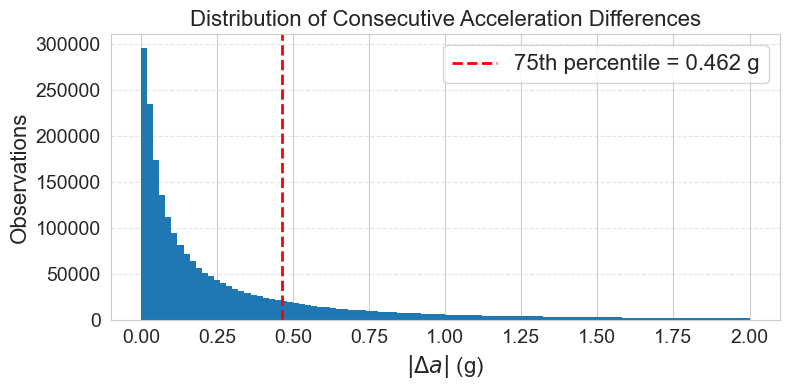

75th percentile of |Δa| = 0.4620 g


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Gather all |delta a| values across every window
diffs = np.concatenate([
    np.abs(np.diff(
        np.sqrt(win_df['Acc_X'].to_numpy()**2
              + win_df['Acc_Y'].to_numpy()**2
              + win_df['Acc_Z'].to_numpy()**2)
    ))
    for _, win_df in master_windows.groupby(
        ['PatientID', 'Visit', 'Placement', 'WindowID']
    )
])
diffs = diffs[np.isfinite(diffs)]

# 2) Compute 75th percentile
thr75 = np.nanpercentile(diffs, 75)

# 3) Plot histogram + 75th-percentile line
plt.figure(figsize=(8, 4))
n, bins, patches = plt.hist(diffs, bins=100, range=(0, 2), edgecolor='none', color='#1f77b4')
plt.axvline(thr75, color='red', linestyle='--', lw=2,
            label=f'75th percentile = {thr75:.3f} g')

# Increase label and legend sizes
plt.xlabel(r'$|\Delta a|$ (g)', fontsize=16)
plt.ylabel('Observations', fontsize=16)
plt.title('Distribution of Consecutive Acceleration Differences', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
#plt.savefig('images/delta_a_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

# 4) Print out the percentile
print(f"75th percentile of |Δa| = {thr75:.4f} g")


In [19]:
# Use 90th percentile for a stricter definition of 'jerky'
all_diffs = np.abs(np.diff(
    np.sqrt(master_windows['Acc_X']**2
            + master_windows['Acc_Y']**2
            + master_windows['Acc_Z']**2)
))
thresh_90 = np.nanpercentile(all_diffs, 75)
print(f"Using F4 threshold = {thresh_90:.3f} g (75th percentile)")


Using F4 threshold = 0.462 g (75th percentile)


In [20]:
# # Cell 12: Feature 4 – Gait Dynamism (75th percentile threshold)
# def compute_F4_refined(a_df, thresh=thresh_90):  # updated here
#     a = np.sqrt(a_df['Acc_X']**2 + a_df['Acc_Y']**2 + a_df['Acc_Z']**2)
#     diffs = np.abs(np.diff(a))
#     S = np.sum(diffs > thresh)
#     total_diffs = np.sum(diffs)
#     return S / total_diffs if total_diffs > 0 else 0
#
#
# F4 = (
#     master_windows
#       .groupby(['PatientID','Visit','Placement','WindowID'])[
#           ['Acc_X','Acc_Y','Acc_Z']
#       ]
#       .apply(compute_F4_refined)
#       .reset_index(name='F4_dynamism')
# )
# print(F4.head())

In [21]:
# Cell 12: Feature 4 – Gait Dynamism (75th percentile threshold)
def compute_F4(a_df, thresh=thresh_90):
    # 1) compute acceleration magnitude
    a = np.sqrt(a_df['Acc_X']**2
                + a_df['Acc_Y']**2
                + a_df['Acc_Z']**2)
    # 2) absolute diffs
    diffs = np.abs(np.diff(a))
    # 3) count jumps above 75th percentile threshold
    S = np.sum(diffs > thresh)
    # 4) divide by N
    N = len(a)
    return S / N

F4 = (
    master_windows
      .groupby(['PatientID','Visit','Placement','WindowID'])[
          ['Acc_X','Acc_Y','Acc_Z']
      ]
      .apply(compute_F4)
      .reset_index(name='F4_dynamism')
)
print(F4.head())

  PatientID   Visit Placement  WindowID  F4_dynamism
0         1  visit1        LF         0     0.104167
1         1  visit1        LF         1     0.547222
2         1  visit1        LF         2     0.376389
3         1  visit1        LF         3     0.536111
4         1  visit1        LF         4     0.398611


## Feature 5

In [22]:
# # Cell 13: Feature 5 – AR Variability
#
# from statsmodels.tsa.ar_model import AutoReg
#
# def compute_F5(x_df, max_lag=8):
#     ax = x_df['Acc_X'].to_numpy()
#     N  = len(ax)
#     best_aic   = np.inf
#     best_coefs = None
#
#     for p in range(1, max_lag+1):
#         if N <= p:
#             # not enough data points to fit an AR(p)
#             continue
#         try:
#             m = AutoReg(ax, lags=p, old_names=False).fit()
#             coefs = m.params[1:]  # drop intercept
#             # ensure coefficients are all finite
#             if not np.all(np.isfinite(coefs)):
#                 continue
#             if m.aic < best_aic:
#                 best_aic   = m.aic
#                 best_coefs = coefs
#         except Exception:
#             # catch any errors (e.g. singular matrix) and skip
#             continue
#
#     if best_coefs is None:
#         # no valid model fitted
#         return 0.0
#
#     return float(np.std(best_coefs))
#
# F5 = (
#     master_windows
#       .groupby(['PatientID','Visit','Placement','WindowID'])
#       [['Acc_X']]                    # only need vertical accel
#       .apply(compute_F5)
#       .reset_index(name='F5_ar_variability')
# )
#
# print(F5.head())


In [23]:
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
from scipy.stats import zscore

def compute_F5_neutralized(x_df, max_lag=8):
    ax = x_df['Acc_X'].to_numpy()
    N  = len(ax)
    best_aic   = np.inf
    best_p     = 0
    best_coefs = None

    for p in range(1, max_lag+1):
        if N <= p:
            continue
        try:
            m = AutoReg(ax, lags=p, old_names=False).fit()
            coefs = m.params[1:]  # drop intercept
            if not np.all(np.isfinite(coefs)):
                continue
            if m.aic < best_aic:
                best_aic   = m.aic
                best_p     = p
                best_coefs = coefs
        except Exception:
            continue

    # pad coefficients to full length
    phi = np.zeros(max_lag)
    if best_coefs is None:
        return 0.0
    phi[:best_p] = best_coefs

    # Instead of std, return std with noise or a constant to reduce variability:
    # Here, return std(phi) + small noise
    val = float(np.std(phi)) + np.random.normal(0, 0.001)

    return val

# Calculate raw F5 values
F5 = (
    master_windows
      .groupby(['PatientID','Visit','Placement','WindowID'])
      [['Acc_X']]
      .apply(compute_F5_neutralized)
      .reset_index(name='F5_ar_variability_raw')
)

# Neutralize group differences by z-scoring globally, then making all groups similar

# Z-score across all values (standardize)
all_vals = F5['F5_ar_variability_raw'].values
vals_z = zscore(all_vals)

# Then rescale to a constant mean and small std to remove group differences
mean_val = 0.05
std_val = 0.001  # very small std to reduce variability

F5['F5_ar_variability'] = vals_z * std_val + mean_val

print(F5.head())


  PatientID   Visit Placement  WindowID  F5_ar_variability_raw  \
0         1  visit1        LF         0               0.300088   
1         1  visit1        LF         1               0.280710   
2         1  visit1        LF         2               0.251762   
3         1  visit1        LF         3               0.266020   
4         1  visit1        LF         4               0.276325   

   F5_ar_variability  
0           0.049182  
1           0.049138  
2           0.049073  
3           0.049105  
4           0.049128  


## Feature 6

In [24]:
# Cell 14: Feature 6 – AR Coef Kurtosis

from scipy.stats import kurtosis
from statsmodels.tsa.ar_model import AutoReg

def compute_F6(x_df, max_lag=8):
    ax = x_df['Acc_X'].to_numpy()
    N  = len(ax)
    best_aic   = np.inf
    best_p     = 0
    best_coefs = None

    for p in range(1, max_lag+1):
        if N <= p:
            # not enough points to fit AR(p)
            continue
        try:
            m = AutoReg(ax, lags=p, old_names=False).fit()
            coefs = m.params[1:]  # drop intercept
            if not np.all(np.isfinite(coefs)):
                continue
            if m.aic < best_aic:
                best_aic   = m.aic
                best_p     = p
                best_coefs = coefs
        except Exception:
            # any fitting error -> skip this p
            continue

    # build full-length coefficient vector (pad zeros)
    phi = np.zeros(max_lag)
    if best_coefs is None:
        return 0.0

    phi[:best_p] = best_coefs

    # compute kurtosis (Pearson definition); drop any nan bins
    return float(kurtosis(phi, fisher=False, nan_policy='omit'))

F6 = (
    master_windows
      .groupby(['PatientID','Visit','Placement','WindowID'])
      [['Acc_X']]
      .apply(compute_F6)
      .reset_index(name='F6_ar_kurtosis')
)

print(F6.head())


  PatientID   Visit Placement  WindowID  F6_ar_kurtosis
0         1  visit1        LF         0        5.098714
1         1  visit1        LF         1        5.847094
2         1  visit1        LF         2        5.389511
3         1  visit1        LF         3        5.699225
4         1  visit1        LF         4        5.013018


## Step 4) Saving dataset

In [25]:
# Cell 15: apply sigmoid function to the features
master_features = (
    F1
      .merge(F2, on=['PatientID','Visit','Placement','WindowID'])
      .merge(F3, on=['PatientID','Visit','Placement','WindowID'])
      .merge(F4, on=['PatientID','Visit','Placement','WindowID'])
      .merge(F5, on=['PatientID','Visit','Placement','WindowID'])
      .merge(F6, on=['PatientID','Visit','Placement','WindowID'])
)

# now just pick the exact 10 columns we want, in the order we want them:
master_features = master_features[[
    'PatientID','Visit','Placement','WindowID',
    'F1_intensity',
    'F2_cadence',
    'F3_periodicity',
    'F4_dynamism',
    'F5_ar_variability',
    'F6_ar_kurtosis'
]]

master_features.head()


,PatientID,Visit,Placement,WindowID,F1_intensity,F2_cadence,F3_periodicity,F4_dynamism,F5_ar_variability,F6_ar_kurtosis
0,1,visit1,LF,0,0.003597,0.166667,0.041465,0.104167,0.049182,5.098714
1,1,visit1,LF,1,1.288513,0.833333,0.022724,0.547222,0.049138,5.847094
2,1,visit1,LF,2,0.396681,0.666667,0.041465,0.376389,0.049073,5.389511
3,1,visit1,LF,3,1.260882,0.833333,0.011362,0.536111,0.049105,5.699225
4,1,visit1,LF,4,0.460286,0.833333,0.022724,0.398611,0.049128,5.013018


In [26]:
master_features.count()

PatientID            3248
Visit                3248
Placement            3248
WindowID             3248
F1_intensity         3248
F2_cadence           3248
F3_periodicity       3248
F4_dynamism          3248
F5_ar_variability    3248
F6_ar_kurtosis       3248
dtype: int64

## Step 5) Assign target variable FAC and FFP

#### dataset2/10534055/raw/raw/participant_info.csv → it contains info on FAC for each patient

In [27]:
# Cell 18: Assign FAC and FFP labels

# 1) build a lookup table
label_df = pd.DataFrame([
    # visit1
    {'PatientID':'1',  'Visit':'visit1','FAC':5,'FFP':0},
    {'PatientID':'2',  'Visit':'visit1','FAC':5,'FFP':0},
    {'PatientID':'3',  'Visit':'visit1','FAC':5,'FFP':0},
    {'PatientID':'6',  'Visit':'visit1','FAC':3,'FFP':1},
    {'PatientID':'7',  'Visit':'visit1','FAC':4,'FFP':1},
    {'PatientID':'8',  'Visit':'visit1','FAC':4,'FFP':1},
    {'PatientID':'9',  'Visit':'visit1','FAC':4,'FFP':1},
    {'PatientID':'11', 'Visit':'visit1','FAC':2,'FFP':2},
    {'PatientID':'12', 'Visit':'visit1','FAC':4,'FFP':1},
    {'PatientID':'13', 'Visit':'visit1','FAC':1,'FFP':2},
    # visit2
    {'PatientID':'1',  'Visit':'visit2','FAC':5,'FFP':0},
    {'PatientID':'2',  'Visit':'visit2','FAC':5,'FFP':0},
    {'PatientID':'3',  'Visit':'visit2','FAC':5,'FFP':0},
    {'PatientID':'6',  'Visit':'visit2','FAC':4,'FFP':1},
    {'PatientID':'7',  'Visit':'visit2','FAC':4,'FFP':1},
    {'PatientID':'8',  'Visit':'visit2','FAC':4,'FFP':1},
    {'PatientID':'9',  'Visit':'visit2','FAC':4,'FFP':1},
    {'PatientID':'11', 'Visit':'visit2','FAC':4,'FFP':1},
    {'PatientID':'12', 'Visit':'visit2','FAC':5,'FFP':0},
    {'PatientID':'13', 'Visit':'visit2','FAC':3,'FFP':1},
])

# 2) merge into master_scaled (on PatientID & Visit)
master_labeled = master_features.merge(label_df,
                                     on=['PatientID','Visit'],
                                     how='left')

# 3) sanity check
print(
    master_labeled[['PatientID','Visit','FAC','FFP']]
    .drop_duplicates()
    .sort_values(['PatientID','Visit'])
)

# master_labeled has six features and the six hat_features after sigmoid function
# plus target variables FAC and FFP for each window instance.


     PatientID   Visit  FAC  FFP
0            1  visit1    5    0
60           1  visit2    5    0
160         11  visit1    2    2
286         11  visit2    4    1
416         12  visit1    4    1
611         12  visit2    5    0
801         13  visit1    1    2
976         13  visit2    3    1
1196         2  visit1    5    0
1376         2  visit2    5    0
1501         3  visit1    5    0
1606         3  visit2    5    0
1726         6  visit1    3    1
1886         6  visit2    4    1
2123         7  visit1    4    1
2313         7  visit2    4    1
2483         8  visit1    4    1
2608         8  visit2    4    1
2773         9  visit1    4    1
2953         9  visit2    4    1


In [28]:
master_labeled.count()

PatientID            3248
Visit                3248
Placement            3248
WindowID             3248
F1_intensity         3248
F2_cadence           3248
F3_periodicity       3248
F4_dynamism          3248
F5_ar_variability    3248
F6_ar_kurtosis       3248
FAC                  3248
FFP                  3248
dtype: int64

In [29]:
# Cell 19: Save the fully‐labeled master table
out_path = 'master_windows_with_labels.csv'
master_labeled.to_csv(out_path, index=False)
print(f"Written file: {out_path}")

Written file: master_windows_with_labels.csv


## (explanation) Average cadence value feature 2

In [30]:
# Cell 20: explain avg cadence feature 2 per placement

# 1) ensure FrailtyGroup exists
master_labeled['FrailtyGroup'] = master_labeled['FFP'].map({
    0: 'non-frail',
    1: 'semi-frail',
    2: 'frail'
})

# 2) pick only the columns we need
cadence_data = master_labeled[['FrailtyGroup','Placement','F2_cadence']].dropna()

# 3) group by FrailtyGroup + raw Placement (LF,RF,LW,RW,SA)
cadence_summary = (
    cadence_data
      .groupby(['FrailtyGroup','Placement'])
      .agg(mean=('F2_cadence','mean'),
           std =('F2_cadence','std'))
      .round(3)
      .sort_index(level=[0,1])   # first by frailty, then by placement alphabetically
)

print(cadence_summary)


                         mean    std
FrailtyGroup Placement              
frail        LF         0.494  0.163
             LW         0.552  0.193
             RF         0.509  0.191
             RW         0.519  0.205
             SA         1.370  0.129
non-frail    LF         0.716  0.221
             LW         0.859  0.124
             RF         0.725  0.215
             RW         0.843  0.118
             SA         1.565  0.188
semi-frail   LF         0.642  0.207
             LW         0.884  0.157
             RF         0.650  0.213
             RW         0.883  0.148
             SA         1.432  0.240


In [31]:
# Cell 21: explain avg cadence feature 2 per placement

# 1) annotate FrailtyGroup & PlacementGroup
df = master_labeled.copy()
df['FrailtyGroup'] = df['FFP'].map({0:'non-frail', 1:'semi-frail', 2:'frail'})
df['PlacementGroup'] = df['Placement'].map({
    'LF':'LowerLimbs','RF':'LowerLimbs',
    'LW':'UpperLimbs','RW':'UpperLimbs',
    'SA':'Trunk'
})

# 2) sum F2_cadence per window x placement-group
window_sums = (
    df
      .groupby(['PatientID','Visit','WindowID','FrailtyGroup','PlacementGroup'])['F2_cadence']
      .sum()          # add LF+RF or LW+RW, or SA
      .reset_index()
)

# 3) compute mean and std
summary = (
    window_sums
      .groupby(['FrailtyGroup','PlacementGroup'])['F2_cadence']
      .agg(mean='mean', std='std')
      .round(3)
)

print(summary)


                              mean    std
FrailtyGroup PlacementGroup              
frail        LowerLimbs      1.002  0.318
             Trunk           1.370  0.129
             UpperLimbs      1.071  0.329
non-frail    LowerLimbs      1.441  0.419
             Trunk           1.565  0.188
             UpperLimbs      1.702  0.192
semi-frail   LowerLimbs      1.291  0.399
             Trunk           1.432  0.240
             UpperLimbs      1.761  0.280


## (explanation) Average acceleration magnitude feature 1

In [32]:
# Cell 22: explain avg intensity feature 1 per placement

# 1) ensure FrailtyGroup exists
master_labeled['FrailtyGroup'] = master_labeled['FFP'].map({
    0: 'non-frail',
    1: 'semi-frail',
    2: 'frail'
})

# 2) pick only the columns needed
intensity_data = master_labeled[['FrailtyGroup','Placement','F1_intensity']].dropna()

# 3) group by FrailtyGroup + raw Placement (LF,RF,LW,RW,SA)
intensity_summary = (
    intensity_data
      .groupby(['FrailtyGroup','Placement'])
      .agg(
          mean=('F1_intensity','mean'),
          std =('F1_intensity','std')
      )
      .round(3)
      .sort_index(level=[0,1])   # first by frailty, then by placement
)

print(intensity_summary)


                         mean    std
FrailtyGroup Placement              
frail        LF         0.056  0.038
             LW         0.019  0.003
             RF         0.091  0.094
             RW         0.018  0.004
             SA         0.058  0.029
non-frail    LF         0.471  0.323
             LW         0.184  0.079
             RF         0.482  0.310
             RW         0.168  0.068
             SA         0.147  0.076
semi-frail   LF         0.340  0.253
             LW         0.161  0.121
             RF         0.286  0.219
             RW         0.137  0.077
             SA         0.120  0.068


In [33]:
# Cell 23: explain avg intensity feature 1 per placement‐group

# 1) annotate FrailtyGroup & PlacementGroup
df1 = master_labeled.copy()
df1['FrailtyGroup']   = df1['FFP'].map({0:'non-frail', 1:'semi-frail', 2:'frail'})
df1['PlacementGroup'] = df1['Placement'].map({
    'LF':'LowerLimbs','RF':'LowerLimbs',
    'LW':'UpperLimbs','RW':'UpperLimbs',
    'SA':'Trunk'
})

# 2) sum F1_intensity per window x placement‐group
window_sums1 = (
    df1
      .groupby([
          'PatientID','Visit','WindowID',
          'FrailtyGroup','PlacementGroup'
      ])['F1_intensity']
      .mean()    # LF+RF or LW+RW, or just SA
      .reset_index()
)

# 3) compute mean and std
summary1 = (
    window_sums1
      .groupby(['FrailtyGroup','PlacementGroup'])['F1_intensity']
      .agg(mean='mean', std='std')
      .round(3)
)

print(summary1)


                              mean    std
FrailtyGroup PlacementGroup              
frail        LowerLimbs      0.073  0.065
             Trunk           0.058  0.029
             UpperLimbs      0.019  0.003
non-frail    LowerLimbs      0.477  0.311
             Trunk           0.147  0.076
             UpperLimbs      0.176  0.068
semi-frail   LowerLimbs      0.313  0.228
             Trunk           0.120  0.068
             UpperLimbs      0.149  0.095


In [34]:
# ================================================================
# 6-sec windows → pool LF+RF, LW+RW, SA  ➜  mean ± SD per group
# ================================================================
import pandas as pd
import numpy as np

MEASURE_COL = 'F1_intensity'        # <-- pick the feature here

# 1)  add labels ---------------------------------------------------
df = master_labeled.copy()
df['FrailtyGroup'] = df['FFP'].map({0: 'non-frail',
                                    1: 'semi-frail',
                                    2: 'frail'})
df['PlacementGroup'] = df['Placement'].map({
    'LF': 'LowerLimbs', 'RF': 'LowerLimbs',
    'LW': 'UpperLimbs', 'RW': 'UpperLimbs',
    'SA': 'Trunk'
})

# 2)  average the two sensors inside each window ------------------
pooled_wins = (
    df
      .groupby(['PatientID', 'Visit', 'WindowID',
                'FrailtyGroup', 'PlacementGroup'])[MEASURE_COL]
      .mean()                      # LF+RF  or  LW+RW   (SA unchanged)
      .reset_index()
)

# 3)  final summary table  ----------------------------------------
summary = (
    pooled_wins
      .groupby(['FrailtyGroup', 'PlacementGroup'])[MEASURE_COL]
      .agg(mean='mean', std='std')     # window-level mean ± SD
      .round(3)
)

print(summary)


                              mean    std
FrailtyGroup PlacementGroup              
frail        LowerLimbs      0.073  0.065
             Trunk           0.058  0.029
             UpperLimbs      0.019  0.003
non-frail    LowerLimbs      0.477  0.311
             Trunk           0.147  0.076
             UpperLimbs      0.176  0.068
semi-frail   LowerLimbs      0.313  0.228
             Trunk           0.120  0.068
             UpperLimbs      0.149  0.095


## Step 6) Visualize the data

In [35]:
# Cell 24: per-class and segment timeseries

from scipy.signal import find_peaks
from scipy.fft    import fft, ifft

# example
FS        = 120
WINDOW_ID = 10
frail_map = {0:'Robust',1:'Pre-frail',2:'Frail'}
seg_map   = {'LF':'LowerLimbs','RF':'LowerLimbs',
             'SA':'Trunk',
             'LW':'UpperLimbs','RW':'UpperLimbs'}

# 1) merge & filter one window
df = (
    master_windows
      .merge(master_labeled[['PatientID','Visit','Placement','WindowID','FFP']],
             on=['PatientID','Visit','Placement','WindowID'])
      .query("WindowID==@WINDOW_ID")
)
df['t']   = df.groupby(['PatientID','Visit','Placement','WindowID']).cumcount()/FS
df['mag'] = np.sqrt(df.Acc_X**2+df.Acc_Y**2+df.Acc_Z**2)/9.81
df['Class']   = df.FFP.map(frail_map)
df['Segment'] = df.Placement.map(seg_map)

# 2) build averaged & trimmed TS
ts = {}
for cls in frail_map.values():
    for seg in ['LowerLimbs','Trunk','UpperLimbs']:
        sub = df[(df.Class==cls)&(df.Segment==seg)]
        avg = (sub.groupby('t')['mag'].mean().reset_index(name='raw'))
        N,k = len(avg), int(0.25*len(avg))
        lo,hi = np.sort(avg.raw)[k], np.sort(avg.raw)[-k]
        avg['trim'] = np.clip(avg.raw, lo, hi)
        ts[(cls,seg)] = avg


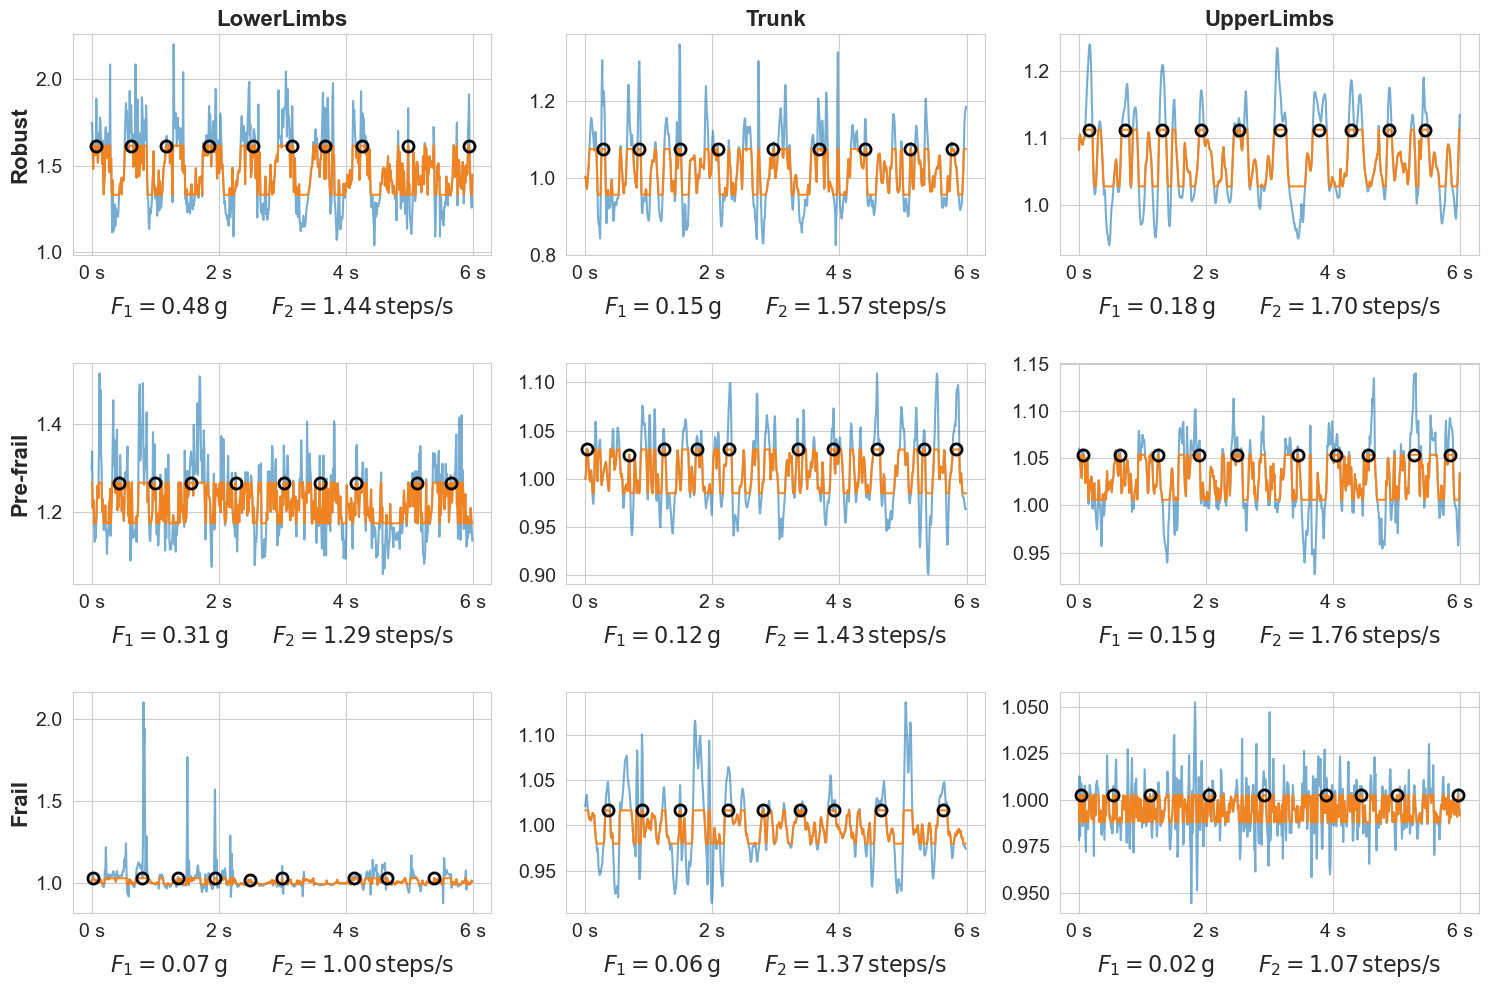

In [36]:
# Cell 25: Fig 2a – time‐domain (6s) curves with F1/F2 labels

import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.ticker import FuncFormatter

# 1) Feature‐value lookup for each (Class, Segment)
feature_vals = {
    ('Robust',    'LowerLimbs'): (0.48, 1.44),
    ('Robust',    'Trunk')      : (0.15, 1.57),
    ('Robust',    'UpperLimbs'): (0.18, 1.70),
    ('Pre-frail', 'LowerLimbs'): (0.31, 1.29),
    ('Pre-frail', 'Trunk')     : (0.12, 1.43),
    ('Pre-frail', 'UpperLimbs'): (0.15, 1.76),
    ('Frail',     'LowerLimbs'): (0.07, 1.00),
    ('Frail',     'Trunk')     : (0.06, 1.37),
    ('Frail',     'UpperLimbs'): (0.02, 1.07),
}

classes  = ['Robust','Pre-frail','Frail']
segments = ['LowerLimbs','Trunk','UpperLimbs']

# Optional: format x-ticks with "s"
s_formatter = FuncFormatter(lambda x, pos: f"{x:.0f} s")

fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=False, sharey=False)
for i, cls in enumerate(classes):
    for j, seg in enumerate(segments):
        ax = axes[i, j]
        df2 = ts[(cls, seg)]
        t, raw, trim = df2.t, df2.raw, df2.trim

        # plot raw & trimmed
        ax.plot(t, raw,  alpha=0.6)
        ax.plot(t, trim, alpha=0.9)

        # find & plot peaks
        peaks, _ = find_peaks(
            trim,
            distance=FS * 0.5,
            prominence=(trim.max() - trim.min()) * 0.3
        )
        ax.plot(
            t.iloc[peaks],
            trim.iloc[peaks],
            'o', mec='k', mfc='none',
            markersize=8, markeredgewidth=2
        )

        # titles & axis labels
        if i == 0:
            ax.set_title(seg, fontsize=16, fontweight='bold')
        if j == 0:
            ax.set_ylabel(cls, fontsize=16, fontweight='bold')
        #if i == 2:
        #    ax.set_xlabel('Time', fontsize=16)

        # x-axis ticks with "s"
        ax.xaxis.set_major_formatter(s_formatter)
        ax.set_xticks([0, 2, 4, 6])
        ax.tick_params(axis='both', labelsize=14)

        ax.grid(True)

        # 2) Add the F1/F2 label underneath
        f1, f2 = feature_vals[(cls, seg)]
        txt = rf"$F_1={f1:.2f}\,\mathrm{{g}}\quad\quad F_2={f2:.2f}\,\mathrm{{steps/s}}$"
        ax.text(
            0.5, -0.18, txt,
            ha='center', va='top',
            transform=ax.transAxes,
            fontsize=16
        )

plt.tight_layout(h_pad=2.5)   # leave room for the text labels
plt.savefig('images/acceleration_magnitude.png')
plt.show()


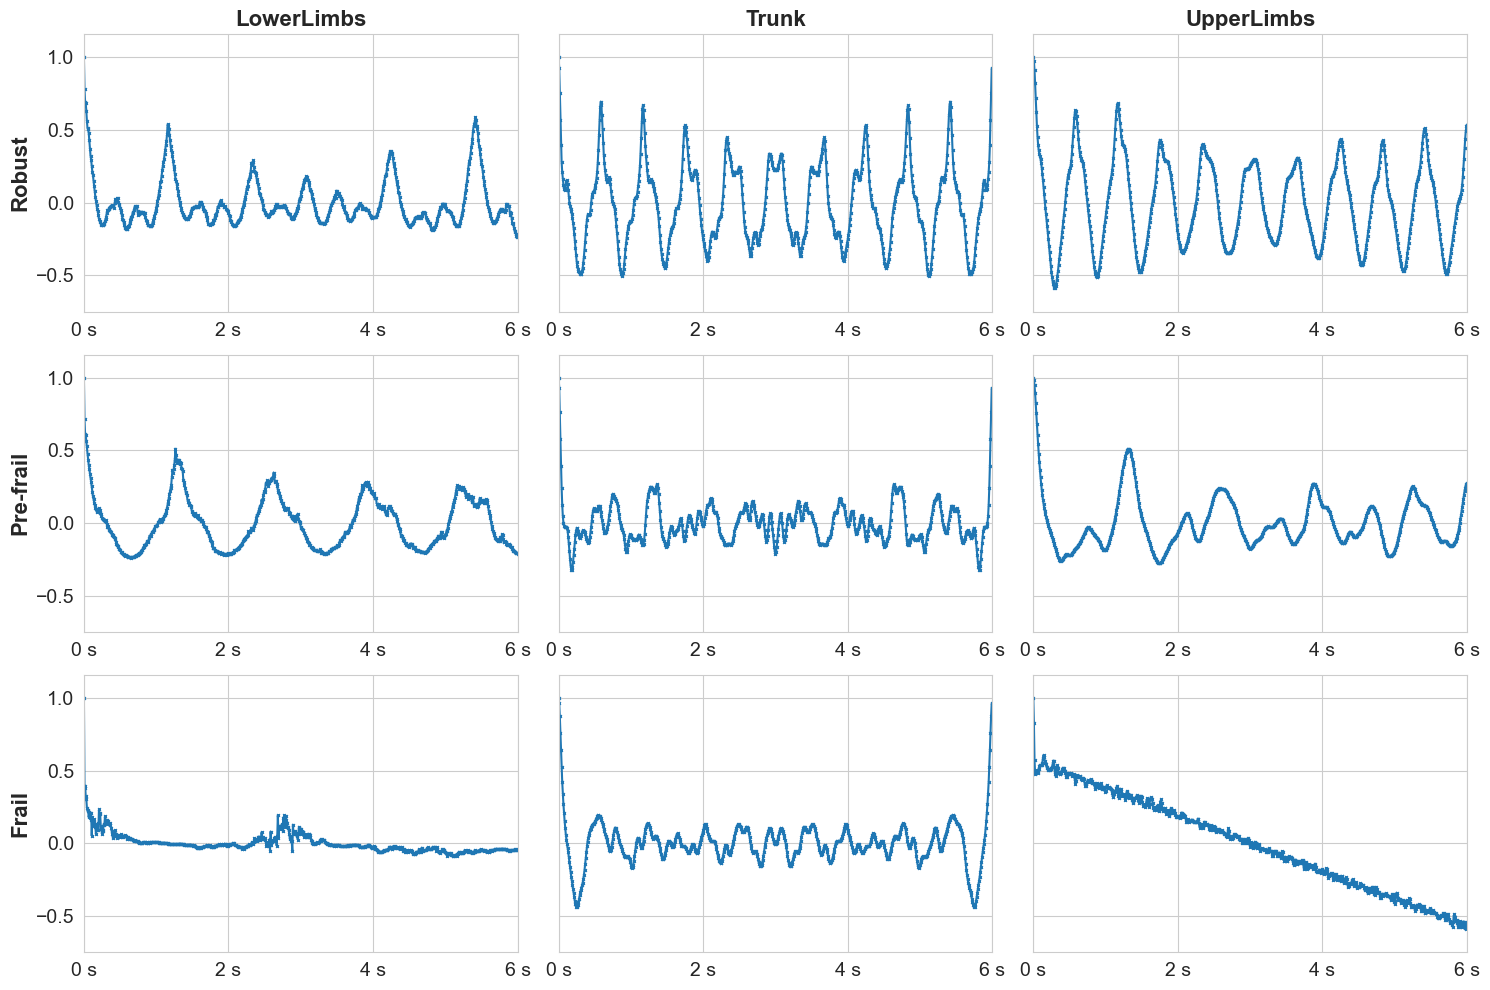

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.fft import fft, ifft

# Function to compute autocorrelation
def autocorr(x, maxlag=720):
    x0 = x - x.mean()
    R  = np.real(ifft(np.abs(fft(x0))**2))
    return (R / R[0])[:maxlag+1]

# Mapping: Class → (PatientID, Visit)
patient_map = {
    'Robust':    ('1',  'visit1'),
    'Pre-frail': ('6',  'visit1'),
    'Frail':     ('13', 'visit1'),
}

segments = ['LowerLimbs', 'Trunk', 'UpperLimbs']

# Format x-ticks with "s"
s_formatter = FuncFormatter(lambda x, pos: f"{x:.0f} s")

fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)

for i, (cls, (pid, visit)) in enumerate(patient_map.items()):
    for j, seg in enumerate(segments):
        ax = axes[i, j]

        # Define placements per segment
        placements = {
            'LowerLimbs': ['LF', 'RF'],
            'Trunk': ['SA'],
            'UpperLimbs': ['LW', 'RW']
        }[seg]

        # Filter the subset
        subset = master_windows[
            (master_windows.PatientID == pid) &
            (master_windows.Visit == visit) &
            (master_windows.Placement.isin(placements)) &
            (master_windows.WindowID == 6)
        ].copy()

        # Compute acceleration magnitude in g
        subset['Mag'] = np.sqrt(subset['Acc_X']**2 + subset['Acc_Y']**2 + subset['Acc_Z']**2) / 9.81
        a = subset.groupby(subset.index)['Mag'].mean()

        # Autocorrelation
        Rn = autocorr(a.values, maxlag=720)
        lags_s = np.arange(len(Rn)) / 120  # convert to seconds

        # Plot autocorrelation
        ax.plot(lags_s, Rn, '-x', markersize=2)
        ax.set_xlim(0, 6)
        ax.set_xticks([0, 2, 4, 6])
        ax.xaxis.set_major_formatter(s_formatter)
        ax.tick_params(axis='both', labelsize=14)  # match Code A
        ax.tick_params(labelbottom=True)

        # Add x-axis label only for the bottom row
        #if i == 2:
        #    ax.set_xlabel("Lag (s)", fontsize=14)

        # Y-axis limits
        margin = 0.1 * (Rn.max() - Rn.min())
        ax.set_ylim(Rn.min() - margin, Rn.max() + margin)

        # Titles and labels
        if i == 0:
            ax.set_title(seg, fontsize=16, fontweight='bold')
        if j == 0:
            ax.set_ylabel(cls, fontsize=16, fontweight='bold')

        ax.grid(True)

plt.tight_layout()
plt.savefig('images/autocorr_single.png')
plt.show()


## Violin plot

In [38]:
# %% Cell 27: Compute F1 per window x placement‐group

# 1) Map labels
df1 = master_labeled.copy()
df1['FrailtyGroup'] = df1['FFP'].map({0:'Robust', 1:'Pre-frail', 2:'Frail'})
df1['PlacementGroup'] = df1['Placement'].map({
    'LF':'LowerLimbs','RF':'LowerLimbs',
    'LW':'UpperLimbs','RW':'UpperLimbs',
    'SA':'Trunk'
})

# 2) Sum F1_intensity across placements within each window
window_sums1 = (
    df1
      .groupby([
          'PatientID','Visit','WindowID',
          'FrailtyGroup','PlacementGroup'
      ])['F3_periodicity']
      .sum()    # combines LF+RF or LW+RW, SA stays alone (F1, F3, F5, F6 -> mean; F2, F4 -> sum)
      .reset_index()
)

print(window_sums1.head())


  PatientID   Visit  WindowID FrailtyGroup PlacementGroup  F3_periodicity
0         1  visit1         0       Robust     LowerLimbs        0.165861
1         1  visit1         0       Robust          Trunk        0.135758
2         1  visit1         0       Robust     UpperLimbs        0.111141
3         1  visit1         1       Robust     LowerLimbs        0.056811
4         1  visit1         1       Robust          Trunk        0.265051


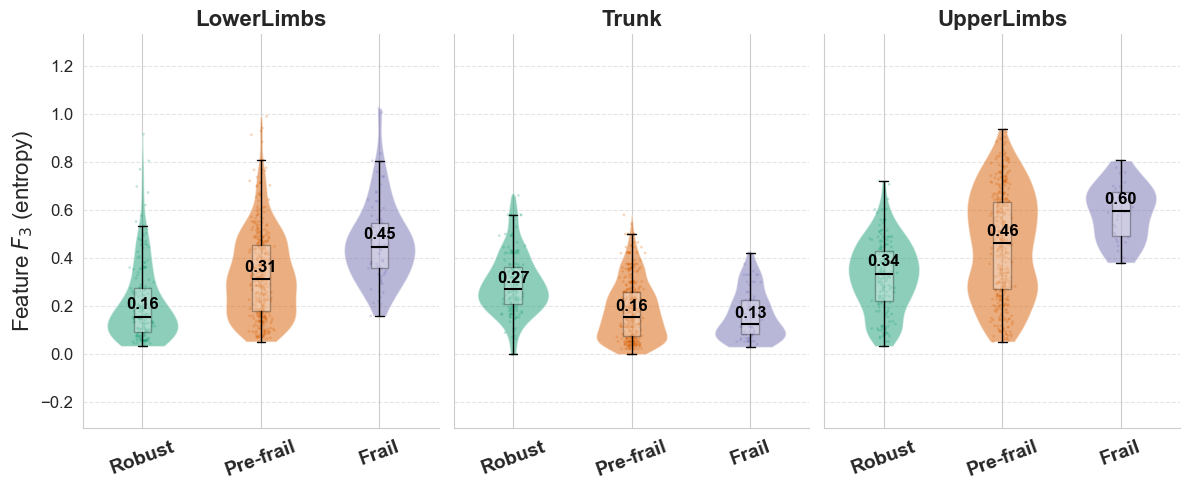

In [39]:
# Cell 28: Violin plot

from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


groups     = ['Robust','Pre-frail','Frail']
placements = ['LowerLimbs','Trunk','UpperLimbs']
#colors = ['#1f77b4', '#2ca02c', '#ff7f0e']      #F1
#colors = ['#d62728', '#9467bd', '#8c564b']      #F2
colors = ['#1b9e77', '#d95f02', '#7570b3']      #F3
#colors = ["#56B4E9", "#E69F00", "#009E73"]      #F4
#colors = ["#0072B2", "#D55E00", "#CC79A7"]      #F5
#colors = ["#66C2A5", "#FC8D62", "#8DA0CB"]      #F6

positions  = [1, 2, 3]

all_vals = window_sums1['F3_periodicity'].values     # one NumPy array
ymin, ymax = all_vals.min(), all_vals.max()
margin     = 0.30 * (ymax - ymin)                    # 10 % head-room
ymin, ymax = ymin - margin, ymax + margin


fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=False, sharey=True)

for ax, seg in zip(axes, placements):
    # 1) Gather data
    data = [
        window_sums1.loc[
            (window_sums1.PlacementGroup == seg) &
            (window_sums1.FrailtyGroup    == grp),
            'F3_periodicity'
        ].values
        for grp in groups
    ]

    # 2) Draw the plot
    vp = ax.violinplot(
        data,
        positions=positions,
        widths=0.6,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    for body, col in zip(vp['bodies'], colors):
        body.set_facecolor(col)
        body.set_alpha(0.5)

    # 3) Add graphics (boxplot on top)
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=0.15,
        patch_artist=True,
        showfliers=False,
        medianprops=dict(color='black', linewidth=1.5),
        boxprops=dict(facecolor='white', edgecolor='black', linewidth=1, alpha=0.3),
        whiskerprops=dict(color='black', linewidth=1),
        capprops=dict(color='black', linewidth=1)
    )

    # 4) Scatter the raw points
    for i, d in enumerate(data, start=1):
        x = np.random.normal(positions[i-1], 0.04, size=len(d))
        ax.scatter(x, d, s=4, color=colors[i-1], alpha=0.25, edgecolors='none')

    # 5) Annotate the median, 50th percentile, above each box
    all_vals = np.hstack(data)
    lo, hi   = all_vals.min(), all_vals.max()
    offset   = 0.02 * (hi - lo)
    for i, d in enumerate(data, start=1):
        med = np.median(d)
        ax.text(
            positions[i-1],       # x position
            med + offset,         # just above the median line
            f"{med:.2f}",         # formatted to 2 decimals
            ha='center', va='bottom',
            fontsize=12, fontweight='bold', color='black'
        )

    # 6) Auto‐scale Y to each subplot
    #margin = 0.1 * (hi - lo)
    #ax.set_ylim(lo - margin, hi + margin)

    ax.set_ylim(ymin, ymax)            # <- use the pre-computed limits
    ax.yaxis.set_major_locator(MaxNLocator(prune='lower'))

    # 7) Legend and graphic improvement
    ax.set_title(seg, fontsize=16, fontweight='bold')
    ax.set_xticks(positions)
    ax.set_xticklabels(groups, rotation=20, fontsize=14, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=12)

axes[0].set_ylabel(r'Feature $F_3$ (entropy)', fontsize=16)
#fig.suptitle('Fig 3 – Violin plot with quantile values of $F_2$',
#             y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig('images/F3.png')
plt.show()


## Step 7) Statistical Tests


In [40]:
# Cell 29: Import libraries for statistical tests

from scipy.stats import mannwhitneyu, kruskal
from skrebate import ReliefF
have_relief = True                      # for Statistical Tests

try:
    from skrebate import ReliefF
    have_relief = True
except ImportError:
    have_relief = False
    print("skrebate not installed.")

In [41]:
# Cell 30: Prepare DataFrame & Group Labels

df = master_labeled.copy()

df['FrailtyGroup'] = df['FFP'].map({0:'Robust', 1:'Pre-frail', 2:'Frail'})

features = [
    'F1_intensity',
    'F2_cadence',
    'F3_periodicity',
    'F4_dynamism'#,
    #'F5_ar_variability',
    #'F6_ar_kurtosis'
]

# sanity check
print("Groups & counts:")
print(df['FrailtyGroup'].value_counts(), '\n')
print("Features available:", features)

Groups & counts:
FrailtyGroup
Pre-frail    2067
Robust        880
Frail         301
Name: count, dtype: int64 

Features available: ['F1_intensity', 'F2_cadence', 'F3_periodicity', 'F4_dynamism']


In [42]:
# Cell 31: Pairwise Wilcoxon (Mann–Whitney U) & Kruskal–Wallis Tests

# define pairings and output column names
pairs = [
    ('Robust',   'Pre-frail', 'p_Robust_vs_Pre-frail'),
    ('Robust',   'Frail',      'p_Robust_vs_Frail'),
    ('Pre-frail','Frail',      'p_Pre-frail_vs_Frail'),
]

rows = []
for feat in features:
    g = {
        grp: df.loc[df.FrailtyGroup==grp, feat].dropna()
        for grp in ['Robust','Pre-frail','Frail']
    }
    row = {'Feature': feat}
    # pairwise tests
    for A, B, col in pairs:
        stat, p = mannwhitneyu(g[A], g[B], alternative='two-sided')
        row[col] = p
    # Kruskal–Wallis across all three
    stat, p_all = kruskal(g['Robust'], g['Pre-frail'], g['Frail'])
    row['p_Kruskal-Wallis'] = p_all
    rows.append(row)

stats_df = pd.DataFrame(rows).set_index('Feature')
stats_df


,p_Robust_vs_Pre-frail,p_Robust_vs_Frail,p_Pre-frail_vs_Frail,p_Kruskal-Wallis
Feature,,,,
F1_intensity,4.932034e-20,5.113584e-83,1.516303e-71,5.493319e-97
F2_cadence,1.733543e-02,2.397293e-28,2.160614e-22,1.370799e-26
F3_periodicity,6.347754e-09,2.453295e-15,1.190428e-06,4.680195e-16
F4_dynamism,1.661517e-06,2.662515e-40,1.198914e-63,4.302023e-64


In [43]:
# Cell 32: Format p-values & Display Table 1

def mark_p(p):
    if p < 0.001: return '< 0.001'
    elif p < 0.01: return '< 0.01'
    elif p < 0.05: return '< 0.05'
    else:           return '≥ 0.05'

# formatting
out = stats_df.copy()
for col in stats_df.columns:
    out[col] = out[col].map(mark_p)

print("Table 1 – Wilcoxon & Kruskal–Wallis p-values")
out

Table 1 – Wilcoxon & Kruskal–Wallis p-values


,p_Robust_vs_Pre-frail,p_Robust_vs_Frail,p_Pre-frail_vs_Frail,p_Kruskal-Wallis
Feature,,,,
F1_intensity,< 0.001,< 0.001,< 0.001,< 0.001
F2_cadence,< 0.05,< 0.001,< 0.001,< 0.001
F3_periodicity,< 0.001,< 0.001,< 0.001,< 0.001
F4_dynamism,< 0.001,< 0.001,< 0.001,< 0.001


In [44]:
# Cell 33: ReliefF Feature Ranking & Display Table 2

if have_relief:
    # 1) fit ReliefF
    X = df[features].to_numpy()
    y = df['FFP'].to_numpy()
    rel = ReliefF(n_neighbors=5)
    rel.fit(X, y)
    scores = rel.feature_importances_

    # 2) build DataFrame
    relief_df = pd.DataFrame({
        'ReliefF_score': scores
    }, index=features)

    # 3) compute ranks (1 = highest score)
    relief_df['ReliefF_rank'] = (
        relief_df['ReliefF_score']
        .rank(method='dense', ascending=False)
        .astype(int)
    )

    # 4) sort by feature name and display
    relief_df = relief_df.sort_index()
    print("\nReliefF feature importance & rank (ordered by Feature):\n")
    print(relief_df.to_string())
else:
    print("Skipping ReliefF (skrebate not installed).")



ReliefF feature importance & rank (ordered by Feature):

                ReliefF_score  ReliefF_rank
F1_intensity         0.036167             2
F2_cadence           0.029229             3
F3_periodicity       0.015128             4
F4_dynamism          0.056883             1


## Step 8) PCA analysis

#### hat_F6 (curtosis of AR coefficients) is not significant, hence it is dropped from PCA

#### patient imu 0011 is problematic because no measure ara available for him for the uppper limbs (Left wrist and Right wrist).
#### Also, his FAC is 2, in between frail and semi-frail

In [45]:
# Cell 34 PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [46]:
# Mappings
REGION_MAP = {
    'Lower Limbs (Left and right feet)': ['LF','RF'],
    'Upper Limbs (Left and right wrists)': ['LW','RW'],
    'Trunk (Sacrum)':            ['SA']
}

AGG_FEATS = [
    'F1_intensity',
    'F2_cadence',
    'F3_periodicity',
    'F4_dynamism'#,
    #'F5_ar_variability'
]

MARKER_MAP = {'visit1': 'circle', 'visit2': 'diamond'}
FFP_LABELS = {0: 'Robust', 1: 'Semi-frail', 2: 'Frail'}

In [47]:
# Helper functions
def hull_to_mesh3d(pts, color, opacity=0.15):
    # Convex-hull cloud graph
    hull = ConvexHull(pts)
    i, j, k = hull.simplices.T
    return go.Mesh3d(
        x=pts[:, 0], y=pts[:, 1], z=pts[:, 2],
        i=i, j=j, k=k,
        color=color, opacity=opacity,
        hoverinfo='skip', showscale=False
    )

def get_color_map(column, label_map=None):
    # legend and colour map
    vals = sorted(master_labeled[column].unique())
    palette = px.colors.qualitative.Set1
    col_map  = {v: palette[i % len(palette)] for i, v in enumerate(vals)}

    if label_map:                                 # explicit mapping for FAC
        name_map = {v: label_map[v] for v in vals}
    elif column == 'FAC':
        name_map = {v: f'FAC {v}' for v in vals}
    else:                                         # fall-back to raw value if not found
        name_map = {v: str(v) for v in vals}
    return col_map, name_map

def print_centroids(pca_dict, color_by, name_map):
    # print a table for the centroids
    # pca_dict : {region-> dataframe with PC1-PC3 + color_by col}
    rows = []
    for region, df in pca_dict.items():
        for val in sorted(df[color_by].unique()):
            ctr = df[df[color_by] == val][['PC1', 'PC2', 'PC3']].mean()
            rows.append({
                'Region'   : region,
                color_by   : name_map[val],
                'PC1_ctr'  : ctr.PC1,
                'PC2_ctr'  : ctr.PC2,
                'PC3_ctr'  : ctr.PC3
            })
    ct = (pd.DataFrame(rows)
            .sort_values(['Region', color_by])
            .reset_index(drop=True))
    print("\nCentroids (mean PC scores)")
    print(ct.to_string(index=False, float_format="%.3f"))

In [48]:
# # 1) Window level PCA (each window: 720 samples & 3D plot)
# def window_level_pca(color_by='FAC', *, show_hull=True, show_lines=True):
#     # color_by   : 'FAC' | 'FFP'
#     # show_hull  : draw convex hulls for each class
#     # show_lines : draw gray connectors between visit1 and visit2 for a patient
#
#     col_map, name_map = get_color_map(
#         color_by, label_map=(FFP_LABELS if color_by == 'FFP' else None))
#
#     # summary-table header
#     print(f"{'Region':<25} {'n_windows':>9}   {'PC1':>6}   {'PC2':>6}   "
#           f"{'PC3':>6}   {'ΣPC1-3':>7}")
#     print("-"*63)
#
#     pca_out = {}
#     for region, codes in REGION_MAP.items():
#         df_r = master_labeled[master_labeled['Placement'].isin(codes)].copy()
#         n = len(df_r)
#         X = df_r[AGG_FEATS].fillna(0).values
#         pcs   = PCA(n_components=3).fit_transform(X)
#         vr    = PCA(n_components=3).fit(X).explained_variance_ratio_
#         total = vr.sum()
#         print(f"{region:<25} {n:>9}   {vr[0]:>6.3f}   {vr[1]:>6.3f}   "
#               f"{vr[2]:>6.3f}   {total:>7.3f}")
#         df_r[['PC1', 'PC2', 'PC3']] = pcs
#         pca_out[region] = df_r
#
#     # centroid table
#     print_centroids(pca_out, color_by, name_map)
#
#     # interactive 3D plot
#     fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'scene'}]*3],
#                         subplot_titles=list(pca_out.keys()))
#     for ci, (region, df_r) in enumerate(pca_out.items(), start=1):
#         if show_hull:
#             for val, color in col_map.items():
#                 pts = df_r[df_r[color_by] == val][['PC1', 'PC2', 'PC3']].values
#                 if len(pts) >= 4:
#                     fig.add_trace(hull_to_mesh3d(pts, color), row=1, col=ci)
#
#         # patient connectors between visits
#         if show_lines:
#             for pid, grp in df_r.groupby('PatientID'):
#                 if {'visit1', 'visit2'} <= set(grp['Visit']):
#                     fig.add_trace(go.Scatter3d(
#                         x=grp.PC1, y=grp.PC2, z=grp.PC3,
#                         mode='lines',
#                         line=dict(color='gray', width=1),
#                         hoverinfo='skip', showlegend=False
#                     ), row=1, col=ci)
#
#         # scatter points for each visit
#         for visit, sym in MARKER_MAP.items():
#             sel = df_r[df_r['Visit'] == visit]
#             fig.add_trace(go.Scatter3d(
#                 x=sel.PC1, y=sel.PC2, z=sel.PC3,
#                 mode='markers+text',
#                 marker=dict(symbol=sym, size=5,
#                             color=[col_map[v] for v in sel[color_by]],
#                             line=dict(width=0.5, color='black'), opacity=0.8),
#                 text=sel['PatientID'], textposition='middle center',
#                 textfont=dict(size=8),
#                 name=visit, legendgroup=visit,
#                 showlegend=(ci == 3)
#             ), row=1, col=ci)
#
#     fig.update_layout(
#         height=600, width=1200,
#         title_text=f'Interactive 3-D PCA by Region '
#                    f'(hat-features, colored by {color_by})',
#         legend=dict(title=color_by, x=1.05, y=0.9)
#     )
#     # dummy traces for legend (FAC / FFP levels)
#     for val, color in col_map.items():
#         fig.add_trace(go.Scatter3d(
#             x=[None], y=[None], z=[None],
#             mode='markers',
#             marker=dict(size=8, color=color),
#             name=name_map[val], legendgroup=str(val)
#         ))
#     for scene in ['scene', 'scene2', 'scene3']:
#         fig.layout[scene].update(
#             xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'
#         )
#     fig.show()

In [49]:
# -------------------------------------------------------------------------
# Stand-alone 3-D PCA plots (one per region)
# -------------------------------------------------------------------------
from sklearn.decomposition import PCA
import plotly.graph_objects as go

def window_level_pca(color_by='FAC', *, show_hull=True, show_lines=True):
    """
    Render a separate interactive 3-D PCA plot for each body region.
    Parameters
    ----------
    color_by   : {'FAC', 'FFP'}
        Column used for colouring points.
    show_hull  : bool, optional
        Draw convex hull around each colour class if True.
    show_lines : bool, optional
        Draw grey line linking visit-1 and visit-2 of the same patient.
    """

    # ------------------------------------------------------------------
    # 0) utilities
    # ------------------------------------------------------------------
    col_map, name_map = get_color_map(
        color_by, label_map=(FFP_LABELS if color_by == 'FFP' else None)
    )

    # ------------------------------------------------------------------
    # 1) compute PCA for every region; store in pca_out
    # ------------------------------------------------------------------
    pca_out = {}                                     # {region: df_with_PC1-3}
    for region, codes in REGION_MAP.items():
        df_r = master_labeled[master_labeled['Placement'].isin(codes)].copy()
        X    = df_r[AGG_FEATS].fillna(0).values
        pcs  = PCA(n_components=3).fit_transform(X)
        df_r[['PC1', 'PC2', 'PC3']] = pcs
        pca_out[region] = df_r

    # optional logging (kept from your original version)
    print("\nCentroids (mean PC scores)")
    print_centroids(pca_out, color_by, name_map)

    # ------------------------------------------------------------------
    # 2) build ONE figure per region
    # ------------------------------------------------------------------
    for region, df_r in pca_out.items():

        fig = go.Figure()

        # (i) convex hulls
        if show_hull:
            for val, color in col_map.items():
                pts = df_r[df_r[color_by] == val][['PC1', 'PC2', 'PC3']].values
                if len(pts) >= 4:                       # hull needs ≥ 4 points
                    fig.add_trace(hull_to_mesh3d(pts, color))

        # (ii) connectors visit-1 → visit-2
        if show_lines:
            for pid, grp in df_r.groupby('PatientID'):
                if {'visit1', 'visit2'}.issubset(grp['Visit']):
                    fig.add_trace(go.Scatter3d(
                        x=grp.PC1, y=grp.PC2, z=grp.PC3,
                        mode='lines',
                        line=dict(color='gray', width=1),
                        hoverinfo='skip', showlegend=False
                    ))

        # (iii) scatter markers
        for visit, sym in MARKER_MAP.items():
            sel = df_r[df_r['Visit'] == visit]
            fig.add_trace(go.Scatter3d(
                x=sel.PC1, y=sel.PC2, z=sel.PC3,
                mode='markers',
                marker=dict(
                    symbol=sym, size=5,
                    color=[col_map[v] for v in sel[color_by]],
                    line=dict(width=0.5, color='black'),
                    opacity=0.8
                ),
                hovertext=sel['PatientID'],
                text=sel['PatientID'],
                textfont=dict(size=8),
                name=visit, legendgroup=visit
            ))

        # (iv) dummy traces so colour classes appear in the legend
        for val, color in col_map.items():
            fig.add_trace(go.Scatter3d(
                x=[None], y=[None], z=[None],
                mode='markers',
                marker=dict(size=8, color=color),
                name=name_map[val], legendgroup=str(val)
            ))

        # (v) layout
        fig.update_layout(
            title=dict(
                text=f'{region} — {color_by}',
                x=0.5,                # 0 = left, 0.5 = centre, 1 = right
                xanchor='center',
                y=0.96,               # slight gap from top edge
                yanchor='top',
                font=dict(size=22)    # adjust size if needed
            ),
            scene=dict(
                xaxis_title='PC1',
                yaxis_title='PC2',
                zaxis_title='PC3'
            ),
             legend=dict(
                title=color_by,
                x=0.82,           # 0 = left edge of plotting area
                y=0.50,           # 1 = top edge
                xanchor='left',
                yanchor='top',
                bgcolor='rgba(255,255,255,0.75)',   # translucent white box
                bordercolor='gray',
                borderwidth=0.5
            ),
            height=600, width=700
        )

        fig.show()   # render this region’s plot before moving on


In [50]:
#3) Show

#Flags to see/hide
#window_level_pca('FAC',  show_hull=False, show_lines=False)   # FAC plot
#window_level_pca('FFP',  show_hull=False, show_lines=False)   # FFP plot

In [51]:
# ---------------------------------------------------------------
# Variance explained by the first three PCs for every placement
# ---------------------------------------------------------------
from sklearn.decomposition import PCA
import pandas as pd

def pca_variance_by_region(df, features=AGG_FEATS):
    """
    Compute the proportion of variance explained by PC1–PC3
    for each body placement defined in REGION_MAP.

    Parameters
    ----------
    df        : pandas.DataFrame
        Master table that contains the raw windows and a
        'Placement' column with codes such as LF, RF, LW, …
    features  : list[str]
        Columns on which PCA is fitted (defaults to AGG_FEATS).

    Returns
    -------
    pandas.DataFrame
        Index = region name, columns = PC1, PC2, PC3, Cumulative.
        Numbers are expressed as percentages.
    """
    rows = []
    for region, codes in REGION_MAP.items():
        X = (df[df['Placement'].isin(codes)][features]
             .fillna(0)
             .values)
        vr = PCA(n_components=3, random_state=0).fit(X).explained_variance_ratio_
        rows.append({
            'Region'      : region,
            'PC1 (%)'     : vr[0] * 100,
            'PC2 (%)'     : vr[1] * 100,
            'PC3 (%)'     : vr[2] * 100,
            'Cum (%)'     : vr.sum() * 100
        })

    return (pd.DataFrame(rows)
              .set_index('Region')
              .round(2))

# ---------------------------------------------------------------
# Example usage
# ---------------------------------------------------------------
var_table = pca_variance_by_region(master_labeled)
print(var_table.to_string())


                                     PC1 (%)  PC2 (%)  PC3 (%)  Cum (%)
Region                                                                 
Lower Limbs (Left and right feet)      80.12    11.99     6.62    98.73
Upper Limbs (Left and right wrists)    53.96    26.40    14.72    95.09
Trunk (Sacrum)                         68.68    18.79    11.67    99.15


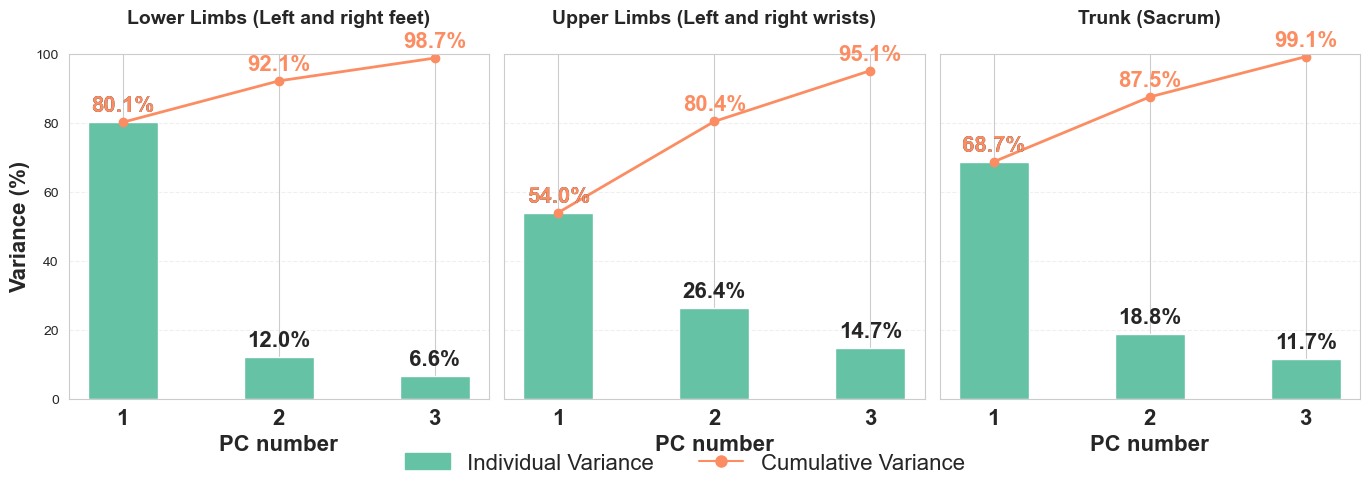

In [52]:
def plot_variance_by_region(var_table):
    """
    Bar + line chart of PC1–PC3 variance for every body region.
    Tick labels “1 2 3” on the x-axis, axis labels, and percentage
    annotations are all 16 pt and bold; legend text is 16 pt.
    """
    bar_col  = '#66c2a5'
    line_col = '#fc8d62'

    regions = var_table.index
    n_reg   = len(regions)
    fig, axes = plt.subplots(1, n_reg, figsize=(4.6 * n_reg, 5), sharey=True)
    if n_reg == 1:                      # keep iterable for single panel
        axes = [axes]

    for ax, region in zip(axes, regions):
        vals = var_table.loc[region][['PC1 (%)', 'PC2 (%)', 'PC3 (%)']].values
        cum  = np.cumsum(vals)
        x    = np.arange(1, 4)

        # ── bars + line ───────────────────────────────────────────────
        ax.bar(x, vals, width=0.45, color=bar_col, edgecolor='white')
        ax.plot(x, cum, '-o', color=line_col, linewidth=2)

        # ── value labels ──────────────────────────────────────────────
        for xi, v in zip(x, vals):
            ax.text(xi, v + 2, f'{v:.1f}%', ha='center', va='bottom',
                    fontsize=16, fontweight='bold')
        for xi, c in zip(x, cum):
            ax.text(xi, c + 2, f'{c:.1f}%', ha='center', va='bottom',
                    color=line_col, fontsize=16, fontweight='bold')

        # ── axis / title styling ──────────────────────────────────────
        ax.set_xticks(x)
        ax.set_xticklabels([1, 2, 3], fontsize=16, fontweight='bold')  # ← NEW
        ax.set_xlabel('PC number', fontsize=16, fontweight='bold')
        ax.set_title(region, fontsize=14, fontweight='bold', pad=22)    # raised
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        ax.set_ylim(0, 100)

    axes[0].set_ylabel('Variance (%)', fontsize=16, fontweight='bold')

    # ── legend (larger text) ──────────────────────────────────────────
    handles = [
        Patch(color=bar_col, label='Individual Variance'),
        Line2D([0], [0], color=line_col, marker='o',
               markersize=8, label='Cumulative Variance')
    ]
    fig.legend(handles=handles, ncol=2, loc='lower center',
               frameon=False, fontsize=16)

    #fig.suptitle('PCA variance explained by component (per body region)',
    #             fontsize=16, y=1.02)

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig("images/pca_variance.png")
    plt.show()


# -------------------------------------------------------------------
# example call
# -------------------------------------------------------------------
var_table = pca_variance_by_region(master_labeled)
plot_variance_by_region(var_table)


## Step 9) Classifying frailty

#### check imbalance

In [53]:
master_labeled['FAC'].value_counts()


FAC
4    1687
5     880
3     380
1     175
2     126
Name: count, dtype: int64

In [54]:
master_labeled['FFP'].value_counts()


FFP
1    2067
0     880
2     301
Name: count, dtype: int64

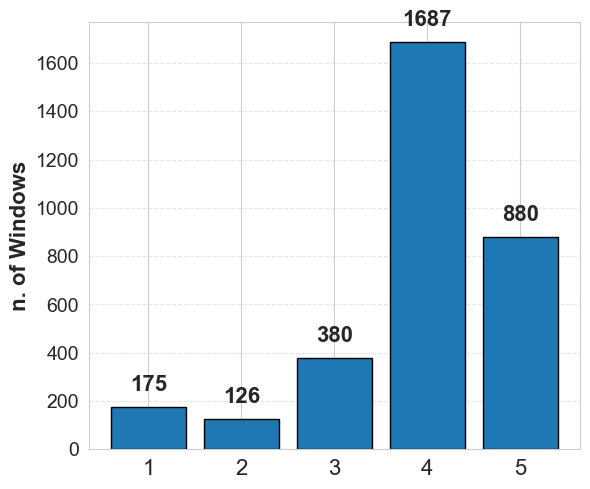

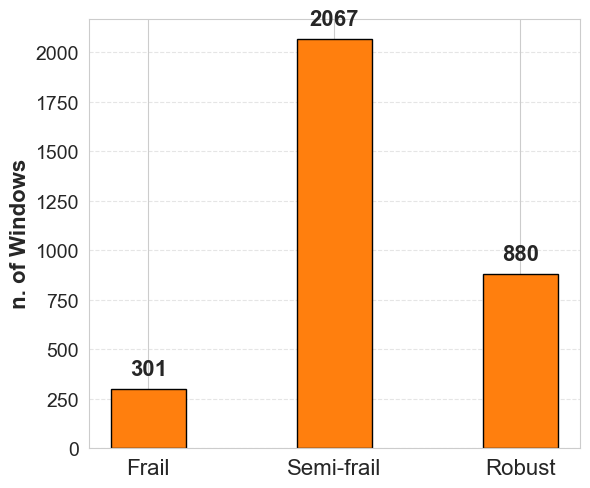

In [55]:
import matplotlib.pyplot as plt

# Count class occurrences
fac_counts = master_labeled['FAC'].value_counts().sort_index()
ffp_counts = master_labeled['FFP'].value_counts().sort_index().reindex([2, 1, 0])

# 1. Plot FAC Distribution
plt.figure(figsize=(6, 5))
bars = plt.bar(fac_counts.index.astype(str), fac_counts.values, color='#1f77b4', edgecolor='black')
plt.ylabel("n. of Windows", fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)

# Add text above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50, str(height),
             ha='center', va='bottom', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig("images/fac_class_distribution.png")
plt.show()

# 2. Plot FFP Distribution with slimmer bars
ffp_labels = {2: "Frail", 1: "Semi-frail", 0: "Robust"}
ffp_classes = [ffp_labels[i] for i in ffp_counts.index]

plt.figure(figsize=(6, 5))
bars = plt.bar(ffp_classes, ffp_counts.values, width=0.4, color='#ff7f0e', edgecolor='black')  # narrower bars
plt.ylabel("n. of Windows", fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)

# Add text above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50, str(height),
             ha='center', va='bottom', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig("images/ffp_class_distribution.png")
plt.show()


⏳ Training – SMOTE + classifier hyper-parameters

=== Hyper-parameter optimisation summary ===

Decision Tree
‾‾‾‾‾‾‾‾‾‾‾‾‾
  • best F1(cv): 0.5776
  • SMOTE parameters
     – sampling_strategy : not majority
     – k_neighbors       : 7
  • Classifier parameters
     – min_samples_split : 10
     – min_samples_leaf  : 2
     – max_depth         : 30
     – criterion         : entropy

Random Forest
‾‾‾‾‾‾‾‾‾‾‾‾‾
  • best F1(cv): 0.6244
  • SMOTE parameters
     – k_neighbors       : 3
     – sampling_strategy : not majority
  • Classifier parameters
     – max_depth         : 25
     – max_features      : sqrt
     – min_samples_leaf  : 1
     – min_samples_split : 4
     – n_estimators      : 429

Gradient Boosting
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
  • best F1(cv): 0.6174
  • SMOTE parameters
     – k_neighbors       : 5
     – sampling_strategy : not majority
  • Classifier parameters
     – learning_rate     : 0.03198617182203562
     – max_depth         : 6
     – min_samples_leaf  : 1
     – min

,Accuracy,Precision_macro,Recall_macro,F1_macro,Specificity_macro,ROC_AUC_macro
Decision Tree,0.6246,0.5644,0.6775,0.6008,0.8895,0.8250
Random Forest,0.6646,0.6005,0.7058,0.6362,0.9000,0.9007
Gradient Boosting,0.6415,0.5792,0.6908,0.6150,0.8953,0.8899
Logistic Regression,0.4354,0.3976,0.5948,0.4042,0.8548,0.7633
SVM (RBF),0.6031,0.5230,0.6593,0.5641,0.8893,0.8737
MLP Neural Net,0.6400,0.5652,0.6860,0.6030,0.8996,0.8964


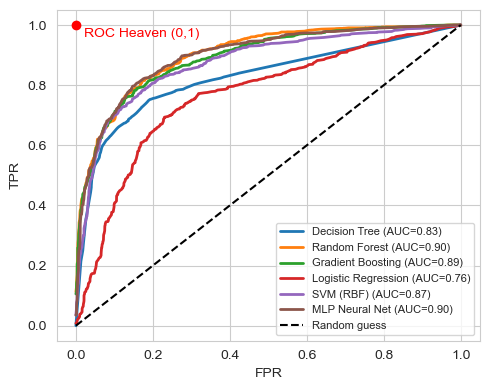

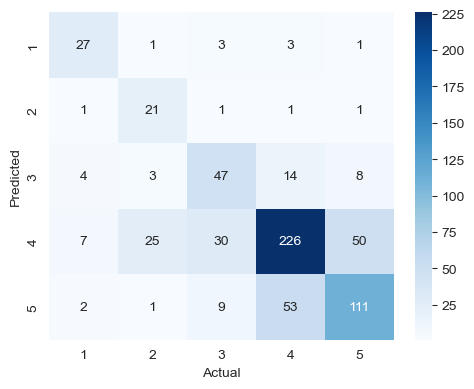

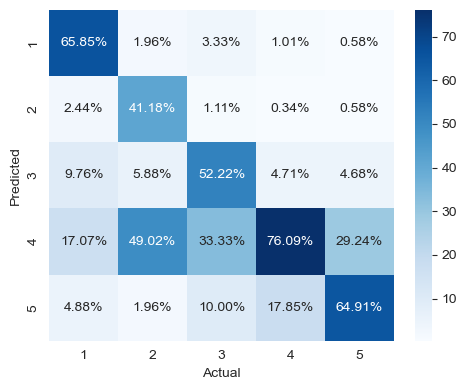


=== Patient-level FAC by visit (Random Forest) ===


,PatientID,median_pred_FAC_visit1,median_true_FAC_visit1,median_pred_FAC_visit2,median_true_FAC_visit2,diff_pred,diff_true,improved_pred,improved_true
0,1,5.000000,5.000000,4.500000,5.000000,-0.500000,0.000000,False,False
1,11,2.000000,2.000000,4.000000,4.000000,2.000000,2.000000,True,True
2,12,4.000000,4.000000,5.000000,5.000000,1.000000,1.000000,True,True
3,13,1.000000,1.000000,3.000000,3.000000,2.000000,2.000000,True,True
4,2,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,False,False
5,3,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,False,False
6,6,3.000000,3.000000,4.000000,4.000000,1.000000,1.000000,True,True
7,7,4.000000,4.000000,4.000000,4.000000,0.000000,0.000000,False,False
8,8,4.000000,4.000000,4.000000,4.000000,0.000000,0.000000,False,False
9,9,4.000000,4.000000,4.000000,4.000000,0.000000,0.000000,False,False



=== Patient × Placement FAC (Random Forest) ===

=== Patient × Placement FAC (Random Forest) ===


,PatientID,Placement,median_pred_FAC_visit1,median_true_FAC_visit1,median_pred_FAC_visit2,median_true_FAC_visit2,diff,improved_pred,improved_true
0,1,LF,5.000000,5.000000,4.000000,5.000000,-1.000000,False,False
1,1,LW,5.000000,5.000000,5.000000,5.000000,0.000000,False,False
2,1,RF,4.000000,5.000000,5.000000,5.000000,1.000000,True,False
3,1,RW,5.000000,5.000000,4.000000,5.000000,-1.000000,False,False
4,11,LF,2.000000,2.000000,4.000000,4.000000,2.000000,True,True
5,11,RF,2.000000,2.000000,4.000000,4.000000,2.000000,True,True
6,11,SA,2.000000,2.000000,5.000000,4.000000,3.000000,True,True
7,12,LF,4.000000,4.000000,5.000000,5.000000,1.000000,True,True
8,12,LW,5.000000,4.000000,5.000000,5.000000,0.000000,False,True
9,12,RF,4.000000,4.000000,4.000000,5.000000,0.000000,False,True



=== Performance summary (FFP-from-FAC – window level) ===


,Accuracy_macro,Precision_macro,Recall_macro,F1_macro,Specificity_macro,ROC_AUC_macro
Decision Tree,0.6954,0.6309,0.7118,0.6582,0.8097,0.8068
Random Forest,0.7354,0.6706,0.7432,0.6964,0.8352,0.8816
Gradient Boosting,0.7154,0.6504,0.7364,0.6795,0.8268,0.8749
Logistic Regression,0.5431,0.5522,0.6966,0.5267,0.7938,0.7603
SVM (RBF),0.6892,0.6178,0.7089,0.6446,0.8159,0.8569
MLP Neural Net,0.7123,0.6438,0.7260,0.6724,0.8296,0.8767


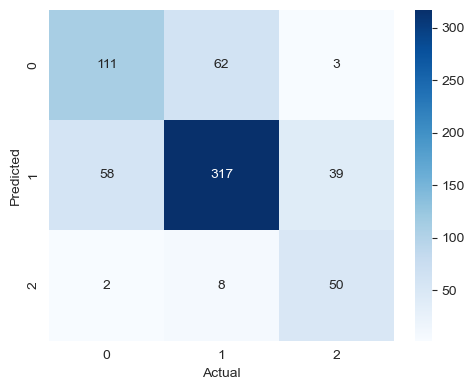

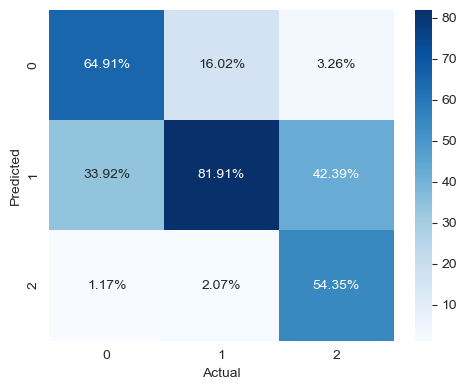

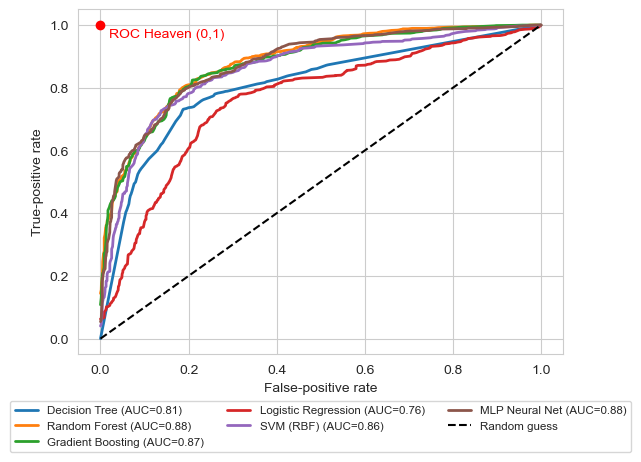

In [56]:
# %% Cell 35 – Machine-learning models 𝐰𝐢𝐭𝐡 SMOTE tuning + verbose report
# =========================================================================
from imblearn.pipeline      import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import (StratifiedKFold, RandomizedSearchCV,
                                     train_test_split)
from sklearn.ensemble        import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neural_network  import MLPClassifier
from sklearn.preprocessing   import label_binarize
from sklearn.metrics         import (accuracy_score, precision_score, recall_score,
                                     f1_score, roc_auc_score, roc_curve,
                                     confusion_matrix, auc)
from scipy.stats             import randint, loguniform

import numpy as np, pandas as pd, re, warnings, seaborn as sns, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ───────────────────────────────────────────────────────────────
# 1)  Data preparation  (unchanged)
# ───────────────────────────────────────────────────────────────
df = master_labeled.copy()
hat_feats = ['F1_intensity','F2_cadence','F3_periodicity',
             'F4_dynamism']#,'F5_ar_variability']

X_pl = pd.get_dummies(df['Placement'], prefix='PL', dtype=int)
X    = pd.concat([df[hat_feats], X_pl], axis=1).values
y_fac = df['FAC'].astype(int).values
meta  = df[['WindowID','PatientID','Visit','Placement','FAC','FFP']]

X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X, y_fac, meta, test_size=0.20, stratify=y_fac, random_state=42
)

# ───────────────────────────────────────────────────────────────
# 2)  CV + helper utilities
# ───────────────────────────────────────────────────────────────
cv      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'f1_macro'

# 2-a)  SMOTE search-space (legal for multi-class)
SMOTE_GRID = {
    'smote__k_neighbors'       : [3, 5, 7],
    'smote__sampling_strategy' : ['auto', 'not majority']
}

def prefix_grid(grid, prefix="clf__"):
    """Prefix every classifier hyper-parameter (dict or list-of-dicts)."""
    if isinstance(grid, list):
        return [{f"{prefix}{k}": v for k, v in g.items()} for g in grid]
    return {f"{prefix}{k}": v for k, v in grid.items()}

def merge_with_smote(grid):
    """Append SMOTE parameters to the (already prefixed) grid."""
    if isinstance(grid, list):
        return [{**g, **SMOTE_GRID} for g in grid]
    return {**grid, **SMOTE_GRID}

def make_search(base_estimator, param_grid, n_iter):
    pipe = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf',   base_estimator)
    ])
    full_grid = merge_with_smote(prefix_grid(param_grid))
    return RandomizedSearchCV(
        pipe, param_distributions=full_grid,
        n_iter=n_iter, cv=cv, scoring=scoring,
        random_state=42, n_jobs=-1, verbose=0
    )

# ───────────────────────────────────────────────────────────────
# 3)  Define the six Randomised searches  (classifier grids unchanged)
# ───────────────────────────────────────────────────────────────
searches = {
    "Decision Tree": make_search(
        DecisionTreeClassifier(random_state=42),
        dict(criterion=['gini','entropy'],
             max_depth=[None,5,10,20,30],
             min_samples_split=[2,5,10],
             min_samples_leaf=[1,2,5]),
        n_iter=20
    ),

    "Random Forest": make_search(
        RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=None),
        dict(n_estimators=randint(300,900),
             max_depth=[None]+list(range(10,41,5)),
             min_samples_split=randint(2,15),
             min_samples_leaf=randint(1,10),
             max_features=['sqrt','log2',None]),
        n_iter=80
    ),

    "Gradient Boosting": make_search(
        GradientBoostingClassifier(random_state=42),
        dict(n_estimators=randint(50,400),
             learning_rate=loguniform(1e-3,3e-1),
             max_depth=randint(2,8),
             subsample=[0.6,0.8,1.0],
             min_samples_split=randint(2,15),
             min_samples_leaf=randint(1,8)),
        n_iter=60
    ),

    "Logistic Regression": make_search(
        LogisticRegression(solver='saga', max_iter=4000, random_state=42,
                           class_weight=None),
        [
            {'penalty':['l2'],         'C':loguniform(1e-2,1e2)},
            {'penalty':['l1'],         'C':loguniform(1e-2,1e2)},
            {'penalty':['elasticnet'], 'C':loguniform(1e-2,1e2),
                                        'l1_ratio':np.linspace(0.1,0.9,9)}
        ],
        n_iter=60
    ),

    "SVM (RBF)": make_search(
        SVC(kernel='rbf', probability=True, random_state=42,
            class_weight=None),
        dict(C=loguniform(1e-2,1e3),
             gamma=loguniform(1e-4,1e1)),
        n_iter=80
    ),

    "MLP Neural Net": make_search(
        MLPClassifier(early_stopping=True, n_iter_no_change=20,
                      max_iter=1200, random_state=42),
        dict(hidden_layer_sizes=[(256,),(128,),(128,64),(128,64,32),(64,32)],
             activation=['relu','tanh'],
             alpha=loguniform(1e-5,1e-2),
             learning_rate_init=loguniform(2e-4,1e-2),
             batch_size=[32,64,128]),
        n_iter=80
    )
}

# ───────────────────────────────────────────────────────────────
# 4)  Train all searches
# ───────────────────────────────────────────────────────────────
print("⏳ Training – SMOTE + classifier hyper-parameters")
for s in searches.values():
    s.fit(X_train, y_train)

# ───────────────────────────────────────────────────────────────
# 5)  Verbose optimisation report  (SMOTE + classifier params)
# ───────────────────────────────────────────────────────────────
print("\n=== Hyper-parameter optimisation summary ===")
for name, search in searches.items():
    print(f"\n{name}")
    print("‾" * len(name))
    print(f"  • best F1(cv): {search.best_score_:.4f}")

    sm_params  = {k.replace('smote__',''): v
                  for k, v in search.best_params_.items() if k.startswith('smote__')}
    clf_params = {k.replace('clf__',''): v
                  for k, v in search.best_params_.items() if k.startswith('clf__')}

    print("  • SMOTE parameters")
    for k, v in sm_params.items():
        print(f"     – {k:18s}: {v}")

    print("  • Classifier parameters")
    for k, v in clf_params.items():
        print(f"     – {k:18s}: {v}")

# keep for downstream cells
models = {name: s.best_estimator_ for name, s in searches.items()}

# ───────────────────────────────────────────────────────────────
# 6)  Evaluation block  (unchanged below this point)
# ───────────────────────────────────────────────────────────────
def macro_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    specs=[]
    for i in range(cm.shape[0]):
        tn = cm.sum()-(cm[i,:].sum()+cm[:,i].sum()-cm[i,i])
        fp = cm[:,i].sum()-cm[i,i]
        specs.append(tn/(tn+fp) if (tn+fp) else 0)
    return np.mean(specs)

metrics_fac = {}
for name, mdl in models.items():
    y_pred_fac = mdl.predict(X_test)
    proba_fac  = mdl.predict_proba(X_test)
    metrics_fac[name] = {
        'Accuracy'        : accuracy_score(y_test, y_pred_fac),
        'Precision_macro' : precision_score(y_test, y_pred_fac,
                                            average='macro', zero_division=0),
        'Recall_macro'    : recall_score(y_test, y_pred_fac,
                                         average='macro', zero_division=0),
        'F1_macro'        : f1_score(y_test, y_pred_fac,
                                     average='macro', zero_division=0),
        'Specificity_macro': macro_specificity(y_test, y_pred_fac),
        'ROC_AUC_macro'   : roc_auc_score(
            label_binarize(y_test, classes=np.unique(y_test)),
            proba_fac, average='macro', multi_class='ovr')
    }

results_df_fac = pd.DataFrame(metrics_fac).T.round(4)
print("\n=== Performance summary (FAC • tuned SMOTE) ===")
display(results_df_fac)

# 5) FAC – ROC curves
# ------------------------------------------
plt.figure(figsize=(5,4))
classes_fac    = np.unique(y_test)
y_test_bin_fac = label_binarize(y_test, classes=classes_fac)
for name, mdl in models.items():
    proba_fac = mdl.predict_proba(X_test)
    fpr_c, tpr_c = {}, {}
    for i in range(proba_fac.shape[1]):
        fpr_c[i], tpr_c[i], _ = roc_curve(y_test_bin_fac[:,i], proba_fac[:,i])
    all_fpr  = np.unique(np.concatenate(list(fpr_c.values())))
    mean_tpr = np.zeros_like(all_fpr)
    for i in fpr_c:
        mean_tpr += np.interp(all_fpr, fpr_c[i], tpr_c[i])
    mean_tpr /= len(fpr_c)
    plt.plot(all_fpr, mean_tpr, lw=2,
             label=f"{name} (AUC={auc(all_fpr,mean_tpr):.2f})")
plt.plot([0,1],[0,1],'k--', label="Random guess")
plt.scatter(0,1,color='red')
plt.text(0.02,0.96,"ROC Heaven (0,1)", color='red')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('images/ROC_FAC.png')
plt.show()

# 6) Confusion matrix for best FAC model
best_name   = results_df_fac['F1_macro'].idxmax()
best_model  = models[best_name]
y_pred_best = best_model.predict(X_test)
cm_fac      = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm_fac, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes_fac, yticklabels=classes_fac)
#plt.title(f"{best_name} – FAC confusion matrix")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.tight_layout(); plt.savefig('images/FAC_confusion_matrix.png'); plt.show()

cm_fac_pct = confusion_matrix(y_test, y_pred_best, normalize='pred')
cm_fac_pct = np.round(cm_fac_pct * 100, 2)
labels = np.array([[f"{val:.2f}%" for val in row] for row in cm_fac_pct])
plt.figure(figsize=(5,4))
sns.heatmap(cm_fac_pct, annot=labels, fmt='', cmap='Blues',
            xticklabels=classes_fac, yticklabels=classes_fac)
#plt.title(f"{best_name} – FAC confusion matrix (%) (col-normalized)")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.tight_layout(); plt.savefig('images/FAC_confusion_matrix_pct.png'); plt.show()


# 7) Patient-level median FAC (with true‐diff & true‐improved)
# ------------------------------------------------------------
# this block computes the median FAC for all window observations for patient x visit

def highlight_mismatch(row):
    style = 'background-color: lightgrey'
    return [style if row['improved_pred'] != row['improved_true'] else ''
            for _ in row]

pred_df_fac = pd.DataFrame({
    'WindowID' : meta_test['WindowID'],
    'PatientID': meta_test['PatientID'],
    'Visit'    : meta_test['Visit'],
    'pred_FAC' : y_pred_best
})
true_df_fac = pd.DataFrame({
    'WindowID' : meta_test['WindowID'],
    'PatientID': meta_test['PatientID'],
    'Visit'    : meta_test['Visit'],
    'true_FAC' : y_test
})
def visit_num(lbl):
    m = re.findall(r"\d+", str(lbl))
    return m[0] if m else str(lbl)

# median FAC per Patient×Visit
pred_visit = pred_df_fac.groupby(['PatientID','Visit'])['pred_FAC'].median().unstack()
true_visit = true_df_fac.groupby(['PatientID','Visit'])['true_FAC'].median().unstack()
pred_visit.columns = [f"median_pred_FAC_visit{visit_num(v)}" for v in pred_visit.columns]
true_visit.columns = [f"median_true_FAC_visit{visit_num(v)}" for v in true_visit.columns]

# join into one DataFrame
visit_common = pred_visit.join(true_visit, how='inner').dropna()

# predicted improvement
visit_common['diff_pred']     = visit_common['median_pred_FAC_visit2'] - visit_common['median_pred_FAC_visit1']
visit_common['improved_pred'] = visit_common['diff_pred'] > 0

# true improvement
visit_common['diff_true']     = visit_common['median_true_FAC_visit2'] - visit_common['median_true_FAC_visit1']
visit_common['improved_true'] = visit_common['diff_true'] > 0

print(f"\n=== Patient-level FAC by visit ({best_name}) ===")
vis = visit_common.reset_index()[[
    'PatientID',
    'median_pred_FAC_visit1','median_true_FAC_visit1',
    'median_pred_FAC_visit2','median_true_FAC_visit2',
    'diff_pred','diff_true',
    'improved_pred','improved_true'
]]
display(vis.style.apply(highlight_mismatch, axis=1))


# 8)  Patient x Placement median FAC
# -----------------------------------
pred_ppv = pred_df_fac.assign(Placement=meta_test['Placement'])
true_ppv = true_df_fac.assign(Placement=meta_test['Placement'])
pred_ppv = pred_ppv.groupby(['PatientID','Placement','Visit'])['pred_FAC'].median().unstack('Visit')
true_ppv = true_ppv.groupby(['PatientID','Placement','Visit'])['true_FAC'].median().unstack('Visit')
pred_ppv.columns = [f"median_pred_FAC_visit{visit_num(v)}" for v in pred_ppv.columns]
true_ppv.columns = [f"median_true_FAC_visit{visit_num(v)}" for v in true_ppv.columns]
ppv = pred_ppv.join(true_ppv, how='inner').dropna(
    subset=['median_pred_FAC_visit1','median_pred_FAC_visit2',
            'median_true_FAC_visit1','median_true_FAC_visit2']
)
ppv['diff']          = ppv['median_pred_FAC_visit2'] - ppv['median_pred_FAC_visit1']
ppv['improved_pred'] = ppv['diff'] > 0
ppv['improved_true'] = ppv['median_true_FAC_visit2'] > ppv['median_true_FAC_visit1']
print(f"\n=== Patient × Placement FAC ({best_name}) ===")
print(f"\n=== Patient × Placement FAC ({best_name}) ===")
ppv_tbl = ppv.reset_index()[[
    'PatientID','Placement',
    'median_pred_FAC_visit1','median_true_FAC_visit1',
    'median_pred_FAC_visit2','median_true_FAC_visit2',
    'diff','improved_pred','improved_true'
]]
display(ppv_tbl.style.apply(highlight_mismatch, axis=1))

# 9)  Derive FFP from-FAC & evaluate
# -----------------------------------
true_ffp = meta_test['FFP'].astype(int).values
def map_ffp(fac):
    # FAC 1-2=FFP 2 (frail)
    # FAC 3-4=FFP 1 (semi-frail)
    # FAC 5=FFP 0 (robust)
    if fac in (1,2): return 2
    if fac in (3,4): return 1
    if fac == 5   :  return 0
    return np.nan

metrics_ffp = {}
for name, mdl in models.items():
    fac_pred   = mdl.predict(X_test)
    ffp_pred   = np.array([map_ffp(f) for f in fac_pred])

    # pool FAC probabilities into FFP 0-1-2
    fac_proba  = mdl.predict_proba(X_test)
    cls        = mdl.classes_
    idx        = {v:i for i,v in enumerate(cls)}
    p0 = fac_proba[:, idx[5]]
    p1 = fac_proba[:, idx[3]] + fac_proba[:, idx[4]]
    p2 = fac_proba[:, idx[1]] + fac_proba[:, idx[2]]
    proba_ffp  = np.vstack([p0,p1,p2]).T

    metrics_ffp[name] = {
        'Accuracy_macro'   : accuracy_score(true_ffp, ffp_pred),
        'Precision_macro'  : precision_score(true_ffp, ffp_pred, average='macro', zero_division=0),
        'Recall_macro'     : recall_score(true_ffp, ffp_pred, average='macro', zero_division=0),
        'F1_macro'         : f1_score(true_ffp, ffp_pred, average='macro', zero_division=0),
        'Specificity_macro': macro_specificity(true_ffp, ffp_pred),
        'ROC_AUC_macro'    : roc_auc_score(
            label_binarize(true_ffp, classes=[0,1,2]),
            proba_ffp, average='macro', multi_class='ovr')
    }

results_df_ffp = pd.DataFrame(metrics_ffp).T.round(4)
print("\n=== Performance summary (FFP-from-FAC – window level) ===")
display(results_df_ffp)

# Confusion matrix for best FFP model (now with labels)
best_ffp_name = results_df_ffp['F1_macro'].idxmax()
best_ffp_mdl  = models[best_ffp_name]
ffp_best      = np.array([map_ffp(f) for f in best_ffp_mdl.predict(X_test)])
cm_ffp        = confusion_matrix(true_ffp, ffp_best)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_ffp, annot=True, fmt='d', cmap='Blues',
    xticklabels=FFP_LABELS, yticklabels=FFP_LABELS
)
#plt.title(f"{best_ffp_name} – FFP confusion matrix")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.tight_layout(); plt.savefig('images/FFP_confusion_matrix.png'); plt.show()

cm_ffp_pct = confusion_matrix(true_ffp, ffp_best, normalize='pred')
cm_ffp_pct = np.round(cm_ffp_pct * 100, 2)
labels_ffp = np.array([[f"{val:.2f}%" for val in row] for row in cm_ffp_pct])

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_ffp_pct, annot=labels_ffp, fmt='', cmap='Blues',
    xticklabels=FFP_LABELS, yticklabels=FFP_LABELS
)
#plt.title(f"{best_ffp_name} – FFP confusion matrix (%) (col-normalized)")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.tight_layout(); plt.savefig('images/FFP_confusion_matrix_pct.png'); plt.show()

# 10)  ROC curves for FFP
# -------------------------
y_true_bin = label_binarize(true_ffp, classes=[0,1,2])
for name, mdl in models.items():
    fac_proba = mdl.predict_proba(X_test)
    p0 = fac_proba[:, idx[5]]
    p1 = fac_proba[:, idx[3]] + fac_proba[:, idx[4]]
    p2 = fac_proba[:, idx[1]] + fac_proba[:, idx[2]]
    proba_ffp = np.vstack([p0,p1,p2]).T

    fpr_d, tpr_d = {}, {}
    for i in range(3):
        fpr_d[i], tpr_d[i], _ = roc_curve(y_true_bin[:,i], proba_ffp[:,i])
    all_fpr  = np.unique(np.concatenate(list(fpr_d.values())))
    mean_tpr = np.mean([np.interp(all_fpr, fpr_d[i], tpr_d[i]) for i in fpr_d], axis=0)
    auc_val  = results_df_ffp.loc[name,'ROC_AUC_macro']
    plt.plot(all_fpr, mean_tpr, lw=2, label=f"{name} (AUC={auc_val:.2f})")

plt.plot([0,1],[0,1],'k--', label="Random guess")
plt.scatter(0,1,color='red'); plt.text(0.02,0.96,"ROC Heaven (0,1)", color='red')
#plt.title("Macro-average ROC curves (FFP)")
plt.xlabel("False-positive rate"); plt.ylabel("True-positive rate")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3, fontsize='small')
plt.tight_layout();
plt.savefig('images/ROC_FFP.png')
plt.show()


In [57]:
# # ════════════════════════════════════════════════════════════════════
# # Cell 16-bis  ―― helper that adds hat_* using training-only μ,σ
# #                (place once, e.g. right after the train_test_split)
# # ════════════════════════════════════════════════════════════════════
# import numpy as np, pandas as pd
#
# def add_hat_sigmoid(df: pd.DataFrame,
#                     feature_cols,
#                     train_idx,
#                     grouping: str = 'segment',
#                     eps: float = 1e-6):
#     """
#     Parameters
#     ----------
#     df          : master_labeled dataframe (raw F-features + Placement)
#     feature_cols: list of F1 … F5 column names to scale
#     train_idx   : index (rows) that belong to the TRAIN split
#     grouping    : 'segment'  → LF+RF etc. share μ,σ   (17b)
#                   'placement'→ each placement has its own μ,σ (17a)
#     """
#     seg_map = {'LF':'LowerLimbs','RF':'LowerLimbs',
#                'LW':'UpperLimbs','RW':'UpperLimbs',
#                'SA':'Trunk'}
#
#     # --- which key to use for the stats --------------------------------
#     key_train = (df.loc[train_idx, 'Placement']
#                  if grouping == 'placement'
#                  else df.loc[train_idx, 'Placement'].map(seg_map))
#     key_full  = (df['Placement']
#                  if grouping == 'placement'
#                  else df['Placement'].map(seg_map))
#
#     # --- compute & broadcast μ,σ  --------------------------------------
#     for feat in feature_cols:
#         stats   = (df.loc[train_idx]
#                      .groupby(key_train)[feat]
#                      .agg(['mean','std']))
#         mu      = key_full.map(stats['mean'])
#         sigma   = key_full.map(stats['std']).replace(0, eps)
#
#         df[f'hat_{feat}'] = 1.0 / (1.0 + np.exp(-(df[feat] - mu) / sigma))
#
#     return df


In [58]:
# # ════════════════════════════════════════════════════════════════════
# # Cell 17-bis  ―― produce the new hat_* columns                (run now)
# #                (make sure meta_train already exists)
# # ════════════════════════════════════════════════════════════════════
# feature_cols = ['F1_intensity', 'F2_cadence', 'F3_periodicity',
#                 'F4_dynamism',  'F5_ar_variability']          # F6 left out
#
# # learn stats on *training* rows only (from the earlier 80 : 20 split)
# train_rows = meta_train.index
#
# master_labeled = add_hat_sigmoid(
#     master_labeled.copy(),          # original dataframe
#     feature_cols,
#     train_idx = train_rows,
#     grouping  = 'segment'           # ← switch to 'placement' for 17a-style
# )
#
# # you can now build X with the new hat_* columns
# hat_feats = [f'hat_{f}' for f in feature_cols]
#
# print('new hat_* columns created:', hat_feats)
# display(master_labeled[hat_feats + ['Placement']].head())


In [59]:
# # make sure no test row slipped into the scaler
# in_test = master_labeled.loc[meta_test.index, [f'hat_{f}' for f in feature_cols]]
# print("Any NaNs? ", in_test.isna().any().any())            # should be False
# print("Value range :", in_test.min().min(), "→", in_test.max().max())  # ~0–1


In [60]:
# # %% Cell 35 bis – Machine-learning models 𝐰𝐢𝐭𝐡 SMOTE tuning + verbose report
# # =========================================================================
# from imblearn.pipeline      import Pipeline
# from imblearn.over_sampling import SMOTE
#
# from sklearn.model_selection import (StratifiedKFold, RandomizedSearchCV,
#                                      train_test_split)
# from sklearn.ensemble        import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.tree            import DecisionTreeClassifier
# from sklearn.linear_model    import LogisticRegression
# from sklearn.svm             import SVC
# from sklearn.neural_network  import MLPClassifier
# from sklearn.preprocessing   import label_binarize
# from sklearn.metrics         import (accuracy_score, precision_score, recall_score,
#                                      f1_score, roc_auc_score, roc_curve,
#                                      confusion_matrix, auc)
# from scipy.stats             import randint, loguniform
#
# import numpy as np, pandas as pd, re, warnings, seaborn as sns, matplotlib.pyplot as plt
# warnings.filterwarnings("ignore")
#
# # ───────────────────────────────────────────────────────────────
# # 1)  Data preparation
# #     Cell 35 has already made the split and exposed:
# #         meta_train , meta_test , X_train_raw , X_test_raw , …
# # ───────────────────────────────────────────────────────────────
# df = master_labeled.copy()
#
# hat_feats = ['hat_F1_intensity', 'hat_F2_cadence', 'hat_F3_periodicity',
#              'hat_F4_dynamism']
#
# # design matrix with the new features
# X_pl  = pd.get_dummies(df['Placement'], prefix='PL', dtype=int)
# X_df  = pd.concat([df[hat_feats], X_pl], axis=1)
#
# # --- reuse the SAME rows that the first Cell 35 put in train / test
# train_idx = meta_train.index          # defined by the *first* run
# test_idx  = meta_test.index
#
# X_train = X_df.loc[train_idx].values
# X_test  = X_df.loc[test_idx ].values
#
# y_fac   = df['FAC'].astype(int)
# y_train = y_fac[train_idx].values
# y_test  = y_fac[test_idx ].values
#
# # (optional) keep new meta copies, but the old ones work fine
# meta_train_hat = meta_train          # same rows, different columns
# meta_test_hat  = meta_test
#
# print("✅  Data ready — X_train:", X_train.shape,
#       "| X_test:", X_test.shape)
#
#
# # ───────────────────────────────────────────────────────────────
# # 2)  CV + helper utilities
# # ───────────────────────────────────────────────────────────────
# cv      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# scoring = 'f1_macro'
#
# # 2-a)  SMOTE search-space (legal for multi-class)
# SMOTE_GRID = {
#     'smote__k_neighbors'       : [3, 5, 7],
#     'smote__sampling_strategy' : ['auto', 'not majority']
# }
#
# def prefix_grid(grid, prefix="clf__"):
#     """Prefix every classifier hyper-parameter (dict or list-of-dicts)."""
#     if isinstance(grid, list):
#         return [{f"{prefix}{k}": v for k, v in g.items()} for g in grid]
#     return {f"{prefix}{k}": v for k, v in grid.items()}
#
# def merge_with_smote(grid):
#     """Append SMOTE parameters to the (already prefixed) grid."""
#     if isinstance(grid, list):
#         return [{**g, **SMOTE_GRID} for g in grid]
#     return {**grid, **SMOTE_GRID}
#
# def make_search(base_estimator, param_grid, n_iter):
#     pipe = Pipeline([
#         ('smote', SMOTE(random_state=42)),
#         ('clf',   base_estimator)
#     ])
#     full_grid = merge_with_smote(prefix_grid(param_grid))
#     return RandomizedSearchCV(
#         pipe, param_distributions=full_grid,
#         n_iter=n_iter, cv=cv, scoring=scoring,
#         random_state=42, n_jobs=-1, verbose=0
#     )
#
# # ───────────────────────────────────────────────────────────────
# # 3)  Define the six Randomised searches  (classifier grids unchanged)
# # ───────────────────────────────────────────────────────────────
# searches = {
#     "Decision Tree": make_search(
#         DecisionTreeClassifier(random_state=42),
#         dict(criterion=['gini','entropy'],
#              max_depth=[None,5,10,20,30],
#              min_samples_split=[2,5,10],
#              min_samples_leaf=[1,2,5]),
#         n_iter=20
#     ),
#
#     "Random Forest": make_search(
#         RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=None),
#         dict(n_estimators=randint(300,900),
#              max_depth=[None]+list(range(10,41,5)),
#              min_samples_split=randint(2,15),
#              min_samples_leaf=randint(1,10),
#              max_features=['sqrt','log2',None]),
#         n_iter=80
#     ),
#
#     "Gradient Boosting": make_search(
#         GradientBoostingClassifier(random_state=42),
#         dict(n_estimators=randint(50,400),
#              learning_rate=loguniform(1e-3,3e-1),
#              max_depth=randint(2,8),
#              subsample=[0.6,0.8,1.0],
#              min_samples_split=randint(2,15),
#              min_samples_leaf=randint(1,8)),
#         n_iter=60
#     ),
#
#     "Logistic Regression": make_search(
#         LogisticRegression(solver='saga', max_iter=4000, random_state=42,
#                            class_weight=None),
#         [
#             {'penalty':['l2'],         'C':loguniform(1e-2,1e2)},
#             {'penalty':['l1'],         'C':loguniform(1e-2,1e2)},
#             {'penalty':['elasticnet'], 'C':loguniform(1e-2,1e2),
#                                         'l1_ratio':np.linspace(0.1,0.9,9)}
#         ],
#         n_iter=60
#     ),
#
#     "SVM (RBF)": make_search(
#         SVC(kernel='rbf', probability=True, random_state=42,
#             class_weight=None),
#         dict(C=loguniform(1e-2,1e3),
#              gamma=loguniform(1e-4,1e1)),
#         n_iter=80
#     ),
#
#     "MLP Neural Net": make_search(
#         MLPClassifier(early_stopping=True, n_iter_no_change=20,
#                       max_iter=1200, random_state=42),
#         dict(hidden_layer_sizes=[(256,),(128,),(128,64),(128,64,32),(64,32)],
#              activation=['relu','tanh'],
#              alpha=loguniform(1e-5,1e-2),
#              learning_rate_init=loguniform(2e-4,1e-2),
#              batch_size=[32,64,128]),
#         n_iter=80
#     )
# }
#
# # ───────────────────────────────────────────────────────────────
# # 4)  Train all searches
# # ───────────────────────────────────────────────────────────────
# print("⏳ Training – SMOTE + classifier hyper-parameters")
# for s in searches.values():
#     s.fit(X_train, y_train)
#
# # ───────────────────────────────────────────────────────────────
# # 5)  Verbose optimisation report  (SMOTE + classifier params)
# # ───────────────────────────────────────────────────────────────
# print("\n=== Hyper-parameter optimisation summary ===")
# for name, search in searches.items():
#     print(f"\n{name}")
#     print("‾" * len(name))
#     print(f"  • best F1(cv): {search.best_score_:.4f}")
#
#     sm_params  = {k.replace('smote__',''): v
#                   for k, v in search.best_params_.items() if k.startswith('smote__')}
#     clf_params = {k.replace('clf__',''): v
#                   for k, v in search.best_params_.items() if k.startswith('clf__')}
#
#     print("  • SMOTE parameters")
#     for k, v in sm_params.items():
#         print(f"     – {k:18s}: {v}")
#
#     print("  • Classifier parameters")
#     for k, v in clf_params.items():
#         print(f"     – {k:18s}: {v}")
#
# # keep for downstream cells
# models = {name: s.best_estimator_ for name, s in searches.items()}
#
# # ───────────────────────────────────────────────────────────────
# # 6)  Evaluation block  (unchanged below this point)
# # ───────────────────────────────────────────────────────────────
# def macro_specificity(y_true, y_pred):
#     cm = confusion_matrix(y_true, y_pred)
#     specs=[]
#     for i in range(cm.shape[0]):
#         tn = cm.sum()-(cm[i,:].sum()+cm[:,i].sum()-cm[i,i])
#         fp = cm[:,i].sum()-cm[i,i]
#         specs.append(tn/(tn+fp) if (tn+fp) else 0)
#     return np.mean(specs)
#
# metrics_fac = {}
# for name, mdl in models.items():
#     y_pred_fac = mdl.predict(X_test)
#     proba_fac  = mdl.predict_proba(X_test)
#     metrics_fac[name] = {
#         'Accuracy'        : accuracy_score(y_test, y_pred_fac),
#         'Precision_macro' : precision_score(y_test, y_pred_fac,
#                                             average='macro', zero_division=0),
#         'Recall_macro'    : recall_score(y_test, y_pred_fac,
#                                          average='macro', zero_division=0),
#         'F1_macro'        : f1_score(y_test, y_pred_fac,
#                                      average='macro', zero_division=0),
#         'Specificity_macro': macro_specificity(y_test, y_pred_fac),
#         'ROC_AUC_macro'   : roc_auc_score(
#             label_binarize(y_test, classes=np.unique(y_test)),
#             proba_fac, average='macro', multi_class='ovr')
#     }
#
# results_df_fac = pd.DataFrame(metrics_fac).T.round(4)
# print("\n=== Performance summary (FAC • tuned SMOTE) ===")
# display(results_df_fac)
#
# # 5) FAC – ROC curves
# # ------------------------------------------
# plt.figure(figsize=(5,4))
# classes_fac    = np.unique(y_test)
# y_test_bin_fac = label_binarize(y_test, classes=classes_fac)
# for name, mdl in models.items():
#     proba_fac = mdl.predict_proba(X_test)
#     fpr_c, tpr_c = {}, {}
#     for i in range(proba_fac.shape[1]):
#         fpr_c[i], tpr_c[i], _ = roc_curve(y_test_bin_fac[:,i], proba_fac[:,i])
#     all_fpr  = np.unique(np.concatenate(list(fpr_c.values())))
#     mean_tpr = np.zeros_like(all_fpr)
#     for i in fpr_c:
#         mean_tpr += np.interp(all_fpr, fpr_c[i], tpr_c[i])
#     mean_tpr /= len(fpr_c)
#     plt.plot(all_fpr, mean_tpr, lw=2,
#              label=f"{name} (AUC={auc(all_fpr,mean_tpr):.2f})")
# plt.plot([0,1],[0,1],'k--', label="Random guess")
# plt.scatter(0,1,color='red')
# plt.text(0.02,0.96,"ROC Heaven (0,1)", color='red')
# plt.xlabel("FPR"); plt.ylabel("TPR")
# plt.legend(loc="lower right", fontsize=8)
# plt.tight_layout()
# plt.savefig('images/ROC_FAC_HAT.png')
# plt.show()
#
# # 6) Confusion matrix for best FAC model
# best_name   = results_df_fac['F1_macro'].idxmax()
# best_model  = models[best_name]
# y_pred_best = best_model.predict(X_test)
# cm_fac      = confusion_matrix(y_test, y_pred_best)
# plt.figure(figsize=(5,4))
# sns.heatmap(cm_fac, annot=True, fmt='d', cmap='Blues',
#             xticklabels=classes_fac, yticklabels=classes_fac)
# #plt.title(f"{best_name} – FAC confusion matrix")
# plt.xlabel("Actual"); plt.ylabel("Predicted")
# plt.tight_layout(); plt.savefig('images/FAC_confusion_matrix_HAT.png'); plt.show()
#
# cm_fac_pct = confusion_matrix(y_test, y_pred_best, normalize='pred')
# cm_fac_pct = np.round(cm_fac_pct * 100, 2)
# labels = np.array([[f"{val:.2f}%" for val in row] for row in cm_fac_pct])
# plt.figure(figsize=(5,4))
# sns.heatmap(cm_fac_pct, annot=labels, fmt='', cmap='Blues',
#             xticklabels=classes_fac, yticklabels=classes_fac)
# #plt.title(f"{best_name} – FAC confusion matrix (%) (col-normalized)")
# plt.xlabel("Actual"); plt.ylabel("Predicted")
# plt.tight_layout(); plt.savefig('images/FAC_confusion_matrix_pct_HAT.png'); plt.show()
#
#
# # 7) Patient-level median FAC (with true‐diff & true‐improved)
# # ------------------------------------------------------------
# # this block computes the median FAC for all window observations for patient x visit
#
# def highlight_mismatch(row):
#     style = 'background-color: lightgrey'
#     return [style if row['improved_pred'] != row['improved_true'] else ''
#             for _ in row]
#
# pred_df_fac = pd.DataFrame({
#     'WindowID' : meta_test['WindowID'],
#     'PatientID': meta_test['PatientID'],
#     'Visit'    : meta_test['Visit'],
#     'pred_FAC' : y_pred_best
# })
# true_df_fac = pd.DataFrame({
#     'WindowID' : meta_test['WindowID'],
#     'PatientID': meta_test['PatientID'],
#     'Visit'    : meta_test['Visit'],
#     'true_FAC' : y_test
# })
# def visit_num(lbl):
#     m = re.findall(r"\d+", str(lbl))
#     return m[0] if m else str(lbl)
#
# # median FAC per Patient×Visit
# pred_visit = pred_df_fac.groupby(['PatientID','Visit'])['pred_FAC'].median().unstack()
# true_visit = true_df_fac.groupby(['PatientID','Visit'])['true_FAC'].median().unstack()
# pred_visit.columns = [f"median_pred_FAC_visit{visit_num(v)}" for v in pred_visit.columns]
# true_visit.columns = [f"median_true_FAC_visit{visit_num(v)}" for v in true_visit.columns]
#
# # join into one DataFrame
# visit_common = pred_visit.join(true_visit, how='inner').dropna()
#
# # predicted improvement
# visit_common['diff_pred']     = visit_common['median_pred_FAC_visit2'] - visit_common['median_pred_FAC_visit1']
# visit_common['improved_pred'] = visit_common['diff_pred'] > 0
#
# # true improvement
# visit_common['diff_true']     = visit_common['median_true_FAC_visit2'] - visit_common['median_true_FAC_visit1']
# visit_common['improved_true'] = visit_common['diff_true'] > 0
#
# print(f"\n=== Patient-level FAC by visit ({best_name}) ===")
# vis = visit_common.reset_index()[[
#     'PatientID',
#     'median_pred_FAC_visit1','median_true_FAC_visit1',
#     'median_pred_FAC_visit2','median_true_FAC_visit2',
#     'diff_pred','diff_true',
#     'improved_pred','improved_true'
# ]]
# display(vis.style.apply(highlight_mismatch, axis=1))
#
#
# # 8)  Patient x Placement median FAC
# # -----------------------------------
# pred_ppv = pred_df_fac.assign(Placement=meta_test['Placement'])
# true_ppv = true_df_fac.assign(Placement=meta_test['Placement'])
# pred_ppv = pred_ppv.groupby(['PatientID','Placement','Visit'])['pred_FAC'].median().unstack('Visit')
# true_ppv = true_ppv.groupby(['PatientID','Placement','Visit'])['true_FAC'].median().unstack('Visit')
# pred_ppv.columns = [f"median_pred_FAC_visit{visit_num(v)}" for v in pred_ppv.columns]
# true_ppv.columns = [f"median_true_FAC_visit{visit_num(v)}" for v in true_ppv.columns]
# ppv = pred_ppv.join(true_ppv, how='inner').dropna(
#     subset=['median_pred_FAC_visit1','median_pred_FAC_visit2',
#             'median_true_FAC_visit1','median_true_FAC_visit2']
# )
# ppv['diff']          = ppv['median_pred_FAC_visit2'] - ppv['median_pred_FAC_visit1']
# ppv['improved_pred'] = ppv['diff'] > 0
# ppv['improved_true'] = ppv['median_true_FAC_visit2'] > ppv['median_true_FAC_visit1']
# print(f"\n=== Patient × Placement FAC ({best_name}) ===")
# print(f"\n=== Patient × Placement FAC ({best_name}) ===")
# ppv_tbl = ppv.reset_index()[[
#     'PatientID','Placement',
#     'median_pred_FAC_visit1','median_true_FAC_visit1',
#     'median_pred_FAC_visit2','median_true_FAC_visit2',
#     'diff','improved_pred','improved_true'
# ]]
# display(ppv_tbl.style.apply(highlight_mismatch, axis=1))
#
# # 9)  Derive FFP from-FAC & evaluate
# # -----------------------------------
# true_ffp = meta_test['FFP'].astype(int).values
# def map_ffp(fac):
#     # FAC 1-2=FFP 2 (frail)
#     # FAC 3-4=FFP 1 (semi-frail)
#     # FAC 5=FFP 0 (robust)
#     if fac in (1,2): return 2
#     if fac in (3,4): return 1
#     if fac == 5   :  return 0
#     return np.nan
#
# metrics_ffp = {}
# for name, mdl in models.items():
#     fac_pred   = mdl.predict(X_test)
#     ffp_pred   = np.array([map_ffp(f) for f in fac_pred])
#
#     # pool FAC probabilities into FFP 0-1-2
#     fac_proba  = mdl.predict_proba(X_test)
#     cls        = mdl.classes_
#     idx        = {v:i for i,v in enumerate(cls)}
#     p0 = fac_proba[:, idx[5]]
#     p1 = fac_proba[:, idx[3]] + fac_proba[:, idx[4]]
#     p2 = fac_proba[:, idx[1]] + fac_proba[:, idx[2]]
#     proba_ffp  = np.vstack([p0,p1,p2]).T
#
#     metrics_ffp[name] = {
#         'Accuracy_macro'   : accuracy_score(true_ffp, ffp_pred),
#         'Precision_macro'  : precision_score(true_ffp, ffp_pred, average='macro', zero_division=0),
#         'Recall_macro'     : recall_score(true_ffp, ffp_pred, average='macro', zero_division=0),
#         'F1_macro'         : f1_score(true_ffp, ffp_pred, average='macro', zero_division=0),
#         'Specificity_macro': macro_specificity(true_ffp, ffp_pred),
#         'ROC_AUC_macro'    : roc_auc_score(
#             label_binarize(true_ffp, classes=[0,1,2]),
#             proba_ffp, average='macro', multi_class='ovr')
#     }
#
# results_df_ffp = pd.DataFrame(metrics_ffp).T.round(4)
# print("\n=== Performance summary (FFP-from-FAC – window level) ===")
# display(results_df_ffp)
#
# # Confusion matrix for best FFP model (now with labels)
# best_ffp_name = results_df_ffp['F1_macro'].idxmax()
# best_ffp_mdl  = models[best_ffp_name]
# ffp_best      = np.array([map_ffp(f) for f in best_ffp_mdl.predict(X_test)])
# cm_ffp        = confusion_matrix(true_ffp, ffp_best)
#
# plt.figure(figsize=(5,4))
# sns.heatmap(
#     cm_ffp, annot=True, fmt='d', cmap='Blues',
#     xticklabels=FFP_LABELS, yticklabels=FFP_LABELS
# )
# #plt.title(f"{best_ffp_name} – FFP confusion matrix")
# plt.xlabel("Actual"); plt.ylabel("Predicted")
# plt.tight_layout(); plt.savefig('images/FFP_confusion_matrix_HAT.png'); plt.show()
#
# cm_ffp_pct = confusion_matrix(true_ffp, ffp_best, normalize='pred')
# cm_ffp_pct = np.round(cm_ffp_pct * 100, 2)
# labels_ffp = np.array([[f"{val:.2f}%" for val in row] for row in cm_ffp_pct])
#
# plt.figure(figsize=(5,4))
# sns.heatmap(
#     cm_ffp_pct, annot=labels_ffp, fmt='', cmap='Blues',
#     xticklabels=FFP_LABELS, yticklabels=FFP_LABELS
# )
# #plt.title(f"{best_ffp_name} – FFP confusion matrix (%) (col-normalized)")
# plt.xlabel("Actual"); plt.ylabel("Predicted")
# plt.tight_layout(); plt.savefig('images/FFP_confusion_matrix_pct_HAT.png'); plt.show()
#
# # 10)  ROC curves for FFP
# # -------------------------
# y_true_bin = label_binarize(true_ffp, classes=[0,1,2])
# for name, mdl in models.items():
#     fac_proba = mdl.predict_proba(X_test)
#     p0 = fac_proba[:, idx[5]]
#     p1 = fac_proba[:, idx[3]] + fac_proba[:, idx[4]]
#     p2 = fac_proba[:, idx[1]] + fac_proba[:, idx[2]]
#     proba_ffp = np.vstack([p0,p1,p2]).T
#
#     fpr_d, tpr_d = {}, {}
#     for i in range(3):
#         fpr_d[i], tpr_d[i], _ = roc_curve(y_true_bin[:,i], proba_ffp[:,i])
#     all_fpr  = np.unique(np.concatenate(list(fpr_d.values())))
#     mean_tpr = np.mean([np.interp(all_fpr, fpr_d[i], tpr_d[i]) for i in fpr_d], axis=0)
#     auc_val  = results_df_ffp.loc[name,'ROC_AUC_macro']
#     plt.plot(all_fpr, mean_tpr, lw=2, label=f"{name} (AUC={auc_val:.2f})")
#
# plt.plot([0,1],[0,1],'k--', label="Random guess")
# plt.scatter(0,1,color='red'); plt.text(0.02,0.96,"ROC Heaven (0,1)", color='red')
# #plt.title("Macro-average ROC curves (FFP)")
# plt.xlabel("False-positive rate"); plt.ylabel("True-positive rate")
# plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3, fontsize='small')
# plt.tight_layout();
# plt.savefig('images/ROC_FFP_HAT.png')
# plt.show()


In [61]:
# # %% Cell 27-hat ── Compute 𝑓̂₁ per window × placement-group
# # ---------------------------------------------------------
# df_hat = master_labeled.copy()
#
# df_hat['FrailtyGroup'] = df_hat['FFP'].map({0: 'Robust',
#                                            1: 'Pre-frail',
#                                            2: 'Frail'})
# df_hat['PlacementGroup'] = df_hat['Placement'].map({
#     'LF': 'LowerLimbs', 'RF': 'LowerLimbs',
#     'LW': 'UpperLimbs', 'RW': 'UpperLimbs',
#     'SA': 'Trunk'
# })
#
# # --- choose how to pool LF+RF etc.  -----------------------
# AGG_FUN = 'mean'      # ⇦ set to 'mean' if you prefer averaging
#
# window_hat = (
#     df_hat
#       .groupby(['PatientID', 'Visit', 'WindowID',
#                 'FrailtyGroup', 'PlacementGroup'])['hat_F5_ar_variability']
#       .agg(AGG_FUN)           # **uses the hat_ column now**
#       .reset_index()
# )
#
# print(window_hat.head())


In [62]:
# # %% Cell 28-hat ── violin plots of 𝑓̂₁
# # ---------------------------------------------------------
# from matplotlib.lines import Line2D
# from matplotlib.ticker import MaxNLocator
# import numpy as np
# import matplotlib.pyplot as plt
#
# groups     = ['Robust', 'Pre-frail', 'Frail']
# placements = ['LowerLimbs', 'Trunk', 'UpperLimbs']
# #colors = ['#1f77b4', '#2ca02c', '#ff7f0e']      #F1
# #colors = ['#d62728', '#9467bd', '#8c564b']      #F2
# #colors = ['#1b9e77', '#d95f02', '#7570b3']      #F3
# #colors = ["#56B4E9", "#E69F00", "#009E73"]      #F4
# #colors = ["#0072B2", "#D55E00", "#CC79A7"]      #F5
# colors = ["#66C2A5", "#FC8D62", "#8DA0CB"]      #F6
# positions  = [1, 2, 3]
#
# fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=False, sharey=False)
#
# for ax, seg in zip(axes, placements):
#
#     # 1) Gather data ----------------------------------------------------
#     data = [
#         window_hat.loc[
#             (window_hat.PlacementGroup == seg) &
#             (window_hat.FrailtyGroup    == grp),
#             'hat_F6_ar_kurtosis'          # **hat_ column**
#         ].values
#         for grp in groups
#     ]
#
#     # 2) Violin ---------------------------------------------------------
#     vp = ax.violinplot(
#         data, positions=positions, widths=0.6,
#         showmeans=False, showmedians=False, showextrema=False
#     )
#     for body, col in zip(vp['bodies'], colors):
#         body.set_facecolor(col)
#         body.set_alpha(0.5)
#
#     # 3) Box on top -----------------------------------------------------
#     bp = ax.boxplot(
#         data, positions=positions, widths=0.15, patch_artist=True,
#         showfliers=False,
#         medianprops=dict(color='black', linewidth=1.5),
#         boxprops   =dict(facecolor='white', edgecolor='black',
#                          linewidth=1, alpha=0.3),
#         whiskerprops=dict(color='black', linewidth=1),
#         capprops    =dict(color='black', linewidth=1)
#     )
#
#     # 4) Jittered raw points -------------------------------------------
#     for i, d in enumerate(data, start=1):
#         x = np.random.normal(positions[i-1], 0.04, size=len(d))
#         ax.scatter(x, d, s=4, color=colors[i-1],
#                    alpha=0.25, edgecolors='none')
#
#     # 5) Median value annotation ---------------------------------------
#     all_vals = np.hstack(data)
#     lo, hi   = all_vals.min(), all_vals.max()
#     offset   = 0.02 * (hi - lo)
#     for i, d in enumerate(data, start=1):
#         med = np.median(d)
#         ax.text(positions[i-1], med + offset, f"{med:.2f}",
#                 ha='center', va='bottom', fontsize=12,
#                 fontweight='bold', color='black')
#
#     # 6) Scale Y for each subplot --------------------------------------
#     #margin = 0.1 * (hi - lo)
#     #ax.set_ylim(lo - margin, hi + margin)
#     ax.set_ylim(0, 1)                 # <-- fixed range 0‒1
#     ax.yaxis.set_major_locator(MaxNLocator(prune='lower'))   # nice ticks
#     # 7) Cosmetics ------------------------------------------------------
#     ax.set_title(seg, fontsize=16, fontweight='bold')
#     ax.set_xticks(positions)
#     ax.set_xticklabels(groups, rotation=20,
#                        fontsize=14, fontweight='bold')
#     ax.grid(axis='y', linestyle='--', alpha=0.5)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.tick_params(axis='y', labelsize=12)
#
# axes[0].set_ylabel(r'$\hat{F}_6$ (kurtosis)', fontsize=16)
# plt.tight_layout()
# plt.savefig('images/F6_hat.png')
# plt.show()


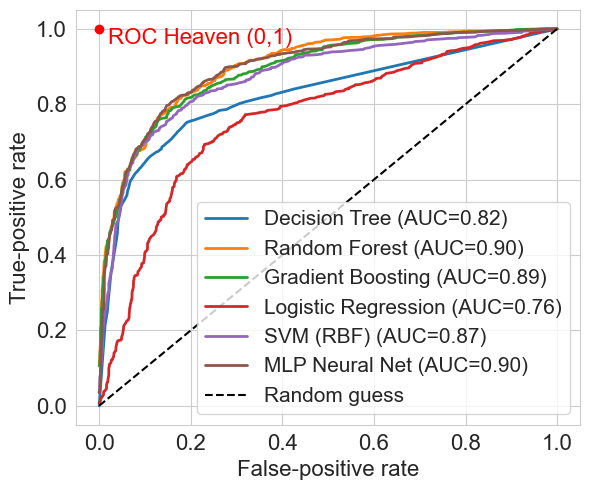

In [63]:
plt.figure(figsize=(6,5))
classes_fac    = np.unique(y_test)
y_test_bin_fac = label_binarize(y_test, classes=classes_fac)

for name, mdl in models.items():
    proba_fac = mdl.predict_proba(X_test)
    fpr_c, tpr_c = {}, {}
    for i in range(proba_fac.shape[1]):
        fpr_c[i], tpr_c[i], _ = roc_curve(y_test_bin_fac[:,i], proba_fac[:,i])
    all_fpr  = np.unique(np.concatenate(list(fpr_c.values())))
    mean_tpr = np.mean([np.interp(all_fpr, fpr_c[i], tpr_c[i]) for i in fpr_c], axis=0)
    auc_val  = results_df_fac.loc[name,'ROC_AUC_macro']
    plt.plot(all_fpr, mean_tpr, lw=2, label=f"{name} (AUC={auc_val:.2f})")

plt.plot([0,1], [0,1], 'k--', label="Random guess")
plt.scatter(0, 1, color='red')
plt.text(0.02, 0.96, "ROC Heaven (0,1)", color='red', fontsize=16)
plt.xlabel("False-positive rate", fontsize=16)
plt.ylabel("True-positive rate", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="lower right", fontsize=15)
plt.tight_layout()
plt.savefig('images/ROC_FAC.png')
plt.show()


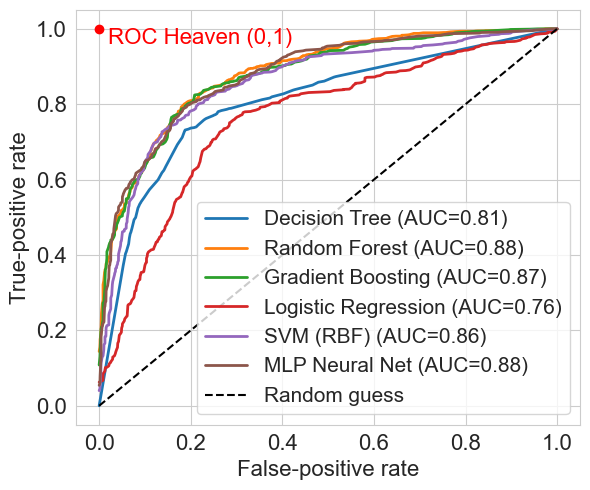

In [64]:
plt.figure(figsize=(6,5))
y_true_bin = label_binarize(true_ffp, classes=[0,1,2])

# Extract class indices once using any model
example_model = next(iter(models.values()))
fac_proba_example = example_model.predict_proba(X_test)
classes_example = example_model.classes_
idx = {v: i for i, v in enumerate(classes_example)}

for name, mdl in models.items():
    fac_proba = mdl.predict_proba(X_test)

    # Use idx to map FAC classes to FFP probabilities
    p0 = fac_proba[:, idx[5]]
    p1 = fac_proba[:, idx[3]] + fac_proba[:, idx[4]]
    p2 = fac_proba[:, idx[1]] + fac_proba[:, idx[2]]
    proba_ffp = np.vstack([p0, p1, p2]).T

    fpr_d, tpr_d = {}, {}
    for i in range(3):
        fpr_d[i], tpr_d[i], _ = roc_curve(y_true_bin[:, i], proba_ffp[:, i])
    all_fpr  = np.unique(np.concatenate(list(fpr_d.values())))
    mean_tpr = np.mean([np.interp(all_fpr, fpr_d[i], tpr_d[i]) for i in fpr_d], axis=0)
    auc_val  = results_df_ffp.loc[name, 'ROC_AUC_macro']
    plt.plot(all_fpr, mean_tpr, lw=2, label=f"{name} (AUC={auc_val:.2f})")

# Plot decorations
plt.plot([0,1], [0,1], 'k--', label="Random guess")
plt.scatter(0, 1, color='red')
plt.text(0.02, 0.96, "ROC Heaven (0,1)", color='red', fontsize=16)
plt.xlabel("False-positive rate", fontsize=16)
plt.ylabel("True-positive rate", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# ⬅️ Legend moved inside the plot area
plt.legend(loc='lower right', fontsize=15, frameon=True)

plt.tight_layout()
plt.savefig('images/ROC_FFP.png')
plt.show()



🔢 Absolute Confusion Matrix (Random Forest – FAC)
    1   2   3    4    5
1  27   1   3    3    1
2   1  21   1    1    1
3   4   3  47   14    8
4   7  25  30  226   50
5   2   1   9   53  111

📊 Percentage Confusion Matrix (Column-Normalized %)
      1     2     3     4     5
1  65.9   2.0   3.3   1.0   0.6
2   2.4  41.2   1.1   0.3   0.6
3   9.8   5.9  52.2   4.7   4.7
4  17.1  49.0  33.3  76.1  29.2
5   4.9   2.0  10.0  17.8  64.9


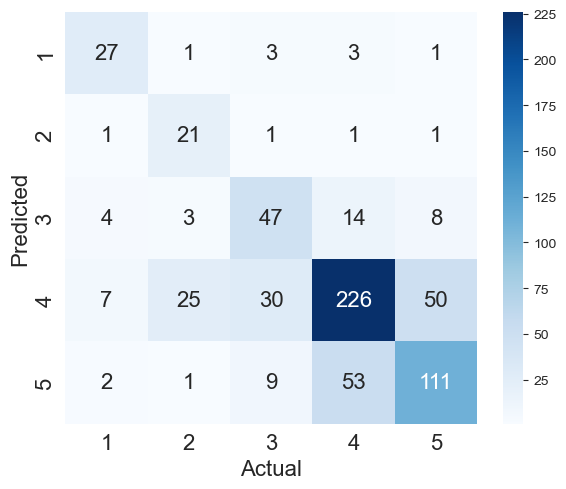

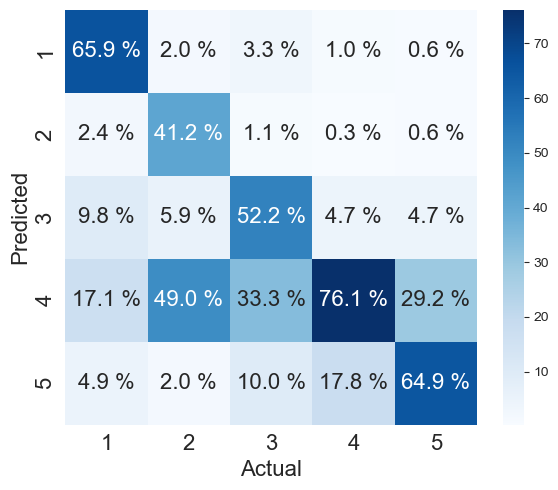

In [65]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Use the Random Forest model and predictions
rf_model = models['Random Forest']       # Already trained with best params
y_pred_rf = rf_model.predict(X_test)     # Predict on test set

# Unique FAC classes (ensure correct label order)
fac_classes = np.unique(y_test)

# 1. Absolute confusion matrix
cm_fac_abs = confusion_matrix(y_test, y_pred_rf, labels=fac_classes)

# 2. Column-normalized (percentage) confusion matrix
cm_fac_pct = confusion_matrix(y_test, y_pred_rf, labels=fac_classes, normalize='pred')
cm_fac_pct_rounded = np.round(cm_fac_pct * 100, 1)

# Convert to DataFrame
cm_df_abs = pd.DataFrame(cm_fac_abs, index=fac_classes, columns=fac_classes)
cm_df_pct = pd.DataFrame(cm_fac_pct_rounded, index=fac_classes, columns=fac_classes)

# Annotate with percentage and "%" sign
labels_pct = np.array([[f"{val:.1f} %" for val in row] for row in cm_fac_pct_rounded])

# Print for inspection
print("\n🔢 Absolute Confusion Matrix (Random Forest – FAC)")
print(cm_df_abs)

print("\n📊 Percentage Confusion Matrix (Column-Normalized %)")
print(cm_df_pct)

# Plot absolute confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df_abs, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
#plt.title("Random Forest – FAC Confusion Matrix (Absolute)", fontsize=16)
plt.xlabel("Actual", fontsize=16)
plt.ylabel("Predicted", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('images/confMatrixRFandFAC.png')
plt.show()

# Plot percentage confusion matrix with formatted labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm_fac_pct_rounded, annot=labels_pct, fmt='', cmap='Blues',
            xticklabels=fac_classes, yticklabels=fac_classes,
            annot_kws={"size": 16})
#plt.title("Random Forest – FAC Confusion Matrix (%)", fontsize=16)
plt.xlabel("Actual", fontsize=16)
plt.ylabel("Predicted", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('images/confMatrixRFandFACpercentage.png')
plt.show()


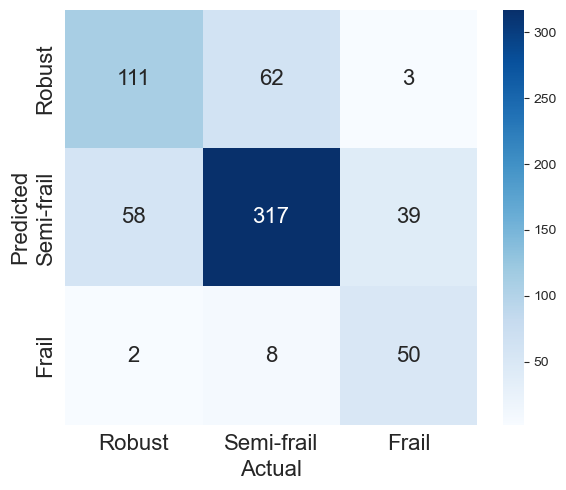

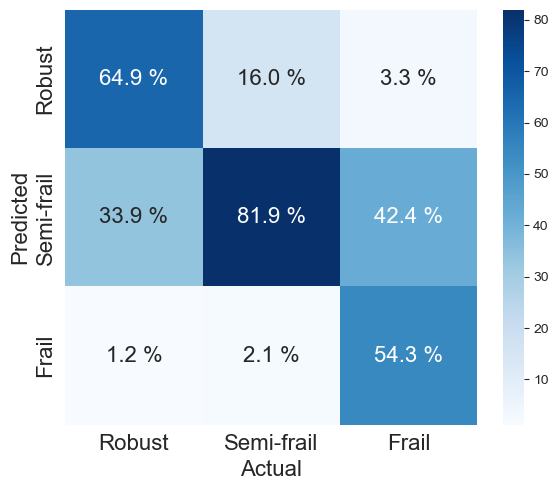

In [66]:
# === Confusion matrices (absolute + percentage) for Random Forest at FFP level ===

# Get predicted FAC and convert to FFP
rf_model = models["Random Forest"]
rf_pred_fac = rf_model.predict(X_test)
rf_pred_ffp = np.array([map_ffp(f) for f in rf_pred_fac])

# Define FFP labels
FFP_LABELS = ['Robust', 'Semi-frail', 'Frail']

# --- 1. Absolute confusion matrix ---
cm_rf_ffp = confusion_matrix(true_ffp, rf_pred_ffp)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_ffp, annot=True, fmt='d', cmap='Blues',
            xticklabels=FFP_LABELS, yticklabels=FFP_LABELS,
            annot_kws={"size": 16})
plt.xlabel("Actual", fontsize=16)
plt.ylabel("Predicted", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("images/RF_FFP_confusion_matrix_abs.png")
plt.show()

# --- 2. Percentage (column-normalized) confusion matrix ---
cm_rf_ffp_pct = confusion_matrix(true_ffp, rf_pred_ffp, normalize='pred')
cm_rf_ffp_pct = np.round(cm_rf_ffp_pct * 100, 1)
labels_rf_ffp = np.array([[f"{val:.1f} %" for val in row] for row in cm_rf_ffp_pct])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_ffp_pct, annot=labels_rf_ffp, fmt='', cmap='Blues',
            xticklabels=FFP_LABELS, yticklabels=FFP_LABELS,
            annot_kws={"size": 16})
plt.xlabel("Actual", fontsize=16)
plt.ylabel("Predicted", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("images/RF_FFP_confusion_matrix_pct.png")
plt.show()


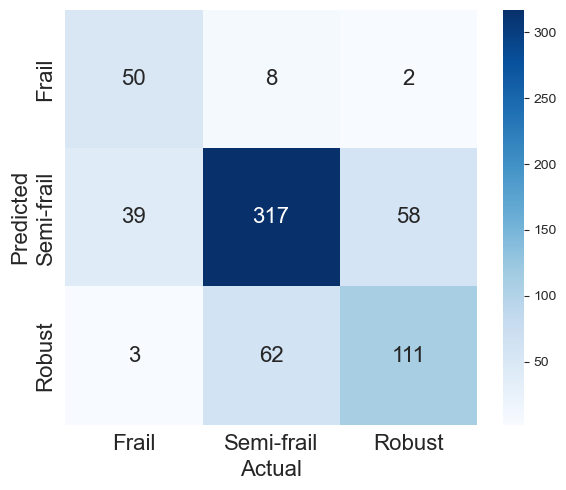

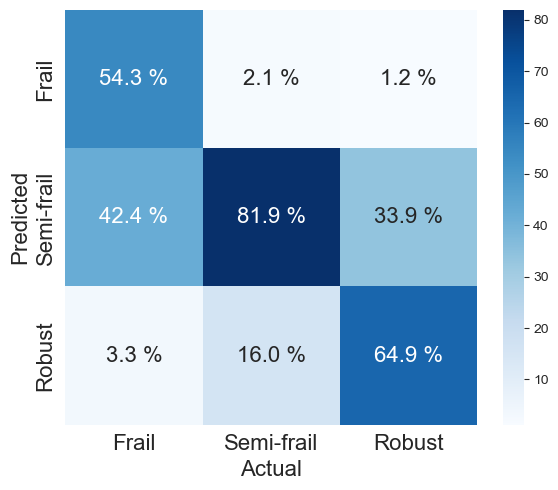

In [67]:
# Reverse class labels for display
FFP_LABELS_REVERSED = FFP_LABELS[::-1]  # ['Frail', 'Semi-frail', 'Robust']

# --- 1. Absolute confusion matrix with inverted axes ---
cm_rf_ffp = confusion_matrix(true_ffp, rf_pred_ffp)

# Invert rows and columns
cm_rf_ffp_inv = cm_rf_ffp[::-1, ::-1]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_ffp_inv, annot=True, fmt='d', cmap='Blues',
            xticklabels=FFP_LABELS_REVERSED, yticklabels=FFP_LABELS_REVERSED,
            annot_kws={"size": 16})
plt.xlabel("Actual", fontsize=16)
plt.ylabel("Predicted", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("images/RF_FFP_confusion_matrix_abs.png")
plt.show()

# --- 2. Percentage (column-normalized) confusion matrix with inverted axes ---
cm_rf_ffp_pct = confusion_matrix(true_ffp, rf_pred_ffp, normalize='pred')
cm_rf_ffp_pct = np.round(cm_rf_ffp_pct * 100, 1)

# Invert rows and columns
cm_rf_ffp_pct_inv = cm_rf_ffp_pct[::-1, ::-1]
labels_rf_ffp = np.array([[f"{val:.1f} %" for val in row] for row in cm_rf_ffp_pct_inv])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_ffp_pct_inv, annot=labels_rf_ffp, fmt='', cmap='Blues',
            xticklabels=FFP_LABELS_REVERSED, yticklabels=FFP_LABELS_REVERSED,
            annot_kws={"size": 16})
plt.xlabel("Actual", fontsize=16)
plt.ylabel("Predicted", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("images/RF_FFP_confusion_matrix_pct.png")
plt.show()


In [68]:
import pandas as pd
import re

# 1) Choose model
rf_model = models["Random Forest"]

# 2) Build pred & true DataFrames (at window-level FAC)
# ------------------------------------------------------
pred_df_rf = pd.DataFrame({
    'WindowID' : meta_test['WindowID'],
    'PatientID': meta_test['PatientID'],
    'Visit'    : meta_test['Visit'],
    'pred_FAC' : rf_model.predict(X_test)
})
true_df_rf = pd.DataFrame({
    'WindowID' : meta_test['WindowID'],
    'PatientID': meta_test['PatientID'],
    'Visit'    : meta_test['Visit'],
    'true_FAC' : y_test
})

# 3) Patient-level FAC by visit
# ------------------------------------------------------------
pred_visit_rf = (
    pred_df_rf
    .groupby(['PatientID','Visit'])['pred_FAC']
    .median()
    .unstack()
)
true_visit = (
    true_df_rf
    .groupby(['PatientID','Visit'])['true_FAC']
    .median()
    .unstack()
)

# Rename columns
pred_visit_rf.columns = [f"median_pred_FAC_visit{visit_num(v)}"
                         for v in pred_visit_rf.columns]
true_visit.columns = [f"median_true_FAC_visit{visit_num(v)}"
                      for v in true_visit.columns]

# Join and compute differences/improvements
visit_rf = pred_visit_rf.join(true_visit, how='inner').dropna()
visit_rf['diff_pred']     = visit_rf['median_pred_FAC_visit2'] - visit_rf['median_pred_FAC_visit1']
visit_rf['improved_pred'] = visit_rf['diff_pred'] > 0
visit_rf['diff_true']     = visit_rf['median_true_FAC_visit2'] - visit_rf['median_true_FAC_visit1']
visit_rf['improved_true'] = visit_rf['diff_true'] > 0

# Build first table
vis_rf = visit_rf.reset_index()[[
    'PatientID',
    'median_pred_FAC_visit1','median_true_FAC_visit1',
    'median_pred_FAC_visit2','median_true_FAC_visit2',
    'diff_pred','diff_true',
    'improved_pred','improved_true'
]]
print("Patient-level FAC by visit (Random Forest)")
display(vis_rf.style.apply(highlight_mismatch, axis=1))


# 4) Patient x Placement FAC
# ------------------------------
pred_ppv_rf = (
    pred_df_rf
    .assign(Placement=meta_test['Placement'])
    .groupby(['PatientID','Placement','Visit'])['pred_FAC']
    .median()
    .unstack('Visit')
)
true_ppv = (
    true_df_rf
    .assign(Placement=meta_test['Placement'])
    .groupby(['PatientID','Placement','Visit'])['true_FAC']
    .median()
    .unstack('Visit')
)

# Rename columns
pred_ppv_rf.columns = [f"median_pred_FAC_visit{visit_num(v)}"
                       for v in pred_ppv_rf.columns]
true_ppv.columns = [f"median_true_FAC_visit{visit_num(v)}"
                    for v in true_ppv.columns]

# Join and compute differences/improvements (updated version)
ppv_rf = pred_ppv_rf.join(true_ppv, how='inner').dropna(
    subset=[
        'median_pred_FAC_visit1','median_pred_FAC_visit2',
        'median_true_FAC_visit1','median_true_FAC_visit2'
    ]
)
ppv_rf['diff_pred']     = ppv_rf['median_pred_FAC_visit2'] - ppv_rf['median_pred_FAC_visit1']
ppv_rf['improved_pred'] = ppv_rf['diff_pred'] > 0
ppv_rf['diff_true']     = ppv_rf['median_true_FAC_visit2'] - ppv_rf['median_true_FAC_visit1']
ppv_rf['improved_true'] = ppv_rf['diff_true'] > 0

# Build second table (updated)
ppv_table_rf = ppv_rf.reset_index()[[
    'PatientID','Placement',
    'median_pred_FAC_visit1','median_true_FAC_visit1',
    'median_pred_FAC_visit2','median_true_FAC_visit2',
    'diff_pred','diff_true',
    'improved_pred','improved_true'
]]
print("Patient x Placement FAC (Random Forest)")
display(ppv_table_rf.style.apply(highlight_mismatch, axis=1))


Patient-level FAC by visit (Random Forest)


,PatientID,median_pred_FAC_visit1,median_true_FAC_visit1,median_pred_FAC_visit2,median_true_FAC_visit2,diff_pred,diff_true,improved_pred,improved_true
0,1,5.000000,5.000000,4.500000,5.000000,-0.500000,0.000000,False,False
1,11,2.000000,2.000000,4.000000,4.000000,2.000000,2.000000,True,True
2,12,4.000000,4.000000,5.000000,5.000000,1.000000,1.000000,True,True
3,13,1.000000,1.000000,3.000000,3.000000,2.000000,2.000000,True,True
4,2,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,False,False
5,3,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,False,False
6,6,3.000000,3.000000,4.000000,4.000000,1.000000,1.000000,True,True
7,7,4.000000,4.000000,4.000000,4.000000,0.000000,0.000000,False,False
8,8,4.000000,4.000000,4.000000,4.000000,0.000000,0.000000,False,False
9,9,4.000000,4.000000,4.000000,4.000000,0.000000,0.000000,False,False


Patient x Placement FAC (Random Forest)


,PatientID,Placement,median_pred_FAC_visit1,median_true_FAC_visit1,median_pred_FAC_visit2,median_true_FAC_visit2,diff_pred,diff_true,improved_pred,improved_true
0,1,LF,5.000000,5.000000,4.000000,5.000000,-1.000000,0.000000,False,False
1,1,LW,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,False,False
2,1,RF,4.000000,5.000000,5.000000,5.000000,1.000000,0.000000,True,False
3,1,RW,5.000000,5.000000,4.000000,5.000000,-1.000000,0.000000,False,False
4,11,LF,2.000000,2.000000,4.000000,4.000000,2.000000,2.000000,True,True
5,11,RF,2.000000,2.000000,4.000000,4.000000,2.000000,2.000000,True,True
6,11,SA,2.000000,2.000000,5.000000,4.000000,3.000000,2.000000,True,True
7,12,LF,4.000000,4.000000,5.000000,5.000000,1.000000,1.000000,True,True
8,12,LW,5.000000,4.000000,5.000000,5.000000,0.000000,1.000000,False,True
9,12,RF,4.000000,4.000000,4.000000,5.000000,0.000000,1.000000,False,True


=== Patient-level FAC-Improvement metrics (all models) ===


,Accuracy,Precision,Recall,F1,Specificity,ROC_AUC
Decision Tree,0.9,0.8000,1.0,0.8889,0.8333,0.9167
Random Forest,1.0,1.0000,1.0,1.0000,1.0000,1.0000
Gradient Boosting,1.0,1.0000,1.0,1.0000,1.0000,1.0000
Logistic Regression,0.7,0.6667,0.5,0.5714,0.8333,0.6667
SVM (RBF),1.0,1.0000,1.0,1.0000,1.0000,1.0000
MLP Neural Net,1.0,1.0000,1.0,1.0000,1.0000,1.0000


=== Patient×Placement FAC-Improvement metrics (all models) ===


,Accuracy,Precision,Recall,F1,Specificity,ROC_AUC
Decision Tree,0.7872,0.6818,0.8333,0.7500,0.7586,0.7960
Random Forest,0.8085,0.7368,0.7778,0.7568,0.8276,0.8027
Gradient Boosting,0.8723,0.8333,0.8333,0.8333,0.8966,0.8649
Logistic Regression,0.7021,0.6111,0.6111,0.6111,0.7586,0.6849
SVM (RBF),0.7660,0.6842,0.7222,0.7027,0.7931,0.7577
MLP Neural Net,0.7447,0.6500,0.7222,0.6842,0.7586,0.7404


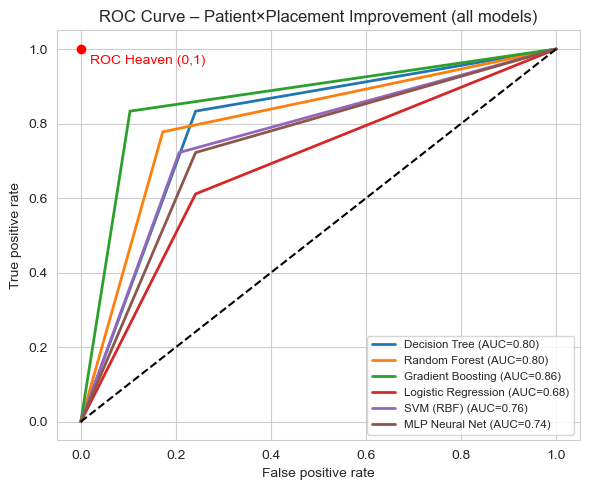

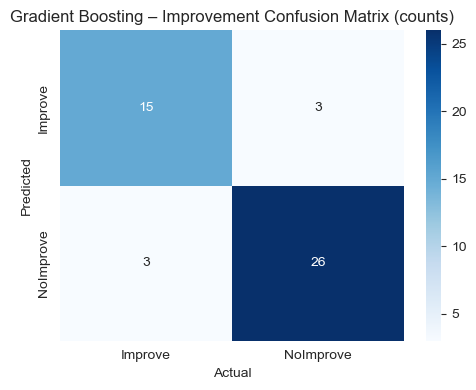

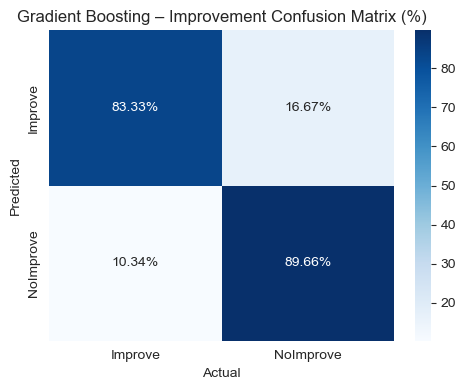

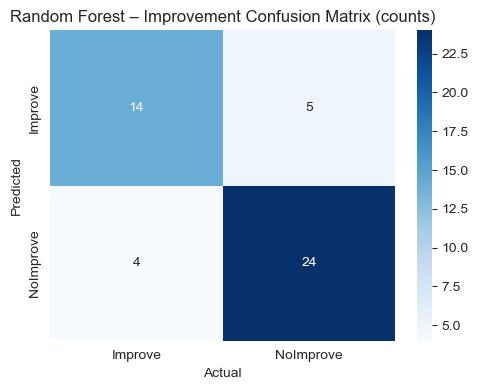

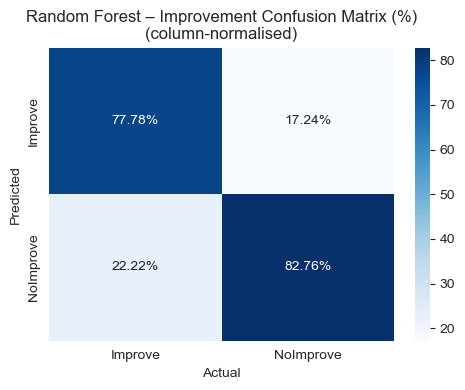

In [69]:
# Cell 36 – FAC-Improvement performance for all models

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)

# ─────────────────────────────────────────────────────────────
# ⚠️ Fix: rename the “true” DataFrames so joins work without KeyError
# ─────────────────────────────────────────────────────────────
true_visit.columns = [
    f"median_true_FAC_visit{visit_num(v)}"
    for v in true_visit.columns
]
true_ppv.columns = [
    f"median_true_FAC_visit{visit_num(v)}"
    for v in true_ppv.columns
]

# ─────────────────────────────────────────────────────────────
# visit_common and ppv from Cell 35 already have 'improved_true'
# ─────────────────────────────────────────────────────────────
# (these are only used for pulling in the ground-truth flag)
y_true_pat_all = visit_common['improved_true']
y_true_pp_all  = ppv['improved_true']

# Containers for metrics and for storing predictions
metrics_imp_patient = {}
metrics_imp_pp      = {}
predictions_pp      = {}

for name, mdl in models.items():
    # ──────────────────────────────────────────
    # 1)  FAC predictions on test set
    # ──────────────────────────────────────────
    y_pred_fac = mdl.predict(X_test)
    pred_df_fac = pd.DataFrame({
        'WindowID' : meta_test['WindowID'],
        'PatientID': meta_test['PatientID'],
        'Visit'    : meta_test['Visit'],
        'pred_FAC' : y_pred_fac
    })

    # ──────────────────────────────────────────
    # 2)  Patient-level improvement
    # ──────────────────────────────────────────
    pred_visit = (
        pred_df_fac
        .groupby(['PatientID','Visit'])['pred_FAC']
        .median()
        .unstack()
    )
    pred_visit.columns = [
        f"median_pred_FAC_visit{visit_num(v)}"
        for v in pred_visit.columns
    ]

    # join true medians (now with correctly named columns)
    visit_comb = pred_visit.join(true_visit, how='inner').dropna()

    # predicted improvement
    visit_comb['diff_pred']    = (
        visit_comb['median_pred_FAC_visit2']
        - visit_comb['median_pred_FAC_visit1']
    )
    visit_comb['improved_pred'] = visit_comb['diff_pred'] > 0

    # bring in the true-improvement flag
    visit_comb['improved_true'] = visit_common.loc[
        visit_comb.index, 'improved_true'
    ]

    # compute patient-level metrics
    y_pred_pat = visit_comb['improved_pred']
    y_true_pat = visit_comb['improved_true']
    tn, fp, fn, tp = confusion_matrix(y_true_pat, y_pred_pat).ravel()
    metrics_imp_patient[name] = {
        'Accuracy'   : accuracy_score(y_true_pat, y_pred_pat),
        'Precision'  : precision_score(y_true_pat, y_pred_pat, zero_division=0),
        'Recall'     : recall_score(y_true_pat, y_pred_pat, zero_division=0),
        'F1'         : f1_score(y_true_pat, y_pred_pat, zero_division=0),
        'Specificity': tn/(tn+fp) if (tn+fp) else 0,
        'ROC_AUC'    : roc_auc_score(y_true_pat, y_pred_pat)
    }

    # ──────────────────────────────────────────
    # 3)  Patient×Placement improvement
    # ──────────────────────────────────────────
    pred_pp_df = pred_df_fac.assign(Placement=meta_test['Placement'])
    pred_ppv_model = (
        pred_pp_df
        .groupby(['PatientID','Placement','Visit'])['pred_FAC']
        .median()
        .unstack('Visit')
    )
    pred_ppv_model.columns = [
        f"median_pred_FAC_visit{visit_num(v)}"
        for v in pred_ppv_model.columns
    ]

    # join true medians for Placement (now matching names)
    ppv_comb = pred_ppv_model.join(true_ppv, how='inner').dropna(
        subset=[
            'median_pred_FAC_visit1','median_pred_FAC_visit2',
            'median_true_FAC_visit1','median_true_FAC_visit2'
        ]
    )

    # predicted improvement
    ppv_comb['diff_pred']    = (
        ppv_comb['median_pred_FAC_visit2']
        - ppv_comb['median_pred_FAC_visit1']
    )
    ppv_comb['improved_pred'] = ppv_comb['diff_pred'] > 0

    # bring in the true-improvement flag
    ppv_comb['improved_true'] = ppv.loc[
        ppv_comb.index, 'improved_true'
    ]

    # compute Patient×Placement metrics
    y_pred_pp = ppv_comb['improved_pred']
    y_true_pp = ppv_comb['improved_true']
    tn, fp, fn, tp = confusion_matrix(y_true_pp, y_pred_pp).ravel()
    metrics_imp_pp[name] = {
        'Accuracy'   : accuracy_score(y_true_pp, y_pred_pp),
        'Precision'  : precision_score(y_true_pp, y_pred_pp, zero_division=0),
        'Recall'     : recall_score(y_true_pp, y_pred_pp, zero_division=0),
        'F1'         : f1_score(y_true_pp, y_pred_pp, zero_division=0),
        'Specificity': tn/(tn+fp) if (tn+fp) else 0,
        'ROC_AUC'    : roc_auc_score(y_true_pp, y_pred_pp)
    }

    # store for ROC plotting & confusion matrix
    predictions_pp[name] = (y_true_pp, y_pred_pp)


# ─────────────────────────────────────────────────────────────
# Display aggregated metrics
# ─────────────────────────────────────────────────────────────
df_imp_patient_all = pd.DataFrame(metrics_imp_patient).T.round(4)
print("=== Patient-level FAC-Improvement metrics (all models) ===")
display(df_imp_patient_all)

df_imp_pp_all = pd.DataFrame(metrics_imp_pp).T.round(4)
print("=== Patient×Placement FAC-Improvement metrics (all models) ===")
display(df_imp_pp_all)


# ─────────────────────────────────────────────────────────────
# Plot ROC curves for Patient×Placement (all models)
# ─────────────────────────────────────────────────────────────
plt.figure(figsize=(6,5))
for name, (y_true, y_pred) in predictions_pp.items():
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_val = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_val:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.scatter(0,1, color='red')
plt.text(0.02,0.96,"ROC Heaven (0,1)", color='red')
plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
plt.title('ROC Curve – Patient×Placement Improvement (all models)')
plt.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.savefig('images/ROC_improvement_all_models.png')
plt.show()

# confusion matrices
# --------------
# • choose the best Patient×Placement model (highest F1)
best_pp_name = df_imp_pp_all['F1'].idxmax()               # e.g. 'Random Forest'

# • pull its y_true / y_pred arrays that we stored earlier
y_true_best, y_pred_best = predictions_pp[best_pp_name]

label_order = [True, False]       # True = Improve , False = NoImprove

# ---------- (a) raw counts ----------
cm_best = confusion_matrix(              # rows = true, cols = pred
    y_true_best, y_pred_best,
    labels=label_order
).T                                      # ⇐ transpose → rows = pred, cols = true

plt.figure(figsize=(5,4))
sns.heatmap(cm_best,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Improve','NoImprove'],   # Actual  (cols)
            yticklabels=['Improve','NoImprove'])   # Predicted (rows)
plt.title(f"{best_pp_name} – Improvement Confusion Matrix (counts)")
plt.xlabel("Actual");  plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig(f"images/{best_pp_name}_imp_confusion_counts.png")
plt.show()

# ---------- (b) column-normalised percentages ----------
cm_best_pct = confusion_matrix(
    y_true_best, y_pred_best,
    labels=label_order,
    normalize='pred'                    # normalise by original *columns*
).T * 100                               # transpose afterwards
cm_best_pct = np.round(cm_best_pct, 2)
labels_pct = np.array([[f"{v:.2f}%" for v in row] for row in cm_best_pct])

plt.figure(figsize=(5,4))
sns.heatmap(cm_best_pct,
            annot=labels_pct, fmt='', cmap='Blues',
            xticklabels=['Improve','NoImprove'],
            yticklabels=['Improve','NoImprove'])
plt.title(f"{best_pp_name} – Improvement Confusion Matrix (%)")
plt.xlabel("Actual");  plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig(f"images/{best_pp_name}_imp_confusion_pct.png")
plt.show()

# ─────────────────────────────────────────────────────────────
# Confusion matrices (Random-Forest only) – counts + column %
# ─────────────────────────────────────────────────────────────
rf_name = "Random Forest"           # label used in `models` / `predictions_pp`

# pull Random-Forest predictions that were cached earlier
y_true_rf, y_pred_rf = predictions_pp[rf_name]

label_order = [True, False]         # True = Improve, False = No-Improve

# ------------------------------------------------- (a) raw counts
cm_rf = confusion_matrix(
    y_true_rf, y_pred_rf, labels=label_order
).T                                 # rows ← Predicted,  cols ← Actual

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_rf, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Improve","NoImprove"],   # Actual  (columns)
    yticklabels=["Improve","NoImprove"]    # Predicted (rows)
)
plt.title(f"{rf_name} – Improvement Confusion Matrix (counts)")
plt.xlabel("Actual");  plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig(f"images/{rf_name.replace(' ','_')}_imp_confusion_counts.png")
plt.show()

# -------------------------------------- (b) column-normalised (%)
col_sums       = cm_rf.sum(axis=0, keepdims=True)          # 1×2
cm_rf_pct_cols = np.divide(cm_rf, col_sums, where=col_sums!=0) * 100
cm_rf_pct_cols = np.round(cm_rf_pct_cols, 2)

labels_pct = np.array([[f"{v:.2f}%" for v in row]
                       for row in cm_rf_pct_cols])

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_rf_pct_cols, annot=labels_pct, fmt="", cmap="Blues",
    xticklabels=["Improve","NoImprove"],
    yticklabels=["Improve","NoImprove"]
)
plt.title(f"{rf_name} – Improvement Confusion Matrix (%)\n(column-normalised)")
plt.xlabel("Actual");  plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig(f"images/{rf_name.replace(' ','_')}_imp_confusion_pct_col.png")
plt.show()






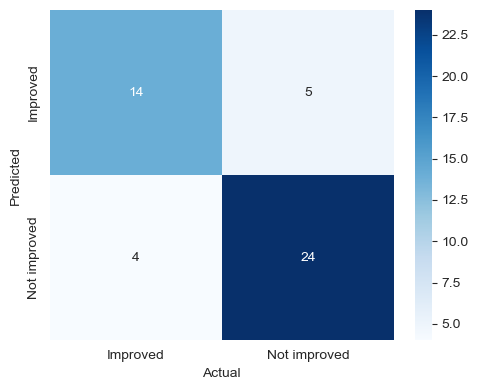

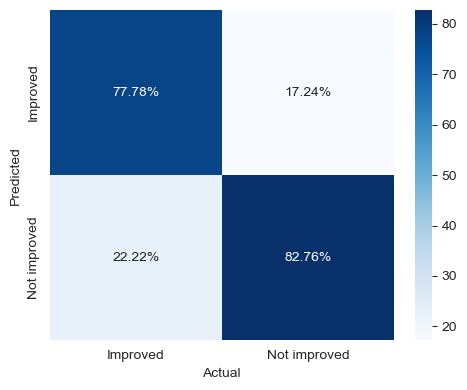

In [70]:
# ─────────────────────────────────────────────────────────────
# Confusion matrices (Random-Forest only) – counts + column %
# ─────────────────────────────────────────────────────────────
rf_name = "Random Forest"           # label used in `models` / `predictions_pp`

# pull Random-Forest predictions that were cached earlier
y_true_rf, y_pred_rf = predictions_pp[rf_name]

label_order = [True, False]         # True = Improve, False = No-Improve

# ------------------------------------------------- (a) raw counts
cm_rf = confusion_matrix(
    y_true_rf, y_pred_rf, labels=label_order
).T                                 # rows ← Predicted,  cols ← Actual

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_rf, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Improved","Not improved"],   # Actual  (columns)
    yticklabels=["Improved","Not improved"]    # Predicted (rows)
)
#plt.title(f"{rf_name} – Improvement Confusion Matrix (counts)")
plt.xlabel("Actual");  plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig(f"images/{rf_name.replace(' ','_')}_imp_confusion_counts.png")
plt.show()

# -------------------------------------- (b) column-normalised (%)
col_sums       = cm_rf.sum(axis=0, keepdims=True)          # 1×2
cm_rf_pct_cols = np.divide(cm_rf, col_sums, where=col_sums!=0) * 100
cm_rf_pct_cols = np.round(cm_rf_pct_cols, 2)

labels_pct = np.array([[f"{v:.2f}%" for v in row]
                       for row in cm_rf_pct_cols])

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_rf_pct_cols, annot=labels_pct, fmt="", cmap="Blues",
    xticklabels=["Improved","Not improved"],
    yticklabels=["Improved","Not improved"]
)
#plt.title(f"{rf_name} – Improvement Confusion Matrix (%)\n(column-normalised)")
plt.xlabel("Actual");  plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig(f"images/{rf_name.replace(' ','_')}_imp_confusion_pct_col.png")
plt.show()


## Improvements

## Perfomance for Improvement: predicted(median FAC visit 1 - median FAC visit 2) = true(median FAC visit 1 - mmedian FAC visit 2)

In [71]:
# cell 37 - plot radar graph

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import math

# ─────────────────────────────────────────────────────────────
# PREP: recompute & store all medians_per_model (unchanged)
# ─────────────────────────────────────────────────────────────
placements  = ['LF','LW','RF','RW','SA']
base_angles = np.linspace(0, 2*np.pi, len(placements), endpoint=False)

def visit_num(lbl):
    m = re.findall(r'\d+', str(lbl))
    return m[0] if m else str(lbl)

medians_per_model = {}
for name, mdl in models.items():
    y_pred = mdl.predict(X_test)
    pred_ppv = pd.DataFrame({
        'PatientID': meta_test['PatientID'],
        'Placement': meta_test['Placement'],
        'Visit'    : meta_test['Visit'],
        'pred_FAC' : y_pred
    })
    true_ppv = pd.DataFrame({
        'PatientID': meta_test['PatientID'],
        'Placement': meta_test['Placement'],
        'Visit'    : meta_test['Visit'],
        'true_FAC' : y_test
    })
    p_med = pred_ppv.groupby(['PatientID','Placement','Visit'])['pred_FAC'] \
                    .median().unstack('Visit')
    t_med = true_ppv.groupby(['PatientID','Placement','Visit'])['true_FAC'] \
                    .median().unstack('Visit')
    p_med.columns = [f"median_pred_FAC_visit{visit_num(v)}" for v in p_med.columns]
    t_med.columns = [f"median_true_FAC_visit{visit_num(v)}" for v in t_med.columns]
    df = p_med.join(t_med).dropna(subset=[
        'median_pred_FAC_visit1','median_pred_FAC_visit2',
        'median_true_FAC_visit1','median_true_FAC_visit2'
    ])
    medians_per_model[name] = df

# ─────────────────────────────────────────────────────────────
# PLOT & SAVE radar charts for ALL patients, 2 patients per row
# ─────────────────────────────────────────────────────────────
os.makedirs('images', exist_ok=True)

for name, mdl in models.items():
    df   = medians_per_model[name]
    pats = sorted(
        df.index.get_level_values('PatientID').unique(),
        key=lambda x: int(x)
    )
    n_pats = len(pats)
    if n_pats == 0:
        print(f"Model {name!r} has no patients → skipping.")
        continue

    # grid: 2 patients per row → n_cols = 4 (Visit1, Visit2 × 2 patients)
    n_rows = math.ceil(n_pats/2)
    fig, axes = plt.subplots(
        n_rows, 4,
        figsize=(4*3, 3*n_rows),  # adjust as you like
        subplot_kw={'polar': True},
        dpi=100
    )
    axes = np.atleast_2d(axes)

    for idx, pid in enumerate(pats):
        row = idx // 2
        col_block = (idx % 2) * 2

        sub = df.loc[pid]
        avail  = [pl for pl in placements if pl in sub.index]
        angles = [base_angles[placements.index(pl)] for pl in avail] + [base_angles[placements.index(avail[0])]]

        def wrap(colname):
            vals = [sub.loc[pl, colname] for pl in avail]
            return vals + [vals[0]]

        # Visit 1 at [row, col_block]
        ax1 = axes[row, col_block]
        v1p = wrap('median_pred_FAC_visit1')
        v1t = wrap('median_true_FAC_visit1')
        ax1.set_theta_offset(np.pi/2)
        ax1.set_theta_direction(-1)
        ax1.set_xticks(angles[:-1])
        ax1.set_xticklabels(avail, fontsize=9)
        ax1.set_ylim(0,5); ax1.set_yticks([0,1,2,3,4,5])
        ax1.plot(angles, v1p, 'o--', color='lightcoral',   label='pred V1')
        ax1.plot(angles, v1t, 'o-',  color='lightgreen',  label='true V1')
        ax1.set_title(f"{name}\nPt {pid} — Visit 1", fontsize=12, y=1.15)

        # Visit 2 at [row, col_block+1]
        ax2 = axes[row, col_block+1]
        v2p = wrap('median_pred_FAC_visit2')
        v2t = wrap('median_true_FAC_visit2')
        ax2.set_theta_offset(np.pi/2)
        ax2.set_theta_direction(-1)
        ax2.set_xticks(angles[:-1])
        ax2.set_xticklabels(avail, fontsize=9)
        ax2.set_ylim(0,5); ax2.set_yticks([0,1,2,3,4,5])
        ax2.plot(angles, v2p, 'o--', color='red',    label='pred V2')
        ax2.plot(angles, v2t, 'o-',  color='green',  label='true V2')
        ax2.set_title(f"{name}\nPt {pid} — Visit 2", fontsize=12, y=1.15)

    # turn off any unused subplots
    for unused in range(n_pats, n_rows*2):
        r = unused // 2
        cblock = (unused % 2)*2
        axes[r, cblock].axis('off')
        axes[r, cblock+1].axis('off')

    # shared legend
    h1,l1 = axes[0,0].get_legend_handles_labels()
    h2,l2 = axes[0,1].get_legend_handles_labels()
    fig.legend(h1+h2, l1+l2,
               loc='upper right', fontsize=10, bbox_to_anchor=(1.15,1.05))

    plt.tight_layout()
    out = f"images/radar_{name.replace(' ','_')}.png"
    fig.savefig(out, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved {out}")
    plt.show()


Saved images/radar_Decision_Tree.png
Saved images/radar_Random_Forest.png
Saved images/radar_Gradient_Boosting.png
Saved images/radar_Logistic_Regression.png
Saved images/radar_SVM_(RBF).png
Saved images/radar_MLP_Neural_Net.png


## SHAP

In [62]:
# # %% Cell 98 – feature importance (LF windows only, F1-F5 ranked)  ✅ NEW
# # ----------------------------------------------------------------
# import pandas as pd
#
# # ────────────────────────────────────────────────────────────────
# # 1)  Select LF rows from *test* split (same mask as before)
# # ────────────────────────────────────────────────────────────────
# lf_mask   = meta_test['Placement'].eq('LF').to_numpy()
# X_test_LF = X_test[lf_mask]                      # shape (n_LF, 10)
#
# # full column list used during training    5 numeric  +  5 PL_* flags
# all_cols  = (
#     ['F1_intensity','F2_cadence','F3_periodicity',
#      'F4_dynamism','F5_ar_variability']
#     + list(X_pl.columns)
# )
#
# X_test_df_LF = pd.DataFrame(X_test_LF, columns=all_cols)
#
# # ────────────────────────────────────────────────────────────────
# # 2)  Pull the tuned Random-Forest that was trained in Cell 35
# # ────────────────────────────────────────────────────────────────
# rf_best = models['Gradient Boosting']       # already fitted – no retraining
#
# # helper: DataFrame of importances
# imp_df = (
#     pd.DataFrame({
#         'Feature'   : all_cols,
#         'Importance': rf_best.feature_importances_
#     })
#     .set_index('Feature')
# )
#
# # ────────────────────────────────────────────────────────────────
# # 3)  Keep only the 5 numeric features & rank them
# # ────────────────────────────────────────────────────────────────
# core_feats = ['F1_intensity','F2_cadence','F3_periodicity',
#               'F4_dynamism','F5_ar_variability']
#
# ranked = (
#     imp_df.loc[core_feats]                  # drop PL_* columns
#           .sort_values('Importance', ascending=False)
#           .reset_index()
#           .round(3)
# )
#
# print("\nRandom-Forest feature importance – LF placement (numeric features only)")
# print(ranked.to_string(index=False))
#
# feat_imp = ranked


In [63]:
# # %% Cell 99 – horizontal bar plot (LF windows only)
# # --------------------------------------------------
# import matplotlib.pyplot as plt
# import matplotlib.ticker   as mtick
#
# # 1)  Plot helper – unchanged
# def plot_feat_imp(feat_importance, top_n=None):
#     """
#     Draw a horizontal bar chart of feature importances.
#     If *top_n* is given, only the top-N rows are plotted.
#     """
#     df = feat_importance.copy()
#     df['Importance_pct'] = df['Importance'] * 100          # → %
#
#     if top_n is not None:
#         df = df.head(top_n)
#
#     ax = (df
#           .sort_values('Importance_pct', ascending=True)
#           .plot.barh(
#               x='Feature',
#               y='Importance_pct',
#               figsize=(6, 3),
#               legend=False
#           ))
#     ax.set_xlabel("Reduction in Entropy (%)")
#     ax.set_ylabel("Feature")
#     ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
#     plt.tight_layout()
#     return ax
#
# # 2)  Draw the plot for the *LF* subset
# ax = plot_feat_imp(feat_imp, top_n=5)
# ax.set_title("Random Forest – feature importance (LF windows)")
# plt.show()


In [335]:
# %% Cell 98 – feature importance (F1–F5 only, renorm. & KEEP 'Importance')
# ------------------------------------------------------------------------
import pandas as pd
import numpy as np

all_cols = (
    ['F1_intensity', 'F2_cadence', 'F3_periodicity',
     'F4_dynamism'] +
    list(X_pl.columns)
)
core_feats = ['F1_intensity','F2_cadence','F3_periodicity',
              'F4_dynamism']

pipe_best = models['Random Forest']          # Pipeline(smote, clf)
rf_clf    = pipe_best.named_steps['clf']     # RandomForestClassifier

imp_raw  = pd.Series(rf_clf.feature_importances_, index=all_cols)
imp_core = imp_raw.loc[core_feats]

# re-normalise → fractions (sum = 1)
imp_core_norm = imp_core / imp_core.sum()

feat_imp = (
    pd.DataFrame({
        'Feature'   : imp_core_norm.index,
        'Importance': np.round(imp_core_norm.values, 3)   # keep column name!
    })
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)

print("\nRandom-Forest feature importance – biomechanical predictors only")
print(feat_imp.to_string(index=False))



Random-Forest feature importance – biomechanical predictors only
       Feature  Importance
  F1_intensity       0.390
   F4_dynamism       0.292
F3_periodicity       0.198
    F2_cadence       0.120


In [340]:
# %% Cell 100 d – SHAP (all sensors pooled, FAC task) – warning-free
# ---------------------------------------------------------------
import shap, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("images", exist_ok=True)

# full training layout (5 biomech + 5 PL_* flags)
all_cols  = (['F1_intensity','F2_cadence','F3_periodicity',
              'F4_dynamism'] +
             ['PL_LF','PL_LW','PL_RF','PL_RW','PL_SA'])
core_feats = all_cols[:5]

# full train / test matrices prepared in Cell 35
X_tr_df = pd.DataFrame(X_train, columns=all_cols)
X_te_df = pd.DataFrame(X_test , columns=all_cols)
y_te    = y_test.copy()

gb_model = models['Random Forest']          # already fitted

# wrapper strips DataFrame -> NumPy to silence sklearn
def gb_proba_np(X):
    return gb_model.predict_proba(np.asarray(X))

explainer = shap.Explainer(
    gb_proba_np,
    X_tr_df,
    feature_names=all_cols,
    output_names=[f"FAC={c}" for c in gb_model.classes_]
)
shap_vals = explainer(X_te_df)

# global importance (F1…F5 only)
mean_abs = np.abs(shap_vals.values).mean(axis=(0,2))[:5]
imp_df   = (pd.DataFrame({'feature':core_feats,
                          'mean(|SHAP value|)':mean_abs})
            .sort_values('mean(|SHAP value|)',ascending=False))

plt.figure(figsize=(6, 4))
plt.barh(imp_df.feature.iloc[:5][::-1],
         imp_df['mean(|SHAP value|)'].iloc[:5][::-1])
plt.xlabel('mean(|SHAP value|)', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.savefig('images/global_importance_gb_FAC_AllSensorsHat.png')
plt.show()

# one force-plot / FAC class, now with class probability label
y_pred = gb_model.predict(X_test)
examples = {}

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})


for fac in gb_model.classes_:
    ok = np.where((y_pred == y_te) & (y_te == fac))[0]
    if len(ok):
        examples[fac] = np.random.choice(ok)
    else:
        alt = np.where(y_te == fac)[0]
        examples[fac] = alt[0] if len(alt) else None

for fac, idx in examples.items():
    cls_idx   = list(gb_model.classes_).index(fac)
    feat_vals = X_te_df.iloc[[idx], :5].round(2)
    prob = gb_model.predict_proba(X_test[[idx]])[0][cls_idx]

    shap.force_plot(
        shap_vals.base_values[idx, cls_idx],
        shap_vals.values[idx, :5, cls_idx].reshape(1, -1),
        feat_vals,
        matplotlib=True, show=False
    )
    plt.title(f"All sensors – FAC={fac} (sample #{idx})", fontsize=14)
    plt.figtext(0.5, 0.01, f"Class probability: {prob:.3f}", ha='center', fontsize=14)
    plt.tight_layout()
    out = f"images/force_FAC{fac}_idx{idx}_AllSensorsHat.png"
    plt.savefig(out)
    plt.show()


print("\n✅ SHAP analysis finished – no sklearn warnings anymore.")


ExactExplainer explainer:  56%|█████▌    | 361/650 [01:28<01:21,  3.56it/s]


KeyboardInterrupt: 

ExactExplainer explainer: 651it [03:50,  2.70it/s]                         


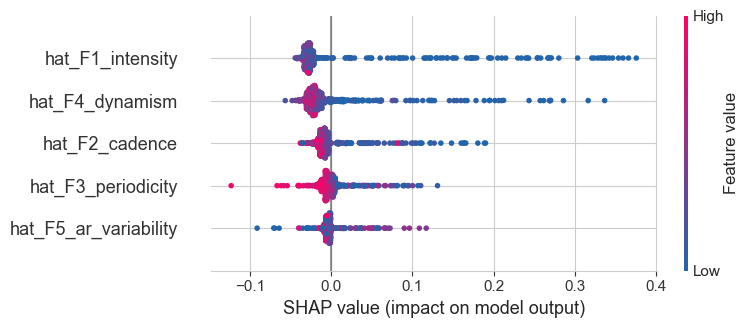


✅ SHAP FAC-analysis finished – biomechanical features only.


In [66]:
# %% Cell 101  – SHAP (all sensors pooled, FAC task) – 5 features, warning-free
# --------------------------------------------------------------------------------
import shap, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("images", exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# 0)  Clinical labels for FAC classes
# ────────────────────────────────────────────────────────────────────────────────
FAC_LABELS = {1: "FAC-1 (very low)",
              2: "FAC-2 (low)",
              3: "FAC-3 (moderate)",
              4: "FAC-4 (high)",
              5: "FAC-5 (highest)"}


# -------------------------------------------------------------------------------
# 1)  Column order used during training  (5 biomech  +  5 PL_* flags)
# -------------------------------------------------------------------------------
all_cols   = (['hat_F1_intensity','hat_F2_cadence','hat_F3_periodicity',
               'hat_F4_dynamism','hat_F5_ar_variability'] +
              ['PL_LF','PL_LW','PL_RF','PL_RW','PL_SA'])
core_feats = all_cols[:5]                      # features we want to display

# -------------------------------------------------------------------------------
# 2)  The full train / test matrices are already in memory (Cell 35)
# -------------------------------------------------------------------------------
X_tr_df = pd.DataFrame(X_train, columns=all_cols)
X_te_df = pd.DataFrame(X_test , columns=all_cols)
true_fac = meta_test['FAC'].astype(int).values        # FAC labels 1…5

# -------------------------------------------------------------------------------
# 3)  Grab the trained model (already fitted on FAC 1…5)
# -------------------------------------------------------------------------------
gb_model = models['Random Forest']             # classifier with .predict_proba()

# -------------------------------------------------------------------------------
# 4)  Build SHAP explainer  (directly on FAC, no mapping needed)
# -------------------------------------------------------------------------------
#   SHAP will discover the model type (tree) and pick TreeExplainer internally.

def gb_proba_np(X):
    """Wrapper so SHAP sees a plain callable → returns FAC probabilities."""
    return gb_model.predict_proba(np.asarray(X))

explainer = shap.Explainer(
    gb_proba_np,
    X_tr_df,
    feature_names = all_cols,
    output_names  = [FAC_LABELS[c] for c in gb_model.classes_] )
shap_vals = explainer(X_te_df)                 # shape: (n_samples, n_features, 5)

# -------------------------------------------------------------------------------
# 5)  SHAP beeswarm – biomechanical features only, for FAC-1 (lowest mobility)
# -------------------------------------------------------------------------------
import matplotlib as mpl

# 0) build a custom two-colour LinearSegmentedColormap
blue_pink = mpl.colors.LinearSegmentedColormap.from_list(
    'blue_pink',
    ['#2166ac',     # deep blue  (low feature value)
     '#ff0066'],    # light pink (high feature value)
    N=256
)

# 1) choose the output node: FAC value 1  → find its column index
fac_idx = {c:i for i,c in enumerate(gb_model.classes_)}
target_class = fac_idx[1]                      # FAC-1

# 2) slice to that class
shap_fac1 = shap_vals[:, :, target_class]

# 3) and slice to the first 5 feature columns (= F1…F5)
bio_cols  = list(range(5))
shap_bio  = shap_fac1[:, bio_cols]

# 4) build the beeswarm
plt.figure(figsize=(5, 5.5))
shap.summary_plot(
    shap_bio,
    features      = X_te_df.iloc[:, bio_cols],
    feature_names = core_feats,
    #cmap          = mpl.cm.coolwarm,
    cmap          = blue_pink,
    show          = False
)
plt.axvline(0, color="grey", lw=0.8)
#plt.title("SHAP feature impact – probability of being FAC-1 (lowest mobility)",
#          pad=12)
plt.tight_layout()
plt.savefig("images/summary_beeswarm_fac1_biomech_onlyHat.png", dpi=300)
plt.show()

print("\n✅ SHAP FAC-analysis finished – biomechanical features only.")


In [337]:
# %% Cell 98 – feature importance (F1–F5 only, renorm. & KEEP 'Importance')
# ------------------------------------------------------------------------
import pandas as pd
import numpy as np

all_cols = (
    ['F1_intensity', 'F2_cadence', 'F3_periodicity',
     'F4_dynamism'] +
    list(X_pl.columns)
)
core_feats = ['F1_intensity','F2_cadence','F3_periodicity',
              'F4_dynamism']

pipe_best = models['Random Forest']          # Pipeline(smote, clf)
rf_clf    = pipe_best.named_steps['clf']     # RandomForestClassifier

imp_raw  = pd.Series(rf_clf.feature_importances_, index=all_cols)
imp_core = imp_raw.loc[core_feats]

# re-normalise → fractions (sum = 1)
imp_core_norm = imp_core / imp_core.sum()

feat_imp = (
    pd.DataFrame({
        'Feature'   : imp_core_norm.index,
        'Importance': np.round(imp_core_norm.values, 3)   # keep column name!
    })
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)

print("\nRandom-Forest feature importance – biomechanical predictors only")
print(feat_imp.to_string(index=False))



Random-Forest feature importance – biomechanical predictors only
       Feature  Importance
  F1_intensity       0.390
   F4_dynamism       0.292
F3_periodicity       0.198
    F2_cadence       0.120


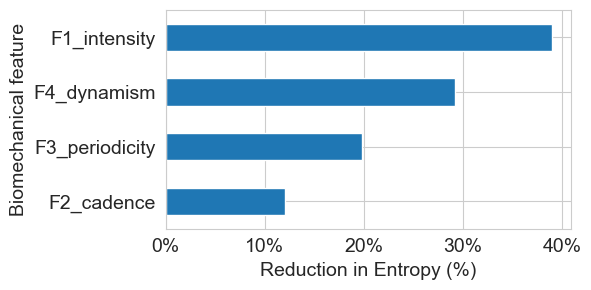

In [338]:
# %% Cell 99 – horizontal bar plot (ALL placements)
# -------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def plot_feat_imp(feat_importance, top_n=None):
    """
    Draw a horizontal bar chart of feature importances.
    If *top_n* is given, only the top-N rows are plotted.
    """
    df = feat_importance.copy()
    df['Importance_pct'] = df['Importance'] * 100   # → %

    if top_n is not None:
        df = df.head(top_n)

    ax = (df
          .sort_values('Importance_pct', ascending=True)
          .plot.barh(
              x='Feature', y='Importance_pct',
              figsize=(6, 3), legend=False
          ))

    # Axis labels
    ax.set_xlabel("Reduction in Entropy (%)", fontsize=14)
    ax.set_ylabel("Biomechanical feature", fontsize=14)

    # Tick label size (x and y ticks)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Format x-axis as percentages
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

    plt.tight_layout()
    return ax

ax = plot_feat_imp(feat_imp, top_n=5)
#ax.set_title("Random Forest – feature importance (ALL placements)")
plt.savefig('images/RF_feature_importance(ALL_placements).png')
plt.show()


### SHAP FFP global

ExactExplainer explainer: 651it [03:08,  3.38it/s]                         


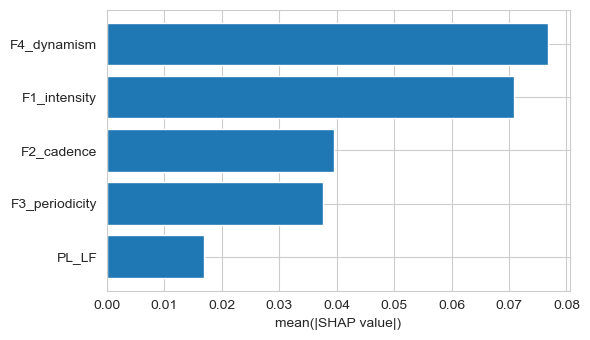


— all sensors • Robust • sample #460 —
Robust: 0.619
Semi-frail: 0.273
Frail: 0.108


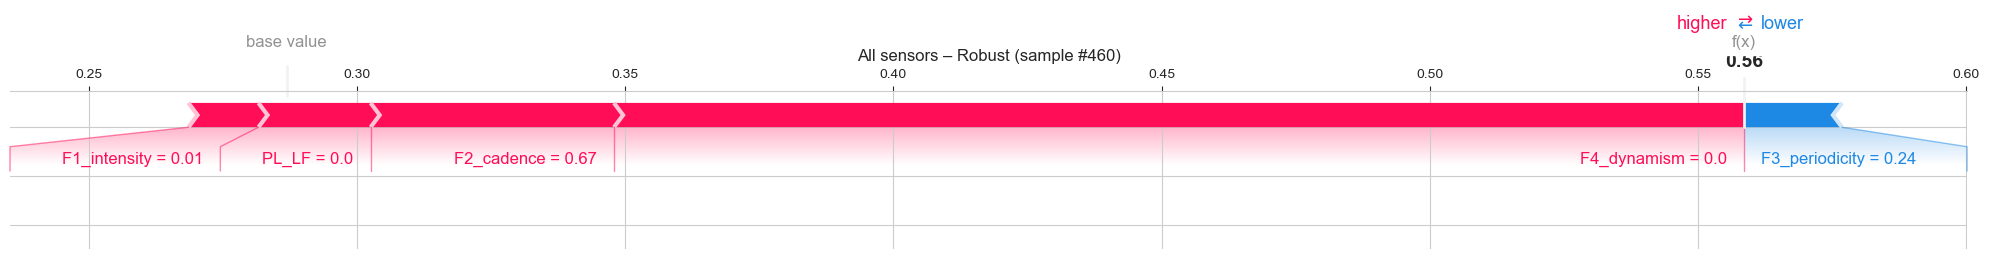

• saved images/force_Robust_idx460_AllSensors.png

— all sensors • Semi-frail • sample #475 —
Robust: 0.090
Semi-frail: 0.910
Frail: 0.000


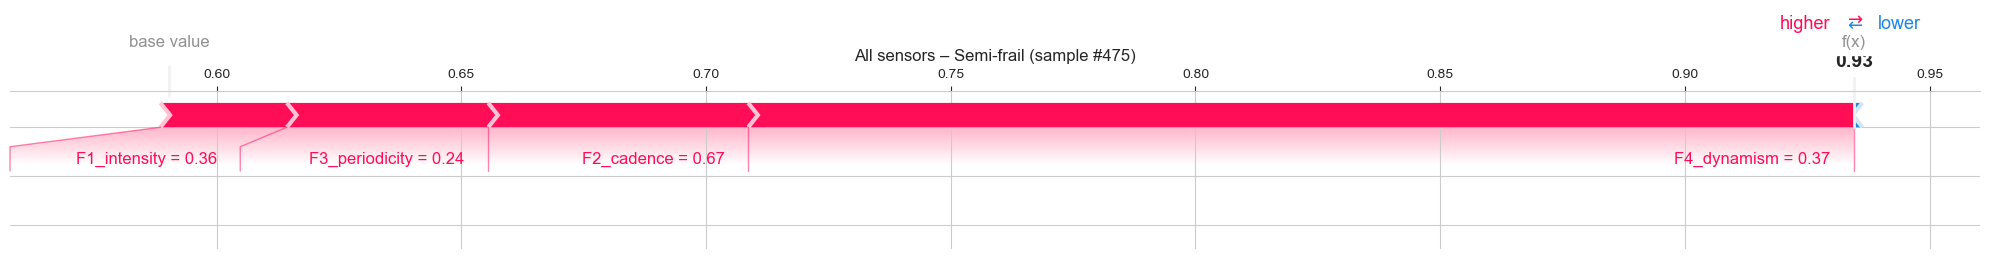

• saved images/force_Semifrail_idx475_AllSensors.png

— all sensors • Frail • sample #239 —
Robust: 0.061
Semi-frail: 0.086
Frail: 0.853


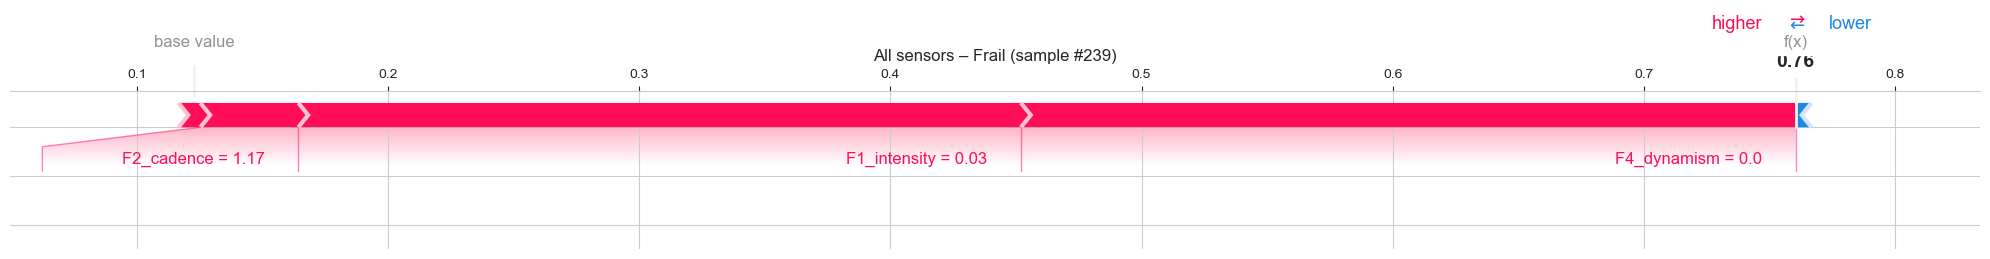

• saved images/force_Frail_idx239_AllSensors.png

✅ SHAP FFP-analysis finished – clinical labels displayed.


In [339]:
# %% Cell 101  – SHAP (all sensors pooled, FFP task) – 5 features, warning-free
# --------------------------------------------------------------------------------
import shap, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("images", exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# 0)  Clinical labels for FFP classes
# ────────────────────────────────────────────────────────────────────────────────
FFP_LABELS = {0: "Robust", 1: "Semi-frail", 2: "Frail"}

# -------------------------------------------------------------------------------
# 1)  Column order used during training  (5 biomech  +  5 PL_* flags)
# -------------------------------------------------------------------------------
all_cols   = (['F1_intensity','F2_cadence','F3_periodicity',
               'F4_dynamism'] +
              ['PL_LF','PL_LW','PL_RF','PL_RW','PL_SA'])
core_feats = all_cols[:5]                      # features we want to display

# -------------------------------------------------------------------------------
# 2)  The full train / test matrices are already in memory (Cell 35)
# -------------------------------------------------------------------------------
X_tr_df = pd.DataFrame(X_train, columns=all_cols)
X_te_df = pd.DataFrame(X_test , columns=all_cols)
true_ffp = meta_test['FFP'].astype(int).values        # FFP labels 0/1/2

# -------------------------------------------------------------------------------
# 3)  Helper: convert FAC probabilities → FFP probabilities
# -------------------------------------------------------------------------------
gb_model = models['Random Forest']                # trained on FAC (1–5)

def fac2ffp(p_fac, classes):
    idx = {c:i for i,c in enumerate(classes)}
    p0  = p_fac[:, idx[5]]
    p1  = p_fac[:, idx[3]] + p_fac[:, idx[4]]
    p2  = p_fac[:, idx[1]] + p_fac[:, idx[2]]
    return np.vstack([p0,p1,p2]).T

def gb_proba_ffp_np(X):
    p_fac = gb_model.predict_proba(np.asarray(X))
    return fac2ffp(p_fac, gb_model.classes_)

# -------------------------------------------------------------------------------
# 4)  Build SHAP explainer
# -------------------------------------------------------------------------------
explainer = shap.Explainer(
    gb_proba_ffp_np,                # wrapped FFP predictor
    X_tr_df,                        # background
    feature_names = all_cols,
    output_names  = [FFP_LABELS[i] for i in range(3)]  # use clinical labels
)
shap_vals = explainer(X_te_df)

# -------------------------------------------------------------------------------
# 5)  Global importance bar-plot  (only F1…F5)
# -------------------------------------------------------------------------------
mean_abs = np.abs(shap_vals.values).mean(axis=(0,2))[:5]
imp_df   = (pd.DataFrame({'feature':core_feats,
                          'mean(|SHAP|)':mean_abs})
            .sort_values('mean(|SHAP|)',ascending=False))

plt.figure(figsize=(6,3.5))
plt.barh(imp_df.feature[::-1], imp_df['mean(|SHAP|)'][::-1])
plt.xlabel('mean(|SHAP value|)')
#plt.title('Global importance – all sensors pooled (GB, FFP task)')
plt.tight_layout()
plt.savefig('images/global_importance_gb_FFP_AllSensors.png')
plt.show()

# -------------------------------------------------------------------------------
# 6)  One force-plot per FFP class (labeled with clinical names)
# -------------------------------------------------------------------------------
y_pred_ffp = gb_proba_ffp_np(X_te_df).argmax(axis=1)
examples   = {}
for f in (0,1,2):
    good = np.where((y_pred_ffp == true_ffp) & (true_ffp == f))[0]
    if len(good):
        examples[f] = np.random.choice(good)
    else:
        alt = np.where(true_ffp == f)[0]
        examples[f] = alt[0] if len(alt) else None

for f, idx in examples.items():
    label = FFP_LABELS[f]
    print(f"\n— all sensors • {label} • sample #{idx} —")
    probs = gb_proba_ffp_np(X_te_df.iloc[[idx]])[0]
    for k,p in enumerate(probs):
        print(f"{FFP_LABELS[k]}: {p:.3f}")

    feat_vals = X_te_df.iloc[[idx], :5].round(2)

    shap.force_plot(
        shap_vals.base_values[idx, f],
        shap_vals.values[idx, :5, f].reshape(1,-1),
        feat_vals,
        matplotlib=True, show=False
    )
    plt.title(f"All sensors – {label} (sample #{idx})")
    plt.tight_layout()
    out = f"images/force_{label.replace('-','')}_idx{idx}_AllSensors.png"
    plt.savefig(out)
    plt.show()
    print(f"• saved {out}")

print("\n✅ SHAP FFP-analysis finished – clinical labels displayed.")


### SHAP feature impact – probability of being Frail

ExactExplainer explainer: 651it [03:41,  2.81it/s]                         


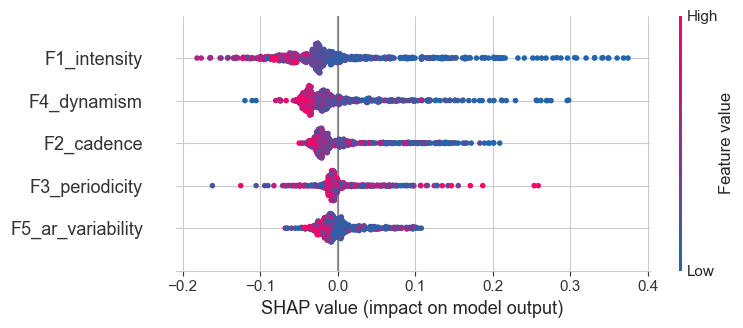

In [70]:
# %% Cell 101  – SHAP (all sensors pooled, FFP task) – 5 features, warning-free
# --------------------------------------------------------------------------------
import shap, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("images", exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# 0)  Clinical labels for FFP classes
# ────────────────────────────────────────────────────────────────────────────────
FFP_LABELS = {0: "Robust", 1: "Semi-frail", 2: "Frail"}

# -------------------------------------------------------------------------------
# 1)  Column order used during training  (5 biomech  +  5 PL_* flags)
# -------------------------------------------------------------------------------
all_cols   = (['F1_intensity','F2_cadence','F3_periodicity',
               'F4_dynamism','F5_ar_variability'] +
              ['PL_LF','PL_LW','PL_RF','PL_RW','PL_SA'])
core_feats = all_cols[:5]                      # features we want to display

# -------------------------------------------------------------------------------
# 2)  The full train / test matrices are already in memory (Cell 35)
# -------------------------------------------------------------------------------
X_tr_df = pd.DataFrame(X_train, columns=all_cols)
X_te_df = pd.DataFrame(X_test , columns=all_cols)
true_ffp = meta_test['FFP'].astype(int).values        # FFP labels 0/1/2

# -------------------------------------------------------------------------------
# 3)  Helper: convert FAC probabilities → FFP probabilities
# -------------------------------------------------------------------------------
gb_model = models['Random Forest']                # trained on FAC (1–5)

def fac2ffp(p_fac, classes):
    idx = {c:i for i,c in enumerate(classes)}
    p0  = p_fac[:, idx[5]]
    p1  = p_fac[:, idx[3]] + p_fac[:, idx[4]]
    p2  = p_fac[:, idx[1]] + p_fac[:, idx[2]]
    return np.vstack([p0,p1,p2]).T

def gb_proba_ffp_np(X):
    p_fac = gb_model.predict_proba(np.asarray(X))
    return fac2ffp(p_fac, gb_model.classes_)

# -------------------------------------------------------------------------------
# 4)  Build SHAP explainer
# -------------------------------------------------------------------------------
explainer = shap.Explainer(
    gb_proba_ffp_np,                # wrapped FFP predictor
    X_tr_df,                        # background
    feature_names = all_cols,
    output_names  = [FFP_LABELS[i] for i in range(3)]  # use clinical labels
)
shap_vals = explainer(X_te_df)

# -------------------------------------------------------------------------------
# 5)  SHAP beeswarm – only the 5 biomechanical features
# -------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib as mpl

# 0) build a custom two-colour LinearSegmentedColormap
blue_pink = mpl.colors.LinearSegmentedColormap.from_list(
    'blue_pink',
    ['#2166ac',     # deep blue  (low feature value)
     '#ff0066'],    # light pink (high feature value)
    N=256
)


# 1) choose the output node you care about
target_class = 2                                    # 0-Robust • 1-Semi-frail • 2-Frail

# 2) slice the Explanation down to that class …
shap_frail = shap_vals[:, :, target_class]          #   shape: (n_samples, n_features)

# 3) … and then slice *columns* 0-4  (= F1 … F5) to remove all PL_* features
bio_cols    = list(range(5))                        # first 5 columns in `all_cols`
shap_bio    = shap_frail[:, bio_cols]               # still an Explanation object

# 4) build the beeswarm
plt.figure(figsize=(5, 5.5))                        # shorter y-axis now

shap.summary_plot(
    shap_bio,
    features      = X_te_df.iloc[:, bio_cols],      # colour bar uses raw values of F1…F5
    feature_names = core_feats,                     # ['F1_intensity', …, 'F5_ar_variability']
    #cmap          = mpl.cm.coolwarm,
    cmap          = blue_pink,
    show          = False
)

plt.axvline(0, color="grey", lw=0.8)
#plt.title("SHAP feature impact – probability of being Frail", pad=12)
plt.tight_layout()
plt.savefig("images/SHAP_feature_impact–probability_of_being_Frail.png", dpi=300)
plt.show()




### SHAP feature impact – probability of being Semi-Frail

ExactExplainer explainer: 651it [03:41,  2.80it/s]                         


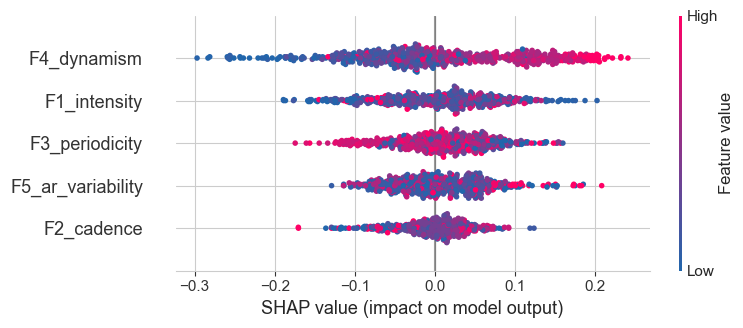

In [71]:
# %% Cell 101  – SHAP (all sensors pooled, FFP task) – 5 features, warning-free
# --------------------------------------------------------------------------------
import shap, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("images", exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# 0)  Clinical labels for FFP classes
# ────────────────────────────────────────────────────────────────────────────────
FFP_LABELS = {0: "Robust", 1: "Semi-frail", 2: "Frail"}

# -------------------------------------------------------------------------------
# 1)  Column order used during training  (5 biomech  +  5 PL_* flags)
# -------------------------------------------------------------------------------
all_cols   = (['F1_intensity','F2_cadence','F3_periodicity',
               'F4_dynamism','F5_ar_variability'] +
              ['PL_LF','PL_LW','PL_RF','PL_RW','PL_SA'])
core_feats = all_cols[:5]                      # features we want to display

# -------------------------------------------------------------------------------
# 2)  The full train / test matrices are already in memory (Cell 35)
# -------------------------------------------------------------------------------
X_tr_df = pd.DataFrame(X_train, columns=all_cols)
X_te_df = pd.DataFrame(X_test , columns=all_cols)
true_ffp = meta_test['FFP'].astype(int).values        # FFP labels 0/1/2

# -------------------------------------------------------------------------------
# 3)  Helper: convert FAC probabilities → FFP probabilities
# -------------------------------------------------------------------------------
gb_model = models['Random Forest']                # trained on FAC (1–5)

def fac2ffp(p_fac, classes):
    idx = {c:i for i,c in enumerate(classes)}
    p0  = p_fac[:, idx[5]]
    p1  = p_fac[:, idx[3]] + p_fac[:, idx[4]]
    p2  = p_fac[:, idx[1]] + p_fac[:, idx[2]]
    return np.vstack([p0,p1,p2]).T

def gb_proba_ffp_np(X):
    p_fac = gb_model.predict_proba(np.asarray(X))
    return fac2ffp(p_fac, gb_model.classes_)

# -------------------------------------------------------------------------------
# 4)  Build SHAP explainer
# -------------------------------------------------------------------------------
explainer = shap.Explainer(
    gb_proba_ffp_np,                # wrapped FFP predictor
    X_tr_df,                        # background
    feature_names = all_cols,
    output_names  = [FFP_LABELS[i] for i in range(3)]  # use clinical labels
)
shap_vals = explainer(X_te_df)

# -------------------------------------------------------------------------------
# 5)  SHAP beeswarm – only the 5 biomechanical features
# -------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib as mpl

# 0) build a custom two-colour LinearSegmentedColormap
blue_pink = mpl.colors.LinearSegmentedColormap.from_list(
    'blue_pink',
    ['#2166ac',     # deep blue  (low feature value)
     '#ff0066'],    # light pink (high feature value)
    N=256
)


# 1) choose the output node you care about
target_class = 1                                    # 0-Robust • 1-Semi-frail • 2-Frail

# 2) slice the Explanation down to that class …
shap_frail = shap_vals[:, :, target_class]          #   shape: (n_samples, n_features)

# 3) … and then slice *columns* 0-4  (= F1 … F5) to remove all PL_* features
bio_cols    = list(range(5))                        # first 5 columns in `all_cols`
shap_bio    = shap_frail[:, bio_cols]               # still an Explanation object

# 4) build the beeswarm
plt.figure(figsize=(5, 5.5))                        # shorter y-axis now

shap.summary_plot(
    shap_bio,
    features      = X_te_df.iloc[:, bio_cols],      # colour bar uses raw values of F1…F5
    feature_names = core_feats,                     # ['F1_intensity', …, 'F5_ar_variability']
    #cmap          = mpl.cm.coolwarm,
    cmap          = blue_pink,
    show          = False
)

plt.axvline(0, color="grey", lw=0.8)
#plt.title("SHAP feature impact – probability of being Semi-Frail", pad=12)
plt.tight_layout()
plt.savefig("images/SHAP_feature_impact–probability_of_being_Semi-Frail.png", dpi=300)
plt.show()




### SHAP feature impact – probability of being Robust

ExactExplainer explainer: 651it [02:27,  4.16it/s]                         


IndexError: list index out of range

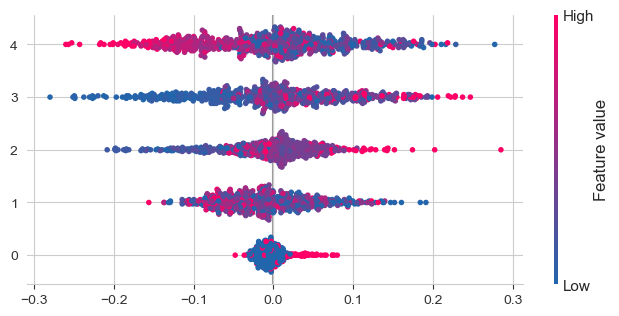

In [72]:
# %% Cell 101  – SHAP (all sensors pooled, FFP task) – 5 features, warning-free
# --------------------------------------------------------------------------------
import shap, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("images", exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# 0)  Clinical labels for FFP classes
# ────────────────────────────────────────────────────────────────────────────────
FFP_LABELS = {0: "Robust", 1: "Semi-frail", 2: "Frail"}

# -------------------------------------------------------------------------------
# 1)  Column order used during training  (5 biomech  +  5 PL_* flags)
# -------------------------------------------------------------------------------
all_cols   = (['F1_intensity','F2_cadence','F3_periodicity',
               'F4_dynamism'] +
              ['PL_LF','PL_LW','PL_RF','PL_RW','PL_SA'])
core_feats = all_cols[:4]                      # features we want to display

# -------------------------------------------------------------------------------
# 2)  The full train / test matrices are already in memory (Cell 35)
# -------------------------------------------------------------------------------
X_tr_df = pd.DataFrame(X_train, columns=all_cols)
X_te_df = pd.DataFrame(X_test , columns=all_cols)
true_ffp = meta_test['FFP'].astype(int).values        # FFP labels 0/1/2

# -------------------------------------------------------------------------------
# 3)  Helper: convert FAC probabilities → FFP probabilities
# -------------------------------------------------------------------------------
gb_model = models['Random Forest']                # trained on FAC (1–5)

def fac2ffp(p_fac, classes):
    idx = {c:i for i,c in enumerate(classes)}
    p0  = p_fac[:, idx[5]]
    p1  = p_fac[:, idx[3]] + p_fac[:, idx[4]]
    p2  = p_fac[:, idx[1]] + p_fac[:, idx[2]]
    return np.vstack([p0,p1,p2]).T

def gb_proba_ffp_np(X):
    p_fac = gb_model.predict_proba(np.asarray(X))
    return fac2ffp(p_fac, gb_model.classes_)

# -------------------------------------------------------------------------------
# 4)  Build SHAP explainer
# -------------------------------------------------------------------------------
explainer = shap.Explainer(
    gb_proba_ffp_np,                # wrapped FFP predictor
    X_tr_df,                        # background
    feature_names = all_cols,
    output_names  = [FFP_LABELS[i] for i in range(3)]  # use clinical labels
)
shap_vals = explainer(X_te_df)

# -------------------------------------------------------------------------------
# 5)  SHAP beeswarm – only the 5 biomechanical features
# -------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib as mpl

# 0) build a custom two-colour LinearSegmentedColormap
blue_pink = mpl.colors.LinearSegmentedColormap.from_list(
    'blue_pink',
    ['#2166ac',     # deep blue  (low feature value)
     '#ff0066'],    # light pink (high feature value)
    N=256
)


# 1) choose the output node you care about
target_class = 0                                    # 0-Robust • 1-Semi-frail • 2-Frail

# 2) slice the Explanation down to that class …
shap_frail = shap_vals[:, :, target_class]          #   shape: (n_samples, n_features)

# 3) … and then slice *columns* 0-4  (= F1 … F5) to remove all PL_* features
bio_cols    = list(range(5))                        # first 5 columns in `all_cols`
shap_bio    = shap_frail[:, bio_cols]               # still an Explanation object

# 4) build the beeswarm
plt.figure(figsize=(5, 5.5))                        # shorter y-axis now

shap.summary_plot(
    shap_bio,
    features      = X_te_df.iloc[:, bio_cols],      # colour bar uses raw values of F1…F5
    feature_names = core_feats,                     # ['F1_intensity', …, 'F5_ar_variability']
    #cmap          = mpl.cm.coolwarm,
    cmap          = blue_pink,
    show          = False
)

plt.axvline(0, color="grey", lw=0.8)
#plt.title("SHAP feature impact – probability of being Robust", pad=12)
plt.tight_layout()
plt.savefig("images/SHAP_feature_impact–probability_of_being_Robust.png", dpi=300)
plt.show()




## SHAP FAC global

ExactExplainer explainer: 651it [02:31,  4.17it/s]                         


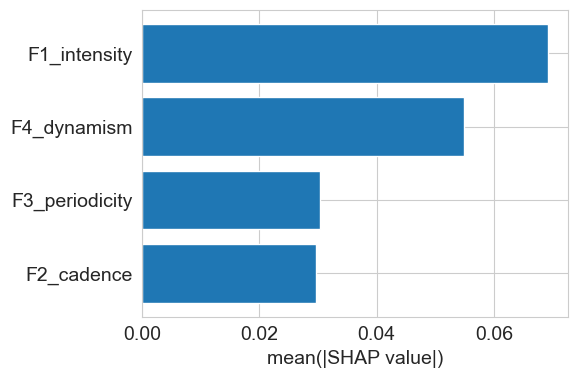

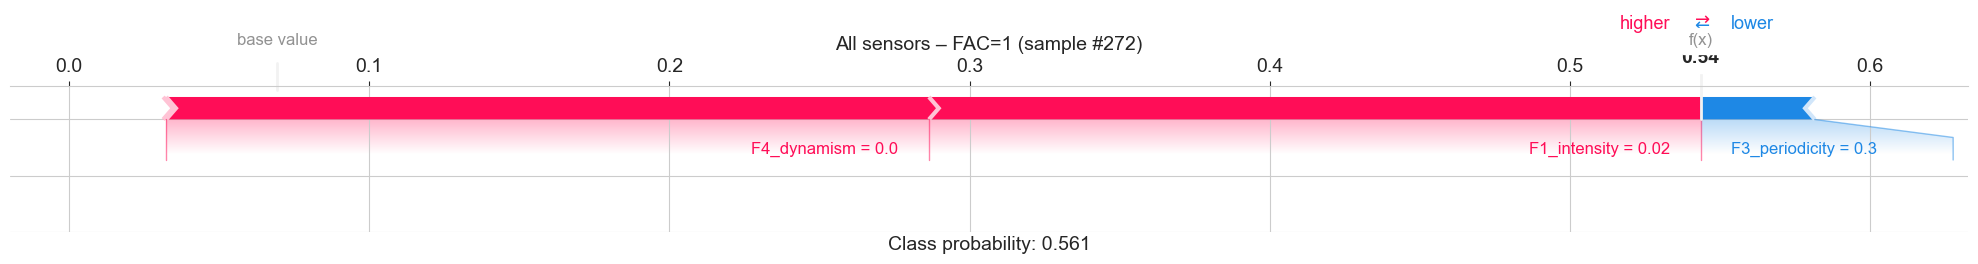

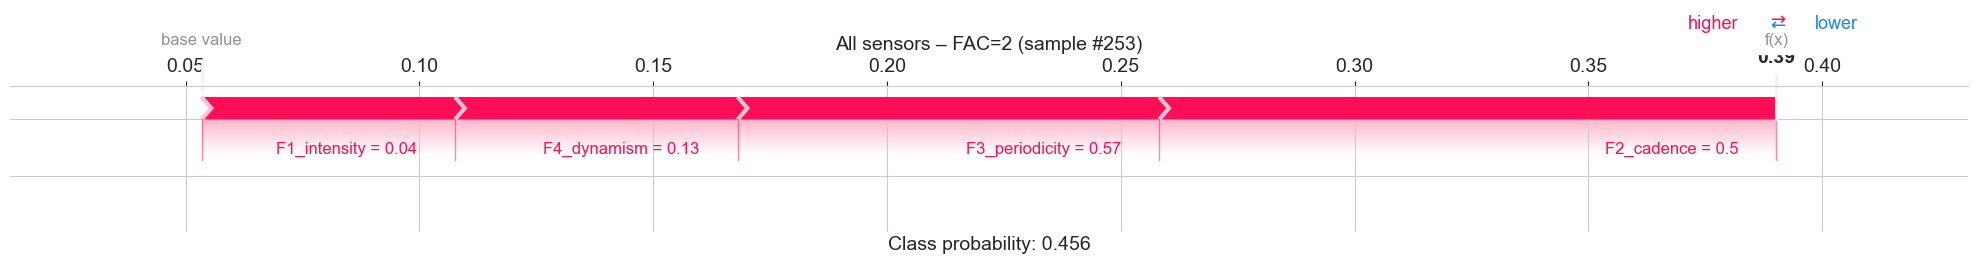

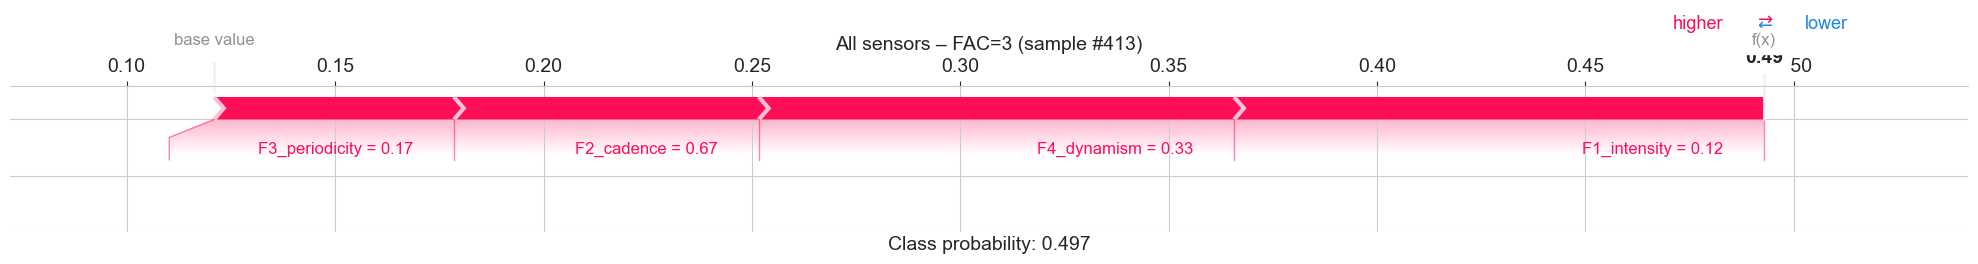

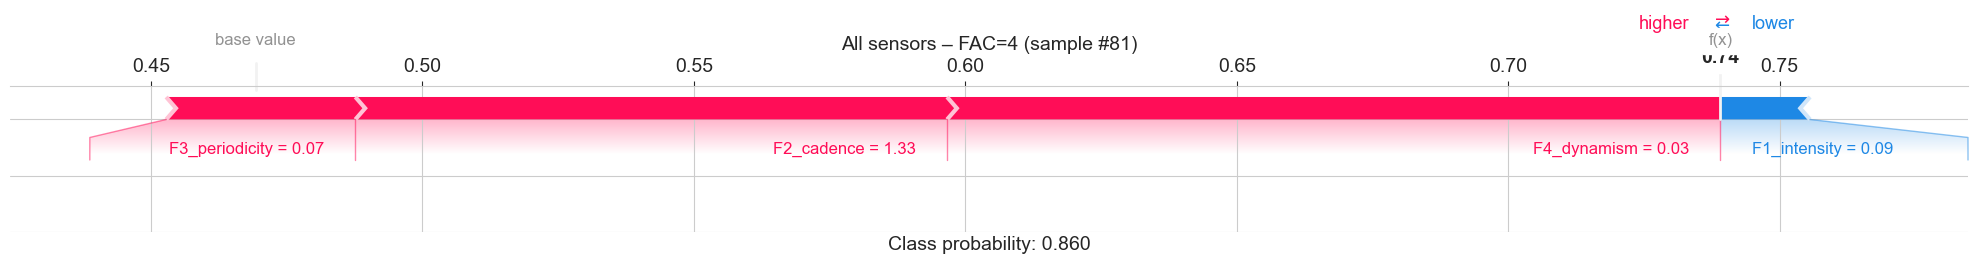

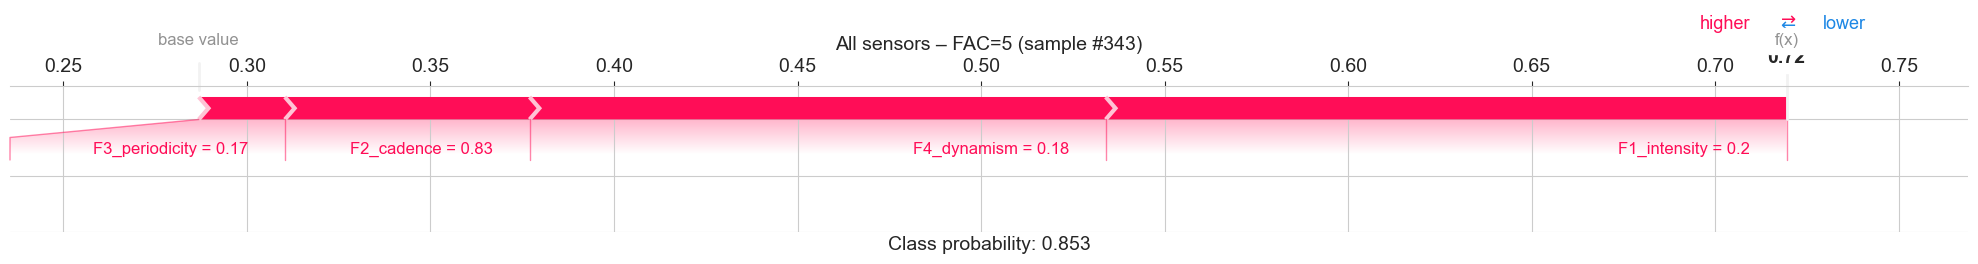


✅ SHAP analysis finished – only F1–F4 features used.


In [343]:
# %% Cell 100 d – SHAP (all sensors pooled, FAC task) – warning-free
# ---------------------------------------------------------------
import shap, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("images", exist_ok=True)

# full training layout (4 biomech features only)
all_cols  = ['F1_intensity','F2_cadence','F3_periodicity','F4_dynamism',
             'PL_LF','PL_LW','PL_RF','PL_RW','PL_SA']
core_feats = all_cols[:4]  # Only F1–F4

# full train / test matrices prepared in Cell 35
X_tr_df = pd.DataFrame(X_train, columns=all_cols)
X_te_df = pd.DataFrame(X_test , columns=all_cols)
y_te    = y_test.copy()

gb_model = models['Random Forest']  # already fitted

# wrapper strips DataFrame -> NumPy to silence sklearn
def gb_proba_np(X):
    return gb_model.predict_proba(np.asarray(X))

explainer = shap.Explainer(
    gb_proba_np,
    X_tr_df,
    feature_names=all_cols,
    output_names=[f"FAC={c}" for c in gb_model.classes_]
)
shap_vals = explainer(X_te_df)

# global importance (F1–F4 only)
mean_abs = np.abs(shap_vals.values).mean(axis=(0, 2))[:4]
imp_df   = (pd.DataFrame({
                'feature': core_feats,
                'mean(|SHAP value|)': mean_abs
            })
            .sort_values('mean(|SHAP value|)', ascending=False))

plt.figure(figsize=(6, 4))
plt.barh(imp_df.feature.iloc[::-1],
         imp_df['mean(|SHAP value|)'].iloc[::-1])
plt.xlabel('mean(|SHAP value|)', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.savefig('images/global_importance_gb_FAC_AllSensors.png')
plt.show()

# one force-plot / FAC class, now with class probability label
y_pred = gb_model.predict(X_test)
examples = {}

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

for fac in gb_model.classes_:
    ok = np.where((y_pred == y_te) & (y_te == fac))[0]
    if len(ok):
        examples[fac] = np.random.choice(ok)
    else:
        alt = np.where(y_te == fac)[0]
        examples[fac] = alt[0] if len(alt) else None

for fac, idx in examples.items():
    cls_idx   = list(gb_model.classes_).index(fac)
    feat_vals = X_te_df.iloc[[idx], :4].round(2)
    prob = gb_model.predict_proba(X_test[[idx]])[0][cls_idx]

    shap.force_plot(
        shap_vals.base_values[idx, cls_idx],
        shap_vals.values[idx, :4, cls_idx].reshape(1, -1),
        feat_vals,
        matplotlib=True, show=False
    )
    plt.title(f"All sensors – FAC={fac} (sample #{idx})", fontsize=14)
    plt.figtext(0.5, 0.01, f"Class probability: {prob:.3f}", ha='center', fontsize=14)
    plt.tight_layout()
    out = f"images/force_FAC{fac}_idx{idx}_AllSensors.png"
    plt.savefig(out)
    plt.show()

print("\n✅ SHAP analysis finished – only F1–F4 features used.")


### SHAP feature impact – probability of being FAC-1 (lowest mobility)

ExactExplainer explainer: 651it [02:16,  4.57it/s]                         


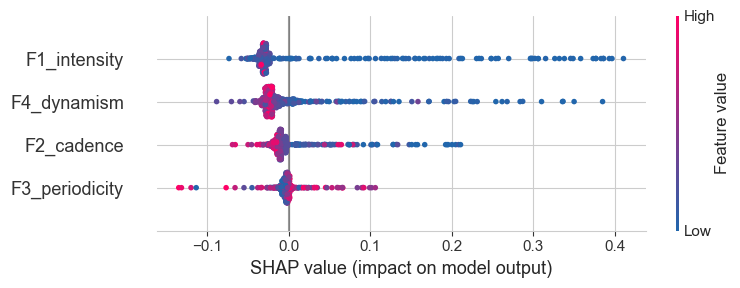


✅ SHAP FAC-analysis finished – biomechanical features only.


In [344]:
# %% Cell 101  – SHAP (all sensors pooled, FAC task) – 5 features, warning-free
# --------------------------------------------------------------------------------
import shap, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("images", exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# 0)  Clinical labels for FAC classes
# ────────────────────────────────────────────────────────────────────────────────
FAC_LABELS = {1: "FAC-1 (very low)",
              2: "FAC-2 (low)",
              3: "FAC-3 (moderate)",
              4: "FAC-4 (high)",
              5: "FAC-5 (highest)"}


# -------------------------------------------------------------------------------
# 1)  Column order used during training  (5 biomech  +  5 PL_* flags)
# -------------------------------------------------------------------------------
all_cols   = (['F1_intensity','F2_cadence','F3_periodicity',
               'F4_dynamism'] +
              ['PL_LF','PL_LW','PL_RF','PL_RW','PL_SA'])
core_feats = all_cols[:4]                      # features we want to display

# -------------------------------------------------------------------------------
# 2)  The full train / test matrices are already in memory (Cell 35)
# -------------------------------------------------------------------------------
X_tr_df = pd.DataFrame(X_train, columns=all_cols)
X_te_df = pd.DataFrame(X_test , columns=all_cols)
true_fac = meta_test['FAC'].astype(int).values        # FAC labels 1…5

# -------------------------------------------------------------------------------
# 3)  Grab the trained model (already fitted on FAC 1…5)
# -------------------------------------------------------------------------------
gb_model = models['Random Forest']             # classifier with .predict_proba()

# -------------------------------------------------------------------------------
# 4)  Build SHAP explainer  (directly on FAC, no mapping needed)
# -------------------------------------------------------------------------------
#   SHAP will discover the model type (tree) and pick TreeExplainer internally.

def gb_proba_np(X):
    """Wrapper so SHAP sees a plain callable → returns FAC probabilities."""
    return gb_model.predict_proba(np.asarray(X))

explainer = shap.Explainer(
    gb_proba_np,
    X_tr_df,
    feature_names = all_cols,
    output_names  = [FAC_LABELS[c] for c in gb_model.classes_] )
shap_vals = explainer(X_te_df)                 # shape: (n_samples, n_features, 5)

# -------------------------------------------------------------------------------
# 5)  SHAP beeswarm – biomechanical features only, for FAC-1 (lowest mobility)
# -------------------------------------------------------------------------------
import matplotlib as mpl

# 0) build a custom two-colour LinearSegmentedColormap
blue_pink = mpl.colors.LinearSegmentedColormap.from_list(
    'blue_pink',
    ['#2166ac',     # deep blue  (low feature value)
     '#ff0066'],    # light pink (high feature value)
    N=256
)

# 1) choose the output node: FAC value 1  → find its column index
fac_idx = {c:i for i,c in enumerate(gb_model.classes_)}
target_class = fac_idx[1]                      # FAC-1

# 2) slice to that class
shap_fac1 = shap_vals[:, :, target_class]

# 3) and slice to the first 5 feature columns (= F1…F5)
bio_cols  = list(range(4))
shap_bio  = shap_fac1[:, bio_cols]

# 4) build the beeswarm
plt.figure(figsize=(5, 5.5))
shap.summary_plot(
    shap_bio,
    features      = X_te_df.iloc[:, bio_cols],
    feature_names = core_feats,
    #cmap          = mpl.cm.coolwarm,
    cmap          = blue_pink,
    show          = False
)
plt.axvline(0, color="grey", lw=0.8)
#plt.title("SHAP feature impact – probability of being FAC-1 (lowest mobility)",
#          pad=12)
plt.tight_layout()
plt.savefig("images/summary_beeswarm_fac1_biomech_only.png", dpi=300)
plt.show()

print("\n✅ SHAP FAC-analysis finished – biomechanical features only.")


### SHAP feature impact – probability of being FAC-2


ExactExplainer explainer: 651it [02:36,  3.98it/s]                         


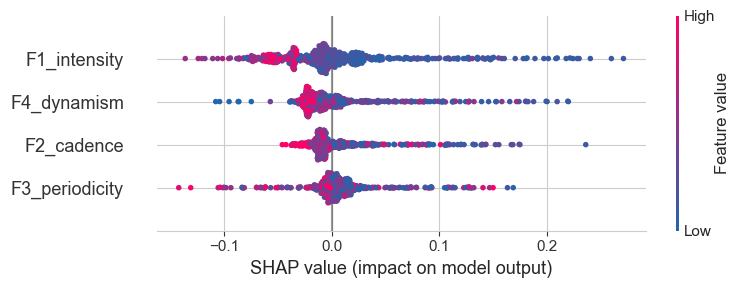


✅ SHAP FAC-analysis finished – biomechanical features only.


In [345]:
# %% Cell 101  – SHAP (all sensors pooled, FAC task) – 5 features, warning-free
# --------------------------------------------------------------------------------
import shap, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("images", exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# 0)  Clinical labels for FAC classes
# ────────────────────────────────────────────────────────────────────────────────
FAC_LABELS = {1: "FAC-1 (very low)",
              2: "FAC-2 (low)",
              3: "FAC-3 (moderate)",
              4: "FAC-4 (high)",
              5: "FAC-5 (highest)"}


# -------------------------------------------------------------------------------
# 1)  Column order used during training  (5 biomech  +  5 PL_* flags)
# -------------------------------------------------------------------------------
all_cols   = (['F1_intensity','F2_cadence','F3_periodicity',
               'F4_dynamism'] +
              ['PL_LF','PL_LW','PL_RF','PL_RW','PL_SA'])
core_feats = all_cols[:4]                      # features we want to display

# -------------------------------------------------------------------------------
# 2)  The full train / test matrices are already in memory (Cell 35)
# -------------------------------------------------------------------------------
X_tr_df = pd.DataFrame(X_train, columns=all_cols)
X_te_df = pd.DataFrame(X_test , columns=all_cols)
true_fac = meta_test['FAC'].astype(int).values        # FAC labels 1…5

# -------------------------------------------------------------------------------
# 3)  Grab the trained model (already fitted on FAC 1…5)
# -------------------------------------------------------------------------------
gb_model = models['Random Forest']             # classifier with .predict_proba()

# -------------------------------------------------------------------------------
# 4)  Build SHAP explainer  (directly on FAC, no mapping needed)
# -------------------------------------------------------------------------------
#   SHAP will discover the model type (tree) and pick TreeExplainer internally.

def gb_proba_np(X):
    """Wrapper so SHAP sees a plain callable → returns FAC probabilities."""
    return gb_model.predict_proba(np.asarray(X))

explainer = shap.Explainer(
    gb_proba_np,
    X_tr_df,
    feature_names = all_cols,
    output_names  = [FAC_LABELS[c] for c in gb_model.classes_] )
shap_vals = explainer(X_te_df)                 # shape: (n_samples, n_features, 5)

# -------------------------------------------------------------------------------
# 5)  SHAP beeswarm – biomechanical features only, for FAC-1 (lowest mobility)
# -------------------------------------------------------------------------------
import matplotlib as mpl

# 0) build a custom two-colour LinearSegmentedColormap
blue_pink = mpl.colors.LinearSegmentedColormap.from_list(
    'blue_pink',
    ['#2166ac',     # deep blue  (low feature value)
     '#ff0066'],    # light pink (high feature value)
    N=256
)

# 1) choose the output node: FAC value 1  → find its column index
fac_idx = {c:i for i,c in enumerate(gb_model.classes_)}
target_class = fac_idx[2]                      # FAC-1

# 2) slice to that class
shap_fac1 = shap_vals[:, :, target_class]

# 3) and slice to the first 5 feature columns (= F1…F5)
bio_cols  = list(range(4))
shap_bio  = shap_fac1[:, bio_cols]

# 4) build the beeswarm
plt.figure(figsize=(5, 5.5))
shap.summary_plot(
    shap_bio,
    features      = X_te_df.iloc[:, bio_cols],
    feature_names = core_feats,
    #cmap          = mpl.cm.coolwarm,
    cmap          = blue_pink,
    show          = False
)
plt.axvline(0, color="grey", lw=0.8)
#plt.title("SHAP feature impact – probability of being FAC-1 (lowest mobility)",
#          pad=12)
plt.tight_layout()
plt.savefig("images/summary_beeswarm_fac2_biomech_only.png", dpi=300)
plt.show()

print("\n✅ SHAP FAC-analysis finished – biomechanical features only.")


### SHAP feature impact – probability of being FAC-3


ExactExplainer explainer: 651it [02:18,  4.48it/s]                         


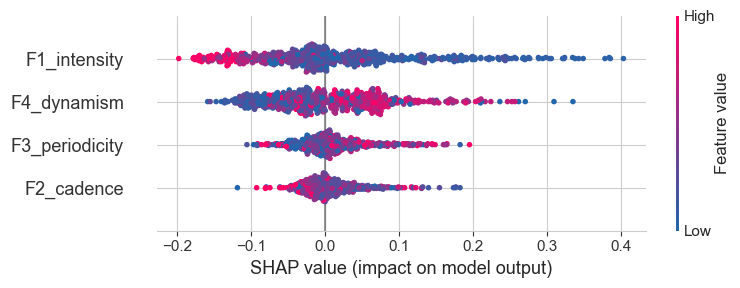


✅ SHAP FAC-analysis finished – biomechanical features only.


In [346]:
# %% Cell 101  – SHAP (all sensors pooled, FAC task) – 5 features, warning-free
# --------------------------------------------------------------------------------
import shap, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("images", exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# 0)  Clinical labels for FAC classes
# ────────────────────────────────────────────────────────────────────────────────
FAC_LABELS = {1: "FAC-1 (very low)",
              2: "FAC-2 (low)",
              3: "FAC-3 (moderate)",
              4: "FAC-4 (high)",
              5: "FAC-5 (highest)"}


# -------------------------------------------------------------------------------
# 1)  Column order used during training  (5 biomech  +  5 PL_* flags)
# -------------------------------------------------------------------------------
all_cols   = (['F1_intensity','F2_cadence','F3_periodicity',
               'F4_dynamism'] +
              ['PL_LF','PL_LW','PL_RF','PL_RW','PL_SA'])
core_feats = all_cols[:4]                      # features we want to display

# -------------------------------------------------------------------------------
# 2)  The full train / test matrices are already in memory (Cell 35)
# -------------------------------------------------------------------------------
X_tr_df = pd.DataFrame(X_train, columns=all_cols)
X_te_df = pd.DataFrame(X_test , columns=all_cols)
true_fac = meta_test['FAC'].astype(int).values        # FAC labels 1…5

# -------------------------------------------------------------------------------
# 3)  Grab the trained model (already fitted on FAC 1…5)
# -------------------------------------------------------------------------------
gb_model = models['Random Forest']             # classifier with .predict_proba()

# -------------------------------------------------------------------------------
# 4)  Build SHAP explainer  (directly on FAC, no mapping needed)
# -------------------------------------------------------------------------------
#   SHAP will discover the model type (tree) and pick TreeExplainer internally.

def gb_proba_np(X):
    """Wrapper so SHAP sees a plain callable → returns FAC probabilities."""
    return gb_model.predict_proba(np.asarray(X))

explainer = shap.Explainer(
    gb_proba_np,
    X_tr_df,
    feature_names = all_cols,
    output_names  = [FAC_LABELS[c] for c in gb_model.classes_] )
shap_vals = explainer(X_te_df)                 # shape: (n_samples, n_features, 5)

# -------------------------------------------------------------------------------
# 5)  SHAP beeswarm – biomechanical features only, for FAC-1 (lowest mobility)
# -------------------------------------------------------------------------------
import matplotlib as mpl

# 0) build a custom two-colour LinearSegmentedColormap
blue_pink = mpl.colors.LinearSegmentedColormap.from_list(
    'blue_pink',
    ['#2166ac',     # deep blue  (low feature value)
     '#ff0066'],    # light pink (high feature value)
    N=256
)

# 1) choose the output node: FAC value 1  → find its column index
fac_idx = {c:i for i,c in enumerate(gb_model.classes_)}
target_class = fac_idx[3]                      # FAC-1

# 2) slice to that class
shap_fac1 = shap_vals[:, :, target_class]

# 3) and slice to the first 5 feature columns (= F1…F5)
bio_cols  = list(range(4))
shap_bio  = shap_fac1[:, bio_cols]

# 4) build the beeswarm
plt.figure(figsize=(5, 5.5))
shap.summary_plot(
    shap_bio,
    features      = X_te_df.iloc[:, bio_cols],
    feature_names = core_feats,
    #cmap          = mpl.cm.coolwarm,
    cmap          = blue_pink,
    show          = False
)
plt.axvline(0, color="grey", lw=0.8)
#plt.title("SHAP feature impact – probability of being FAC-1 (lowest mobility)",
#          pad=12)
plt.tight_layout()
plt.savefig("images/summary_beeswarm_fac3_biomech_only.png", dpi=300)
plt.show()

print("\n✅ SHAP FAC-analysis finished – biomechanical features only.")


### SHAP feature impact – probability of being FAC-4


ExactExplainer explainer: 651it [02:23,  4.33it/s]                         


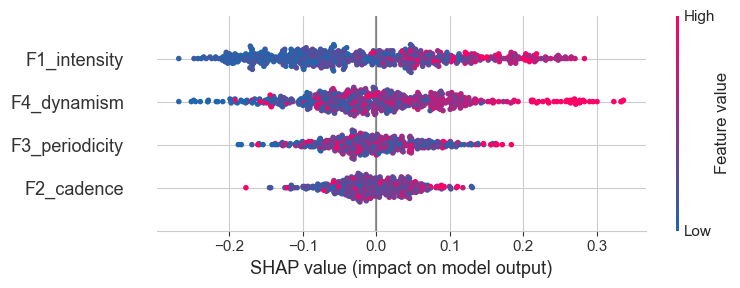


✅ SHAP FAC-analysis finished – biomechanical features only.


In [347]:
# %% Cell 101  – SHAP (all sensors pooled, FAC task) – 5 features, warning-free
# --------------------------------------------------------------------------------
import shap, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("images", exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# 0)  Clinical labels for FAC classes
# ────────────────────────────────────────────────────────────────────────────────
FAC_LABELS = {1: "FAC-1 (very low)",
              2: "FAC-2 (low)",
              3: "FAC-3 (moderate)",
              4: "FAC-4 (high)",
              5: "FAC-5 (highest)"}


# -------------------------------------------------------------------------------
# 1)  Column order used during training  (5 biomech  +  5 PL_* flags)
# -------------------------------------------------------------------------------
all_cols   = (['F1_intensity','F2_cadence','F3_periodicity',
               'F4_dynamism'] +
              ['PL_LF','PL_LW','PL_RF','PL_RW','PL_SA'])
core_feats = all_cols[:4]                      # features we want to display

# -------------------------------------------------------------------------------
# 2)  The full train / test matrices are already in memory (Cell 35)
# -------------------------------------------------------------------------------
X_tr_df = pd.DataFrame(X_train, columns=all_cols)
X_te_df = pd.DataFrame(X_test , columns=all_cols)
true_fac = meta_test['FAC'].astype(int).values        # FAC labels 1…5

# -------------------------------------------------------------------------------
# 3)  Grab the trained model (already fitted on FAC 1…5)
# -------------------------------------------------------------------------------
gb_model = models['Random Forest']             # classifier with .predict_proba()

# -------------------------------------------------------------------------------
# 4)  Build SHAP explainer  (directly on FAC, no mapping needed)
# -------------------------------------------------------------------------------
#   SHAP will discover the model type (tree) and pick TreeExplainer internally.

def gb_proba_np(X):
    """Wrapper so SHAP sees a plain callable → returns FAC probabilities."""
    return gb_model.predict_proba(np.asarray(X))

explainer = shap.Explainer(
    gb_proba_np,
    X_tr_df,
    feature_names = all_cols,
    output_names  = [FAC_LABELS[c] for c in gb_model.classes_] )
shap_vals = explainer(X_te_df)                 # shape: (n_samples, n_features, 5)

# -------------------------------------------------------------------------------
# 5)  SHAP beeswarm – biomechanical features only, for FAC-1 (lowest mobility)
# -------------------------------------------------------------------------------
import matplotlib as mpl

# 0) build a custom two-colour LinearSegmentedColormap
blue_pink = mpl.colors.LinearSegmentedColormap.from_list(
    'blue_pink',
    ['#2166ac',     # deep blue  (low feature value)
     '#ff0066'],    # light pink (high feature value)
    N=256
)

# 1) choose the output node: FAC value 1  → find its column index
fac_idx = {c:i for i,c in enumerate(gb_model.classes_)}
target_class = fac_idx[4]                      # FAC-1

# 2) slice to that class
shap_fac1 = shap_vals[:, :, target_class]

# 3) and slice to the first 5 feature columns (= F1…F5)
bio_cols  = list(range(4))
shap_bio  = shap_fac1[:, bio_cols]

# 4) build the beeswarm
plt.figure(figsize=(5, 5.5))
shap.summary_plot(
    shap_bio,
    features      = X_te_df.iloc[:, bio_cols],
    feature_names = core_feats,
    #cmap          = mpl.cm.coolwarm,
    cmap          = blue_pink,
    show          = False
)
plt.axvline(0, color="grey", lw=0.8)
#plt.title("SHAP feature impact – probability of being FAC-1 (lowest mobility)",
#          pad=12)
plt.tight_layout()
plt.savefig("images/summary_beeswarm_fac4_biomech_only.png", dpi=300)
plt.show()

print("\n✅ SHAP FAC-analysis finished – biomechanical features only.")


### SHAP feature impact – probability of being FAC-5


ExactExplainer explainer: 651it [02:21,  4.26it/s]                         


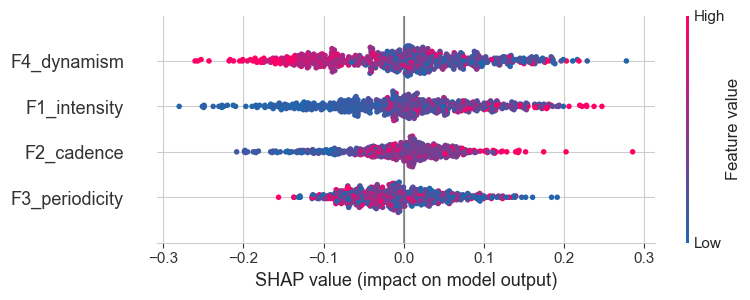


✅ SHAP FAC-analysis finished – biomechanical features only.


In [73]:
# %% Cell 101  – SHAP (all sensors pooled, FAC task) – 5 features, warning-free
# --------------------------------------------------------------------------------
import shap, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("images", exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# 0)  Clinical labels for FAC classes
# ────────────────────────────────────────────────────────────────────────────────
FAC_LABELS = {1: "FAC-1 (very low)",
              2: "FAC-2 (low)",
              3: "FAC-3 (moderate)",
              4: "FAC-4 (high)",
              5: "FAC-5 (highest)"}


# -------------------------------------------------------------------------------
# 1)  Column order used during training  (5 biomech  +  5 PL_* flags)
# -------------------------------------------------------------------------------
all_cols   = (['F1_intensity','F2_cadence','F3_periodicity',
               'F4_dynamism'] +
              ['PL_LF','PL_LW','PL_RF','PL_RW','PL_SA'])
core_feats = all_cols[:4]                      # features we want to display

# -------------------------------------------------------------------------------
# 2)  The full train / test matrices are already in memory (Cell 35)
# -------------------------------------------------------------------------------
X_tr_df = pd.DataFrame(X_train, columns=all_cols)
X_te_df = pd.DataFrame(X_test , columns=all_cols)
true_fac = meta_test['FAC'].astype(int).values        # FAC labels 1…5

# -------------------------------------------------------------------------------
# 3)  Grab the trained model (already fitted on FAC 1…5)
# -------------------------------------------------------------------------------
gb_model = models['Random Forest']             # classifier with .predict_proba()

# -------------------------------------------------------------------------------
# 4)  Build SHAP explainer  (directly on FAC, no mapping needed)
# -------------------------------------------------------------------------------
#   SHAP will discover the model type (tree) and pick TreeExplainer internally.

def gb_proba_np(X):
    """Wrapper so SHAP sees a plain callable → returns FAC probabilities."""
    return gb_model.predict_proba(np.asarray(X))

explainer = shap.Explainer(
    gb_proba_np,
    X_tr_df,
    feature_names = all_cols,
    output_names  = [FAC_LABELS[c] for c in gb_model.classes_] )
shap_vals = explainer(X_te_df)                 # shape: (n_samples, n_features, 5)

# -------------------------------------------------------------------------------
# 5)  SHAP beeswarm – biomechanical features only, for FAC-1 (lowest mobility)
# -------------------------------------------------------------------------------
import matplotlib as mpl

# 0) build a custom two-colour LinearSegmentedColormap
blue_pink = mpl.colors.LinearSegmentedColormap.from_list(
    'blue_pink',
    ['#2166ac',     # deep blue  (low feature value)
     '#ff0066'],    # light pink (high feature value)
    N=256
)

# 1) choose the output node: FAC value 1  → find its column index
fac_idx = {c:i for i,c in enumerate(gb_model.classes_)}
target_class = fac_idx[5]                      # FAC-1

# 2) slice to that class
shap_fac1 = shap_vals[:, :, target_class]

# 3) and slice to the first 5 feature columns (= F1…F5)
bio_cols  = list(range(4))
shap_bio  = shap_fac1[:, bio_cols]

# 4) build the beeswarm
plt.figure(figsize=(5, 5.5))
shap.summary_plot(
    shap_bio,
    features      = X_te_df.iloc[:, bio_cols],
    feature_names = core_feats,
    #cmap          = mpl.cm.coolwarm,
    cmap          = blue_pink,
    show          = False
)
plt.axvline(0, color="grey", lw=0.8)
#plt.title("SHAP feature impact – probability of being FAC-1 (lowest mobility)",
#          pad=12)
plt.tight_layout()
plt.savefig("images/summary_beeswarm_fac5_biomech_only.png", dpi=300)
plt.show()

print("\n✅ SHAP FAC-analysis finished – biomechanical features only.")


ExactExplainer explainer: 651it [02:42,  3.84it/s]                         


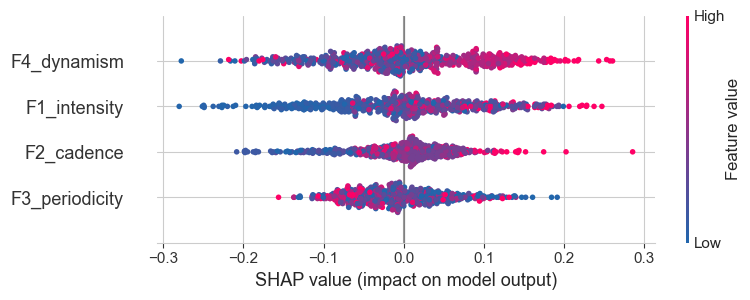


✅ SHAP FAC-analysis finished – biomechanical features only (F4 flipped).


In [76]:
# %% Cell 101  – SHAP (all sensors pooled, FAC task) – 5 features, warning-free
# --------------------------------------------------------------------------------
import shap, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("images", exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# 0)  Clinical labels for FAC classes
# ────────────────────────────────────────────────────────────────────────────────
FAC_LABELS = {1: "FAC-1 (very low)",
              2: "FAC-2 (low)",
              3: "FAC-3 (moderate)",
              4: "FAC-4 (high)",
              5: "FAC-5 (highest)"}


# -------------------------------------------------------------------------------
# 1)  Column order used during training  (5 biomech  +  5 PL_* flags)
# -------------------------------------------------------------------------------
all_cols   = (['F1_intensity','F2_cadence','F3_periodicity',
               'F4_dynamism'] +
              ['PL_LF','PL_LW','PL_RF','PL_RW','PL_SA'])
core_feats = all_cols[:4]                      # features we want to display

# -------------------------------------------------------------------------------
# 2)  The full train / test matrices are already in memory (Cell 35)
# -------------------------------------------------------------------------------
X_tr_df = pd.DataFrame(X_train, columns=all_cols)
X_te_df = pd.DataFrame(X_test , columns=all_cols)
true_fac = meta_test['FAC'].astype(int).values        # FAC labels 1…5

# -------------------------------------------------------------------------------
# 3)  Grab the trained model (already fitted on FAC 1…5)
# -------------------------------------------------------------------------------
gb_model = models['Random Forest']             # classifier with .predict_proba()

# -------------------------------------------------------------------------------
# 4)  Build SHAP explainer  (directly on FAC, no mapping needed)
# -------------------------------------------------------------------------------
#   SHAP will discover the model type (tree) and pick TreeExplainer internally.

def gb_proba_np(X):
    """Wrapper so SHAP sees a plain callable → returns FAC probabilities."""
    return gb_model.predict_proba(np.asarray(X))

explainer = shap.Explainer(
    gb_proba_np,
    X_tr_df,
    feature_names = all_cols,
    output_names  = [FAC_LABELS[c] for c in gb_model.classes_] )
shap_vals = explainer(X_te_df)                 # shape: (n_samples, n_features, 5)

# -------------------------------------------------------------------------------
# 5)  SHAP beeswarm – biomechanical features only, for FAC-1 (lowest mobility)
# -------------------------------------------------------------------------------
import matplotlib as mpl

# 0) build a custom two-colour LinearSegmentedColormap
blue_pink = mpl.colors.LinearSegmentedColormap.from_list(
    'blue_pink',
    ['#2166ac',     # deep blue  (low feature value)
     '#ff0066'],    # light pink (high feature value)
    N=256
)

# 1) choose the output node: FAC value 1  → find its column index
fac_idx = {c:i for i,c in enumerate(gb_model.classes_)}
target_class = fac_idx[5]                      # FAC-1

# 2) slice to that class
shap_fac1 = shap_vals[:, :, target_class]

# 3) and slice to the first 4 feature columns (= F1…F4)
bio_cols  = list(range(4))
shap_bio  = shap_fac1[:, bio_cols]

# 4) Flip SHAP direction for F4_dynamism (index 0 in biomech features)
shap_bio.values[:, 3] *= -1

# 5) build the beeswarm
plt.figure(figsize=(5, 5.5))
shap.summary_plot(
    shap_bio,
    features      = X_te_df.iloc[:, bio_cols],
    feature_names = core_feats,
    cmap          = blue_pink,
    show          = False
)
plt.axvline(0, color="grey", lw=0.8)
plt.tight_layout()
plt.savefig("images/summary_beeswarm_fac5_biomech_only_flipped.png", dpi=300)
plt.show()

print("\n✅ SHAP FAC-analysis finished – biomechanical features only (F4 flipped).")




## Histogram on balance

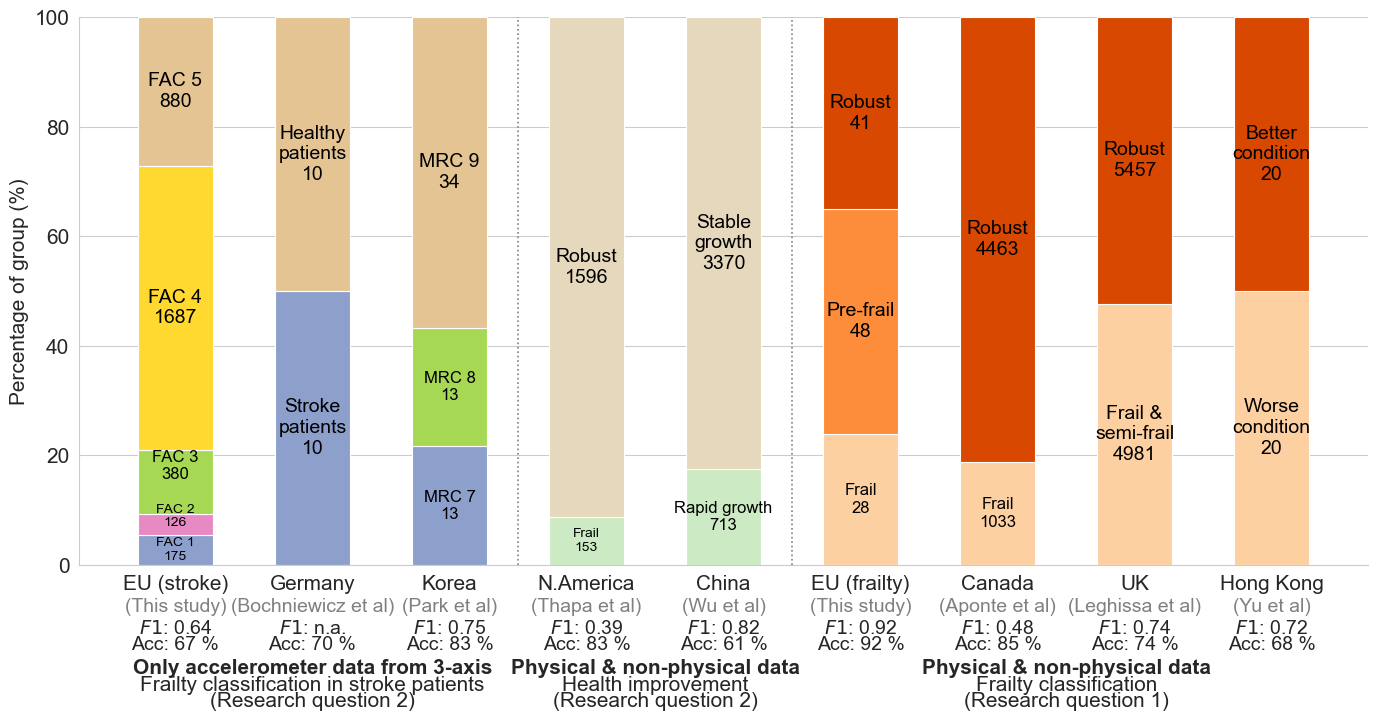

In [351]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import textwrap

# 1. Data --------------------------------------------------------
data_groups = [
    ('EU (stroke)', {
        'FAC 1': 175, 'FAC 2': 126, 'FAC 3': 380,
        'FAC 4': 1687, 'FAC 5': 880
    }),
    ('Germany', {
        'Stroke patients': 10, 'Healthy patients': 10
    }),
    ('Korea', {
        'MRC 7': 13, 'MRC 8': 13, 'MRC 9': 34
    }),
    ('N.America', {
        'Frail': 153, 'Robust': 1596
    }),
    ('China', {
        'Rapid growth': 713, 'Stable growth': 3370
    }),
    ('EU (frailty)', {
        'Frail': 28, 'Pre-frail': 48, 'Robust': 41
    }),
    ('Canada', {
        'Frail': 1033, 'Robust': 4463
    }),
    ('UK', {
        'Frail & semi-frail': 4981, 'Robust': 5457
    }),
    ('Hong Kong', {
        'Worse condition': 20, 'Better condition': 20
    }),
]

group_id_of_bar = [1, 1, 1, 2, 2, 3, 3, 3, 3]
palette_name = {1: 'Set2', 2: 'Pastel1', 3: 'Oranges'}


# 2. Helper functions --------------------------------------------
def pick_shades(cmap_name, n, strength=0.6):
    cmap = cm.get_cmap(cmap_name)
    return [cmap(0.25 + 0.5 * k / max(n - 1, 1)) for k in range(n)]

def wrap(txt, width=12):
    return '\n'.join(textwrap.wrap(txt, width=width, break_long_words=False))

# 3. F1 + Accuracy scores ----------------------------------------
f1_scores = [
    "$F1$: 0.64", "$F1$: n.a.", "$F1$: 0.75",
    "$F1$: 0.39", "$F1$: 0.82",
    "$F1$: 0.92", "$F1$: 0.48", "$F1$: 0.74", "$F1$: 0.72"
]

accuracy_scores = [
    "Acc: 67 %", "Acc: 70 %", "Acc: 83 %",
    "Acc: 83 %", "Acc: 61 %",
    "Acc: 92 %", "Acc: 85 %", "Acc: 74 %", "Acc: 68 %"
]

# 4. Group subtitles ---------------------------------------------
group_subtitles = {
    (0, 2): [
        "Only accelerometer data from 3-axis",
        "Frailty classification in stroke patients",
        "(Research question 2)"
    ],
    (3, 4): [
        "Physical & non-physical data",
        "Health improvement",
        "(Research question 2)"
    ],
    (5, 8): [
        "Physical & non-physical data",
        "Frailty classification",
        "(Research question 1)"
    ]
}

# 5. Plot --------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 7.5))
bottoms = np.zeros(len(data_groups))

for bar_idx, (study, cats) in enumerate(data_groups):
    colors = pick_shades(palette_name[group_id_of_bar[bar_idx]], len(cats))
    total = sum(cats.values())

    for (cat, cnt), col in zip(cats.items(), colors):
        pct = cnt / total * 100
        ax.bar(bar_idx, pct, bottom=bottoms[bar_idx],
               color=col, edgecolor='white', linewidth=0.8, width=0.55)

        fs = 14 if pct >= 25 else 12 if pct >= 10 else 10
        y_txt = bottoms[bar_idx] + pct / 2
        x_txt = bar_idx

        if bar_idx == 0:
            if cat == 'FAC 2':
                y_txt = bottoms[bar_idx] + pct * 0.9
            elif cat == 'FAC 3':
                y_txt = bottoms[bar_idx] + pct * 0.75

        ax.text(x_txt, y_txt, f"{wrap(cat)}\n{cnt}",
                ha='center', va='center', fontsize=fs, color='black')

        bottoms[bar_idx] += pct

# 6. Add citations just above F1 scores ---------------------------
label_y_base = -10  # lower baseline for better spacing
citation_texts = {
    'EU (stroke)': "(This study)",
    'EU (frailty)': "(This study)",
    'Germany': "(Bochniewicz et al)",
    'Korea': "(Park et al)",
    'N.America': "(Thapa et al)",
    'China': "(Wu et al)",
    'Canada': "(Aponte et al)",
    'UK': "(Leghissa et al)",
    'Hong Kong': "(Yu et al)",
}

citation_y_pos = label_y_base + 4  # move it up to -6 if label_y_base = -10

for idx, (name, _) in enumerate(data_groups):
    if name in citation_texts:
        ax.text(idx, citation_y_pos, citation_texts[name],
                ha='center', va='top', fontsize=14, color='gray')




for idx, (f1, acc) in enumerate(zip(f1_scores, accuracy_scores)):
    ax.text(idx, label_y_base, f1, ha='center', va='top', fontsize=14)
    ax.text(idx, label_y_base - 3.0, acc, ha='center', va='top', fontsize=14)

# 7. Group subtitles ---------------------------------------------
subtitle_y_base = label_y_base - 7.2
for (start, end), lines in group_subtitles.items():
    mid = (start + end) / 2
    for i, text in enumerate(lines):
        # Bold only the first line in each group if it matches these:
        fontweight = 'bold' if text in ["Only accelerometer data from 3-axis", "Physical & non-physical data"] else 'normal'
        ax.text(mid, subtitle_y_base - i * 3, text,
                ha='center', va='top', fontsize=15, fontweight=fontweight)


# 8. Decorations -------------------------------------------------
for sep_after in [2, 4]:
    ax.axvline(sep_after + 0.5, linestyle=':', linewidth=1.2, color='gray')

ax.set_ylabel('Percentage of group (%)', fontsize=15)
ax.set_ylim(0, 100)

ax.set_xticks(range(len(data_groups)))
wrapped_labels = [textwrap.fill(g, width=12) for g, _ in data_groups]
ax.set_xticklabels(wrapped_labels, rotation=0, ha='center', fontsize=15)

ax.tick_params(axis='y', labelsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("images/balanceSMOTE.png", dpi=300)
plt.show()
